In [1]:
import os
import sys
import pickle
import random
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import pandas as pd
import numpy as np

from pycox.datasets import kkbox_v1
from sklearn.model_selection import ParameterGrid
sys.path.append("../../")

from tools import test_quality, preprocess_kkbox, transform_kkbox

Set random seed

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

Data

In [3]:
df_train = kkbox_v1.read_df(subset='train')
df_test = kkbox_v1.read_df(subset='test')
df_val = kkbox_v1.read_df(subset='val')

x_train, t_train, y_train = preprocess_kkbox(df_train)
x_val, t_val, y_val = preprocess_kkbox(df_val)
x_test, t_test, y_test = preprocess_kkbox(df_test)

x_train, x_test, x_val = transform_kkbox(x_train, x_test, x_val)
data = {
    'train': {
        'x': x_train,
        'y': y_train,
        't': t_train
    },
    'test': {
        'x': x_test,
        'y': y_test,
        't': t_test            
    },
    'val': {
        'x': x_val,
        'y': y_val,
        't': t_val            
        }
    }

In [4]:
import json

from custom_models import kkbox_main_network as custom_bottom
from train import *

In [6]:
config_path = '../../data/config_kkbox_base.json'
custom_bottom_function_name = 'kkbox_main_network'
args = {
    'verbose': 0,
    'save_model': False
}

exec('from custom_models import ' + custom_bottom_function_name + ' as custom_bottom')
with open(config_path, 'rb') as f:
    config = json.load(f)

In [7]:
train_data = data['train']
val_data = None
seed = config['seed']

In [8]:
config['n_epochs'] = 2
config['n_epochs_contr'] = 2
config['n_epochs_both'] = 2
config['contrastive_weight'] = 0.1

config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'val_n_ex_bin': 1000,
 'n_epochs': 2,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 2,
 'n_epochs_both': 2,
 'contrastive_weight': 0.1}

In [55]:
def run_step(sess, data_gen, model, train_op, n_epochs, val_data=None):
    
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val

def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w = initialize_sgd_optimizer(config, model, optimize_only_main_loss=True, var_list=trainable_binary)
    train_op_c, global_step_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr)
    train_op_w_c, global_step_w_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary)
    # TODO: increment_global_step is not needed???
#     increment_global_step = tf.assign(global_step_w, global_step_w + 1)
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        # optimize main loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w, config['n_epochs'], val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 1: ", hist_losses_val)
        print("val main loss after step 1: ", hist_losses_main_val)
        
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_c, config['n_epochs_contr'], val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w_c, config['n_epochs_both'], val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        
        # save model
        if args['verbose'] == 1:
            print("Save model...")
        saver = tf.train.Saver()
        if args['save_model']:
            saver.save(sess, args['save_path'] + args["model_type"] + "_model")
    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val

def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(n_epochs[0], c='black', linestyle='--')
    ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0], c='black', linestyle='--')
    ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
    ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();


In [56]:
# hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
#     args=args, train_data=data['train'], val_data=None, config=config,
#     data_gen=data_gen, model=model, seed=config['seed'])

# all_q = []
# for pred in all_pred_train:
#     all_q.append(test_quality(t_true=data['train']['t'], y_true=data['train']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=103))
# df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

  0%|          | 0/2 [00:00<?, ?it/s]

val loss after step 1:  []
val main loss after step 1:  []


  0%|          | 0/2 [00:00<?, ?it/s]

val loss after step 2:  []
val main loss after step 2:  []


100%|██████████| 2/2 [21:02<00:00, 631.38s/it]


val loss after step 3:  []
val main loss after step 3:  []


AssertionError: Need all input to be np.ndarrays

In [57]:
hist_losses_train

[130.13739, 129.74756, 5.92159, 7.6956806, 1.7626593, 1.6148101]

In [58]:
hist_losses_main_train

[1.3940763, 1.3780881, 1.3776889, 1.3777618, 1.4467003, 1.455874]

In [59]:
all_q

[]

In [ ]:
all_q = []
for pred in tqdm.tqdm_notebook(all_pred_train):
    all_q.append(test_quality(t_true=data['train']['t'], y_true=data['train']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=103))
df_all_q = pd.concat(all_q)

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


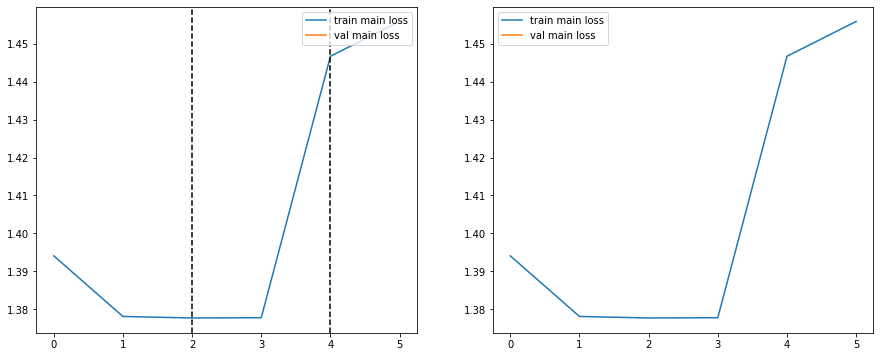

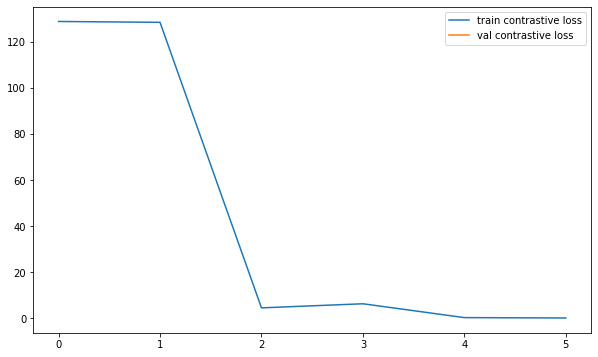

KeyError: 'dt_c_index'

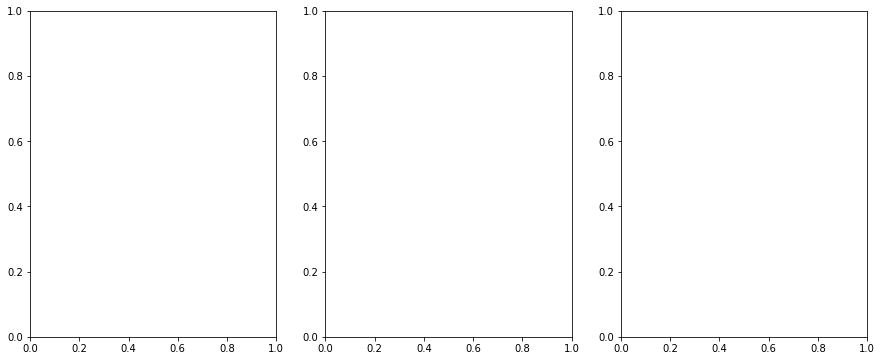

In [64]:
plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [25]:
config.update(
    {
        'n_epochs': 10,
        'n_epochs_contr': 5,
        'n_epochs_both': 10,
        'contrastive_weight': 0.5,
        'learning_rate': 0.001,
        'learning_rate_contr': 0.0005,
        'learning_rate_both': 0.00005
    }
)
config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 0.5,
 'n_epochs': 10,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 5,
 'n_epochs_both': 10,
 'learning_rate_contr': 0.0005,
 'learning_rate_both': 5e-05,
 'momentum': 0.7}

In [24]:
def run_step(sess, data_gen, model, train_op, n_epochs, train_data, val_data=None):
    try:
        print(train_op._lr)
    except:
        print('no _lr attribute')
        
    try:
        print(train_op._learning_rate)
    except:
        print('no _learning_rate attribute')
        
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val


def initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=None, params_ends=''):
    """ Define GradientDescentOptimizer from config """

    global_step = tf.Variable(0, trainable=False)
    # if exponential decay of learning rate is specified in config
    if ('step_rate' + params_ends not in config.keys()) or (config['step_rate'  + params_ends] == 0) or (
            'decay'  + params_ends not in config.keys()) or (config['decay' + params_ends] == 1):
        learning_rate = config['learning_rate' + params_ends]
    else:
        learning_rate = tf.train.exponential_decay(
            config['learning_rate' + params_ends], global_step, config['step_rate' + params_ends], config['decay' + params_ends], staircase=True)
    if var_list is None:
        var_list = tf.global_variables()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

    if optimize_only_main_loss:
        train_op = optimizer.minimize(model.main_loss, var_list=var_list)
    else:
        train_op = optimizer.minimize(model.loss, var_list=var_list)
        
    return train_op, global_step


def run_step(sess, data_gen, model, train_op, n_epochs, train_data, val_data=None):
       
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val


def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w = initialize_sgd_optimizer(config, model, optimize_only_main_loss=True, var_list=trainable_binary)
    train_op_c, global_step_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr, params_ends='_contr')
    train_op_w_c, global_step_w_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary, params_ends='_both')
    # TODO: increment_global_step is not needed???
#     increment_global_step = tf.assign(global_step_w, global_step_w + 1)
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        # optimize main loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w, config['n_epochs'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 1: ", hist_losses_val)
        print("val main loss after step 1: ", hist_losses_main_val)
        
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_c, config['n_epochs_contr'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w_c, config['n_epochs_both'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        
        # save model
        if args['verbose'] == 1:
            print("Save model...")
        saver = tf.train.Saver()
        if args['save_model']:
            saver.save(sess, args['save_path'] + args["model_type"] + "_model")
    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val

def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(n_epochs[0], c='black', linestyle='--')
    ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0], c='black', linestyle='--')
    ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
    ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();



100%|██████████| 10/10 [1:44:04<00:00, 624.49s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

val loss after step 1:  [638.74097, 658.86786, 716.0289, 636.7491, 741.83936, 830.26074, 774.8449, 775.5144, 636.3783, 647.33167]
val main loss after step 1:  [1.3913784, 1.3728542, 1.3678375, 1.3667041, 1.3630244, 1.3581303, 1.3580462, 1.3555796, 1.3579957, 1.3563262]



100%|██████████| 5/5 [51:44<00:00, 620.99s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

val loss after step 2:  [638.74097, 658.86786, 716.0289, 636.7491, 741.83936, 830.26074, 774.8449, 775.5144, 636.3783, 647.33167, 75.05529, 70.214, 13.80359, 34.04853, 96.189514]
val main loss after step 2:  [1.3913784, 1.3728542, 1.3678375, 1.3667041, 1.3630244, 1.3581303, 1.3580462, 1.3555796, 1.3579957, 1.3563262, 1.3566812, 1.3572959, 1.357083, 1.3567649, 1.3589226]



100%|██████████| 10/10 [1:45:17<00:00, 631.74s/it]


val loss after step 3:  [638.74097, 658.86786, 716.0289, 636.7491, 741.83936, 830.26074, 774.8449, 775.5144, 636.3783, 647.33167, 75.05529, 70.214, 13.80359, 34.04853, 96.189514, 2.0090559, 1.9293878, 1.9847667, 1.9209332, 1.7627766, 1.9552802, 1.9283704, 1.8557799, 1.8482336, 1.7983363]
val main loss after step 3:  [1.3913784, 1.3728542, 1.3678375, 1.3667041, 1.3630244, 1.3581303, 1.3580462, 1.3555796, 1.3579957, 1.3563262, 1.3566812, 1.3572959, 1.357083, 1.3567649, 1.3589226, 1.4739457, 1.4656107, 1.4631015, 1.4588261, 1.4557657, 1.4516606, 1.4522935, 1.4529454, 1.4517089, 1.4505401]


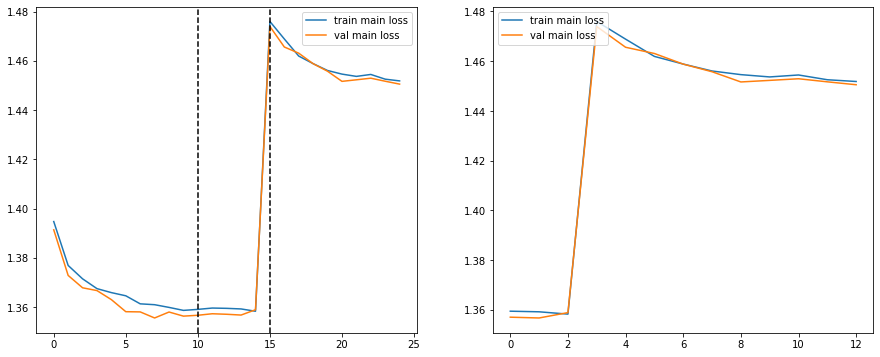

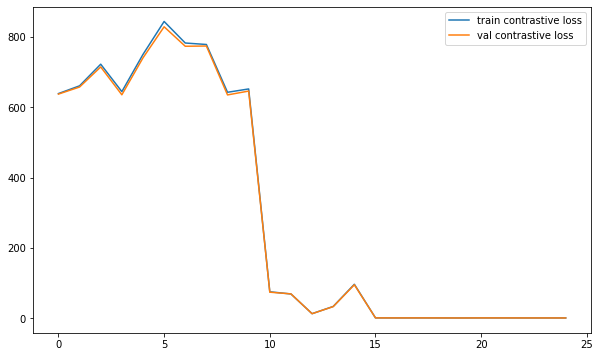

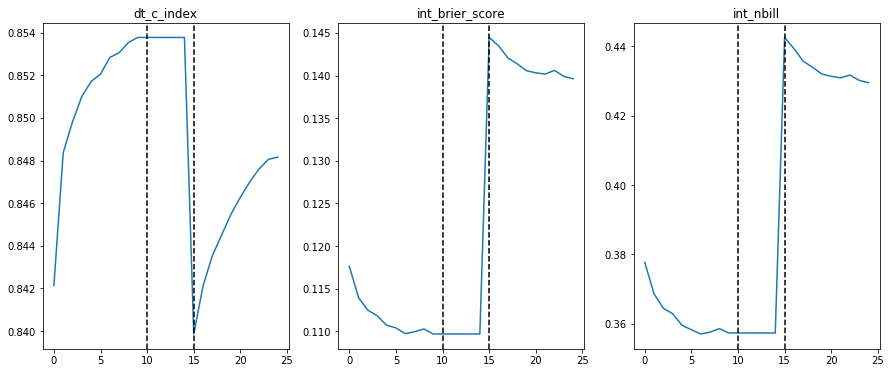

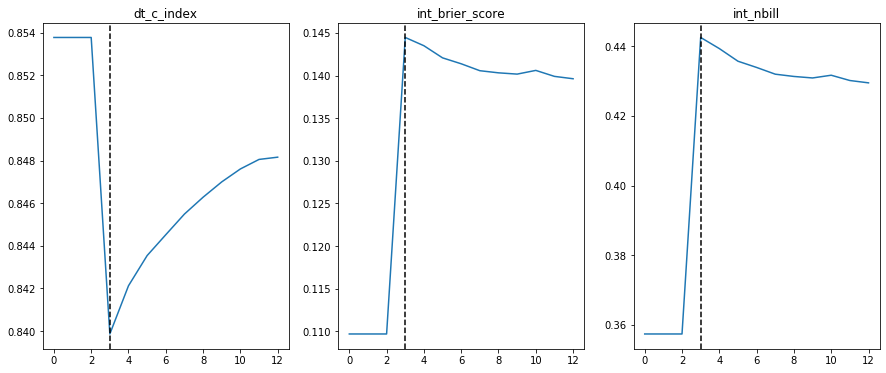

In [11]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [ ]:
# more contrastive only epochs with lower learning rate

In [12]:
config.update(
    {
        'n_epochs': 15,
        'n_epochs_contr': 15,
        'n_epochs_both': 15,
        'contrastive_weight': 0.5,
        'learning_rate': 0.001,
        'learning_rate_contr': 0.0001,
        'learning_rate_both': 0.00005
    }
)
config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 0.5,
 'n_epochs': 15,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 15,
 'n_epochs_both': 15,
 'learning_rate_contr': 0.0001,
 'learning_rate_both': 5e-05}


100%|██████████| 15/15 [2:35:23<00:00, 621.57s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 1:  [636.39087, 657.3622, 716.0104, 639.791, 743.5253, 835.0869, 775.4484, 775.5888, 635.91284, 646.54266, 782.05347, 667.8356, 814.5614, 694.13983, 764.24445]
val main loss after step 1:  [1.3913794, 1.3728627, 1.3678886, 1.3667048, 1.3630308, 1.3581444, 1.3580055, 1.3555646, 1.3579334, 1.3563052, 1.3561608, 1.3558335, 1.3552676, 1.3540721, 1.3559924]



100%|██████████| 15/15 [2:35:13<00:00, 620.90s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [636.39087, 657.3622, 716.0104, 639.791, 743.5253, 835.0869, 775.4484, 775.5888, 635.91284, 646.54266, 782.05347, 667.8356, 814.5614, 694.13983, 764.24445, 12.872789, 10.057072, 12.892696, 23.036411, 5.538097, 29.943872, 28.12464, 4.989015, 33.89131, 2.5689595, 33.91359, 30.225782, 14.686262, 15.816153, 11.727137]
val main loss after step 2:  [1.3913794, 1.3728627, 1.3678886, 1.3667048, 1.3630308, 1.3581444, 1.3580055, 1.3555646, 1.3579334, 1.3563052, 1.3561608, 1.3558335, 1.3552676, 1.3540721, 1.3559924, 1.3531677, 1.3519682, 1.3557075, 1.3541864, 1.355319, 1.3520082, 1.3533896, 1.3523366, 1.3545035, 1.3537381, 1.3557632, 1.3548177, 1.353016, 1.3579359, 1.3532704]



100%|██████████| 15/15 [2:37:29<00:00, 629.98s/it]


val loss after step 3:  [636.39087, 657.3622, 716.0104, 639.791, 743.5253, 835.0869, 775.4484, 775.5888, 635.91284, 646.54266, 782.05347, 667.8356, 814.5614, 694.13983, 764.24445, 12.872789, 10.057072, 12.892696, 23.036411, 5.538097, 29.943872, 28.12464, 4.989015, 33.89131, 2.5689595, 33.91359, 30.225782, 14.686262, 15.816153, 11.727137, 1.9906431, 1.816184, 1.9902824, 2.027881, 1.858174, 1.8013728, 2.0361063, 1.7530184, 1.8579798, 1.9672085, 1.8976961, 1.8991872, 1.9522828, 1.9081935, 2.0199878]
val main loss after step 3:  [1.3913794, 1.3728627, 1.3678886, 1.3667048, 1.3630308, 1.3581444, 1.3580055, 1.3555646, 1.3579334, 1.3563052, 1.3561608, 1.3558335, 1.3552676, 1.3540721, 1.3559924, 1.3531677, 1.3519682, 1.3557075, 1.3541864, 1.355319, 1.3520082, 1.3533896, 1.3523366, 1.3545035, 1.3537381, 1.3557632, 1.3548177, 1.353016, 1.3579359, 1.3532704, 1.4505311, 1.4456285, 1.4437009, 1.4444764, 1.4446119, 1.444051, 1.4444274, 1.4395487, 1.4428177, 1.4403757, 1.4402876, 1.4417241, 1.441677,

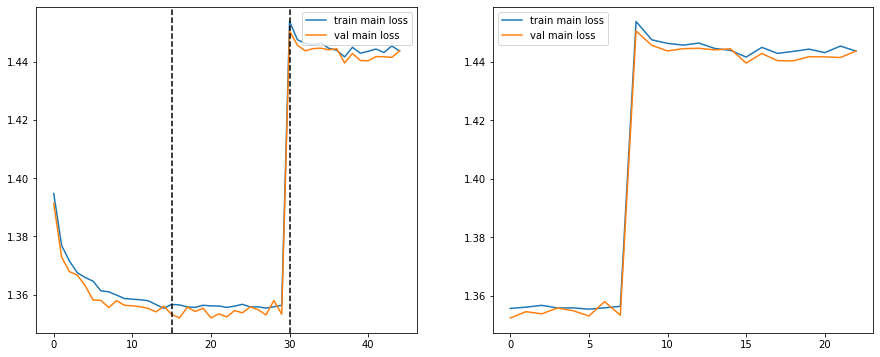

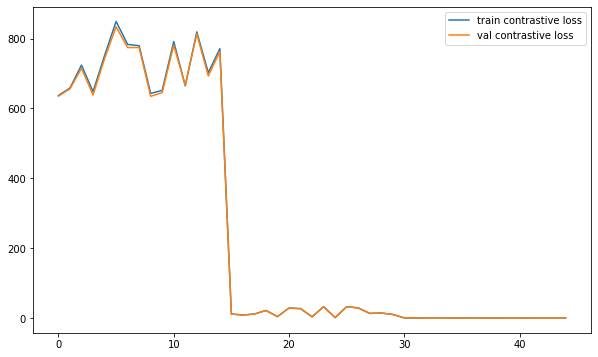

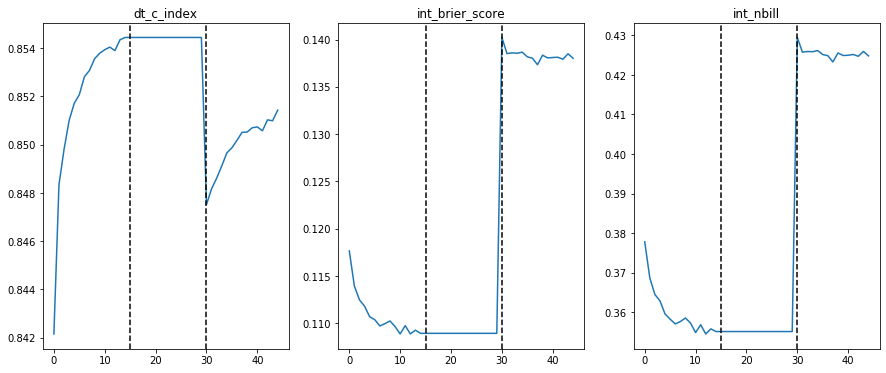

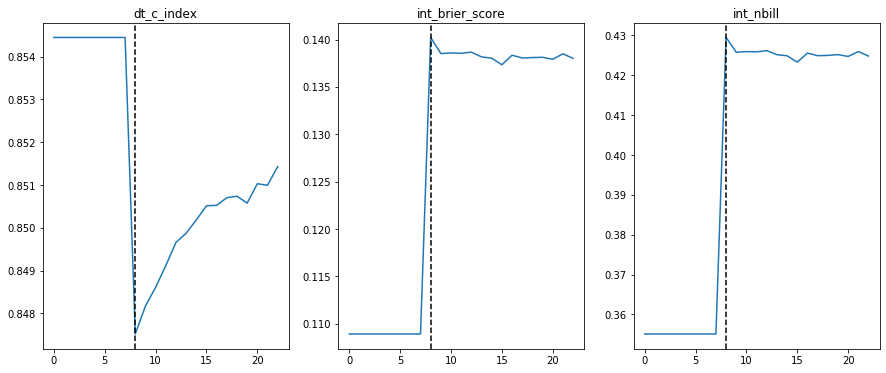

In [13]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

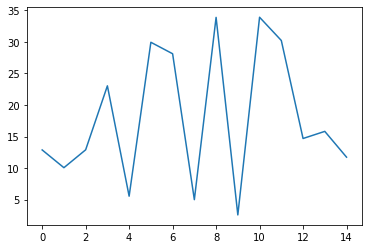

In [14]:
plt.plot([12.872789, 10.057072, 12.892696, 23.036411, 5.538097, 29.943872, 28.12464, 4.989015, 33.89131, 2.5689595, 33.91359, 30.225782, 14.686262, 15.816153, 11.727137])

In [15]:
# more contrastive only epochs with lower learning rate

In [17]:
config.update(
    {
        'n_epochs': 15,
        'n_epochs_contr': 25,
        'n_epochs_both': 15,
        'contrastive_weight': 0.5,
        'learning_rate': 0.001,
        'learning_rate_contr': 0.00005,
        'learning_rate_both': 0.00005
    }
)
config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 0.5,
 'n_epochs': 15,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 25,
 'n_epochs_both': 15,
 'learning_rate_contr': 5e-05,
 'learning_rate_both': 5e-05}


100%|██████████| 15/15 [2:35:33<00:00, 622.24s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

val loss after step 1:  [640.5293, 656.7477, 714.89246, 637.3976, 743.193, 834.83844, 772.3578, 779.2837, 638.8825, 651.32245, 787.14453, 668.0813, 821.0937, 697.318, 772.83124]
val main loss after step 1:  [1.3913472, 1.3728555, 1.3678316, 1.3667198, 1.3630215, 1.3581115, 1.3579955, 1.3555427, 1.3579335, 1.3562533, 1.3561443, 1.3557633, 1.3553253, 1.354041, 1.3558673]



100%|██████████| 25/25 [4:18:27<00:00, 620.32s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [640.5293, 656.7477, 714.89246, 637.3976, 743.193, 834.83844, 772.3578, 779.2837, 638.8825, 651.32245, 787.14453, 668.0813, 821.0937, 697.318, 772.83124, 7.114382, 4.999402, 7.7310166, 12.670694, 3.7064395, 15.754023, 15.488012, 4.372322, 17.612501, 3.1883044, 18.506329, 16.525434, 7.3710494, 7.8307085, 7.5166106, 13.185994, 5.8078995, 5.0916867, 14.177701, 18.219402, 9.251305, 16.823662, 1.7894095, 4.3111286, 16.122849]
val main loss after step 2:  [1.3913472, 1.3728555, 1.3678316, 1.3667198, 1.3630215, 1.3581115, 1.3579955, 1.3555427, 1.3579335, 1.3562533, 1.3561443, 1.3557633, 1.3553253, 1.354041, 1.3558673, 1.3530414, 1.3518504, 1.3555636, 1.3540262, 1.355194, 1.3518558, 1.3532512, 1.3522387, 1.3543653, 1.3536135, 1.3555921, 1.3547033, 1.3528508, 1.3578342, 1.3531545, 1.3517257, 1.353514, 1.3512053, 1.3525976, 1.353127, 1.3527796, 1.3554894, 1.3523282, 1.3517514, 1.350611]



100%|██████████| 15/15 [2:37:27<00:00, 629.82s/it]


val loss after step 3:  [640.5293, 656.7477, 714.89246, 637.3976, 743.193, 834.83844, 772.3578, 779.2837, 638.8825, 651.32245, 787.14453, 668.0813, 821.0937, 697.318, 772.83124, 7.114382, 4.999402, 7.7310166, 12.670694, 3.7064395, 15.754023, 15.488012, 4.372322, 17.612501, 3.1883044, 18.506329, 16.525434, 7.3710494, 7.8307085, 7.5166106, 13.185994, 5.8078995, 5.0916867, 14.177701, 18.219402, 9.251305, 16.823662, 1.7894095, 4.3111286, 16.122849, 1.881236, 1.9092166, 2.006582, 1.9283695, 2.0317903, 2.0299096, 1.985166, 1.925665, 1.956378, 2.012293, 1.9866256, 2.0313385, 1.986062, 2.030227, 2.0298738]
val main loss after step 3:  [1.3913472, 1.3728555, 1.3678316, 1.3667198, 1.3630215, 1.3581115, 1.3579955, 1.3555427, 1.3579335, 1.3562533, 1.3561443, 1.3557633, 1.3553253, 1.354041, 1.3558673, 1.3530414, 1.3518504, 1.3555636, 1.3540262, 1.355194, 1.3518558, 1.3532512, 1.3522387, 1.3543653, 1.3536135, 1.3555921, 1.3547033, 1.3528508, 1.3578342, 1.3531545, 1.3517257, 1.353514, 1.3512053, 1.35

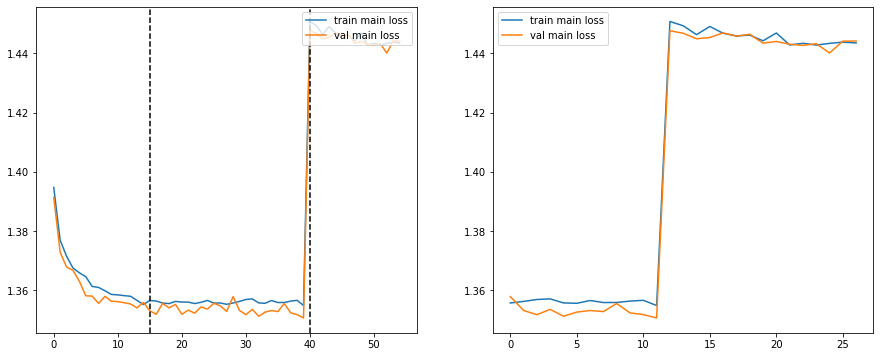

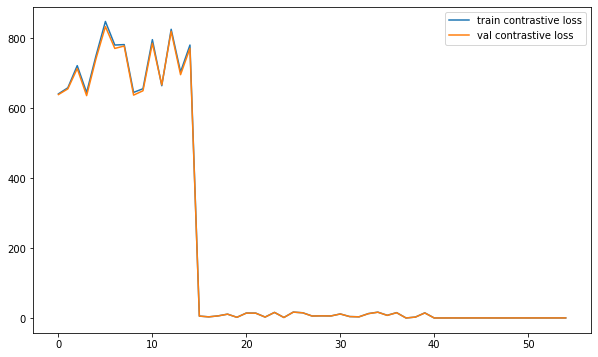

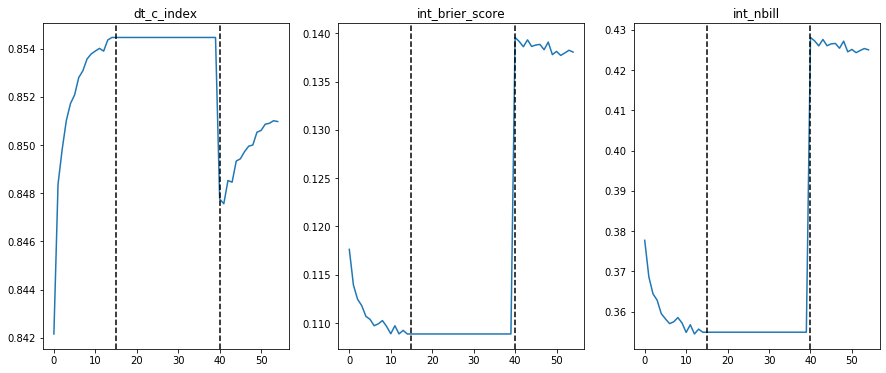

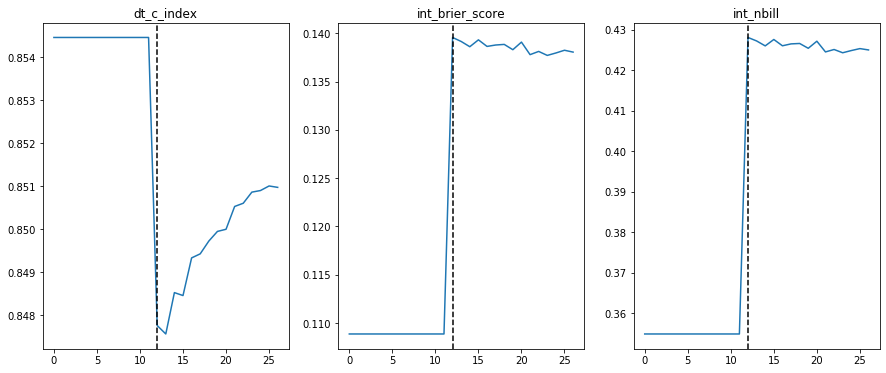

In [18]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

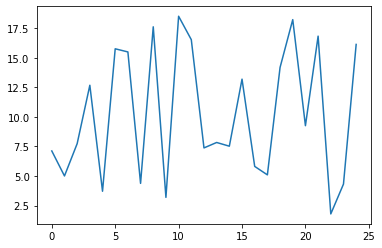

In [22]:
plt.plot([7.114382, 4.999402, 7.7310166, 12.670694, 3.7064395, 15.754023, 15.488012, 4.372322, 17.612501, 3.1883044, 18.506329, 16.525434, 7.3710494, 7.8307085, 7.5166106, 13.185994, 5.8078995, 5.0916867, 14.177701, 18.219402, 9.251305, 16.823662, 1.7894095, 4.3111286, 16.122849])

In [ ]:
# change 2 and 3 optimizer from sgd to momentum

In [8]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}

config.update(
    {
        'n_epochs': 15,
        'n_epochs_contr': 25,
        'n_epochs_both': 15,
        'contrastive_weight': 0.5,
        'learning_rate': 0.001,
        'learning_rate_contr': 0.00005,
        'learning_rate_both': 0.00005,
        'momentum_both': 0.7,
        'momentum_contr': 0.7
    }
)
config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 0.5,
 'n_epochs': 15,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 25,
 'n_epochs_both': 15,
 'learning_rate_contr': 5e-05,
 'learning_rate_both': 5e-05,
 'momentum_both': 0.7,
 'momentum_contr': 0.7}

In [23]:
def run_step(sess, data_gen, model, train_op, n_epochs, train_data, val_data=None):
    try:
        print(train_op._lr)
    except:
        print('no _lr attribute')
        
    try:
        print(train_op._learning_rate)
    except:
        print('no _learning_rate attribute')
        
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val


def initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=None, params_ends='', opt_type='sgd'):
    """ Define GradientDescentOptimizer from config """

    global_step = tf.Variable(0, trainable=False)
    # if exponential decay of learning rate is specified in config
    if ('step_rate' + params_ends not in config.keys()) or (config['step_rate'  + params_ends] == 0) or (
            'decay'  + params_ends not in config.keys()) or (config['decay' + params_ends] == 1):
        learning_rate = config['learning_rate' + params_ends]
    else:
        learning_rate = tf.train.exponential_decay(
            config['learning_rate' + params_ends], global_step, config['step_rate' + params_ends], config['decay' + params_ends], staircase=True)
    if var_list is None:
        var_list = tf.global_variables()
    if opt_type == 'sgd':        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    elif opt_type == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=config['momentum' + params_ends])
        
    if optimize_only_main_loss:
        train_op = optimizer.minimize(model.main_loss, var_list=var_list)
    else:
        train_op = optimizer.minimize(model.loss, var_list=var_list)
        
    return train_op, global_step, optimizer



def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w = initialize_sgd_optimizer(config, model, optimize_only_main_loss=True, var_list=trainable_binary)
    train_op_c, global_step_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr, params_ends='_contr',
                                                        opt_type='momentum')
    train_op_w_c, global_step_w_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary, params_ends='_both', 
                                                            opt_type='momentum')
    # TODO: increment_global_step is not needed???
#     increment_global_step = tf.assign(global_step_w, global_step_w + 1)
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        # optimize main loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w, config['n_epochs'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 1: ", hist_losses_val)
        print("val main loss after step 1: ", hist_losses_main_val)
        
        # save model
        if args['verbose'] == 1:
            print("Save model...")
        saver = tf.train.Saver()
        if args['save_model']:
            saver.save(sess, args['save_path'] + args["model_type"] + "_model")
            
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_c, config['n_epochs_contr'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w_c, config['n_epochs_both'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        

    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val


  0%|          | 0/15 [00:00<?, ?it/s]

no _lr attribute
no _learning_rate attribute



100%|██████████| 15/15 [2:36:38<00:00, 626.57s/it]


val loss after step 1:  [637.9819, 658.32495, 716.57513, 637.804, 740.3634, 832.9763, 776.95496, 780.60657, 637.9067, 649.1888, 791.6991, 669.4748, 814.683, 692.27094, 776.5795]
val main loss after step 1:  [1.39141, 1.3728678, 1.3678237, 1.3667151, 1.3630072, 1.3581207, 1.3580251, 1.3555369, 1.3579371, 1.3562922, 1.3561943, 1.3557761, 1.3552278, 1.3540303, 1.3558804]



  0%|          | 0/25 [00:00<?, ?it/s]

no _lr attribute
no _learning_rate attribute



100%|██████████| 25/25 [4:19:46<00:00, 623.44s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [637.9819, 658.32495, 716.57513, 637.804, 740.3634, 832.9763, 776.95496, 780.60657, 637.9067, 649.1888, 791.6991, 669.4748, 814.683, 692.27094, 776.5795, 8.437896, 15.431078, 7.9325657, 2.0390618, 1.8675573, 3.3003068, 8.781172, 17.563572, 13.209598, 24.121632, 29.220873, 14.816155, 2.468654, 7.0648317, 16.241966, 2.5569685, 11.788634, 4.6895127, 20.482239, 5.3838353, 12.808748, 12.637777, 10.337015, 3.9910266, 14.582473]
val main loss after step 2:  [1.39141, 1.3728678, 1.3678237, 1.3667151, 1.3630072, 1.3581207, 1.3580251, 1.3555369, 1.3579371, 1.3562922, 1.3561943, 1.3557761, 1.3552278, 1.3540303, 1.3558804, 1.3530295, 1.3518513, 1.3555821, 1.354045, 1.3552074, 1.3518478, 1.3532727, 1.352228, 1.3543731, 1.3536215, 1.3556029, 1.354708, 1.3528545, 1.3578448, 1.3531846, 1.3517257, 1.3535082, 1.3511984, 1.3525763, 1.3531209, 1.3527828, 1.3554853, 1.3523344, 1.3517495, 1.3506285]
no _lr attribute
no _learning_rate attribute



100%|██████████| 15/15 [2:38:23<00:00, 633.55s/it]


val loss after step 3:  [637.9819, 658.32495, 716.57513, 637.804, 740.3634, 832.9763, 776.95496, 780.60657, 637.9067, 649.1888, 791.6991, 669.4748, 814.683, 692.27094, 776.5795, 8.437896, 15.431078, 7.9325657, 2.0390618, 1.8675573, 3.3003068, 8.781172, 17.563572, 13.209598, 24.121632, 29.220873, 14.816155, 2.468654, 7.0648317, 16.241966, 2.5569685, 11.788634, 4.6895127, 20.482239, 5.3838353, 12.808748, 12.637777, 10.337015, 3.9910266, 14.582473, 1.9750891, 1.8542848, 1.908343, 1.9005849, 1.8193882, 2.2032394, 1.9476558, 1.7687378, 1.8429251, 1.8680478, 2.0621722, 1.8559688, 1.9918553, 1.855804, 1.9949977]
val main loss after step 3:  [1.39141, 1.3728678, 1.3678237, 1.3667151, 1.3630072, 1.3581207, 1.3580251, 1.3555369, 1.3579371, 1.3562922, 1.3561943, 1.3557761, 1.3552278, 1.3540303, 1.3558804, 1.3530295, 1.3518513, 1.3555821, 1.354045, 1.3552074, 1.3518478, 1.3532727, 1.352228, 1.3543731, 1.3536215, 1.3556029, 1.354708, 1.3528545, 1.3578448, 1.3531846, 1.3517257, 1.3535082, 1.3511984,

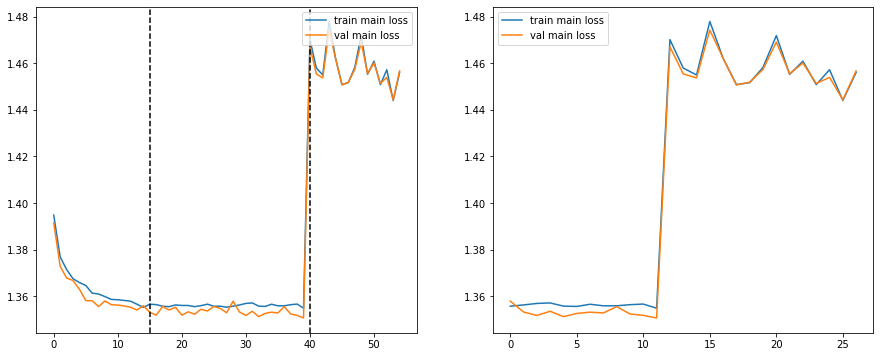

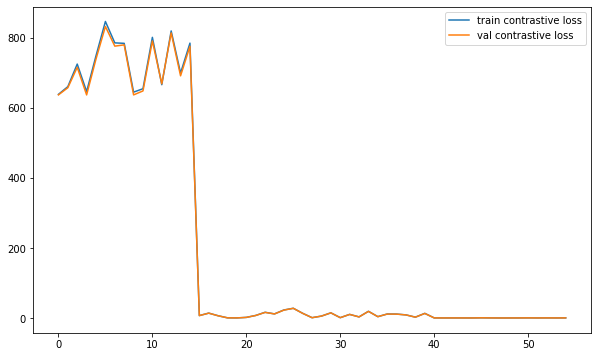

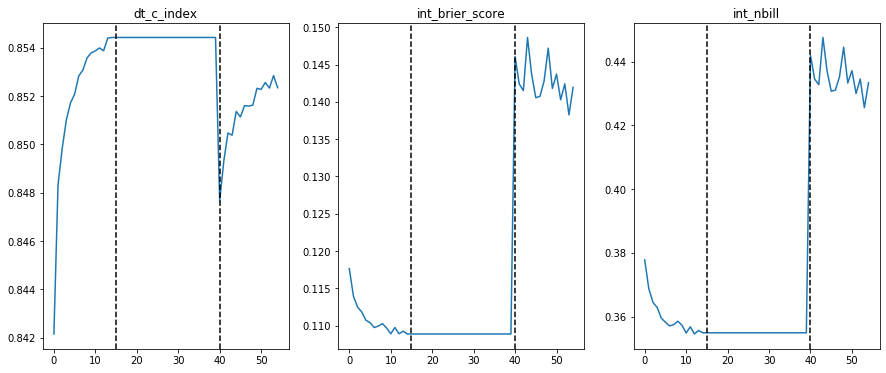

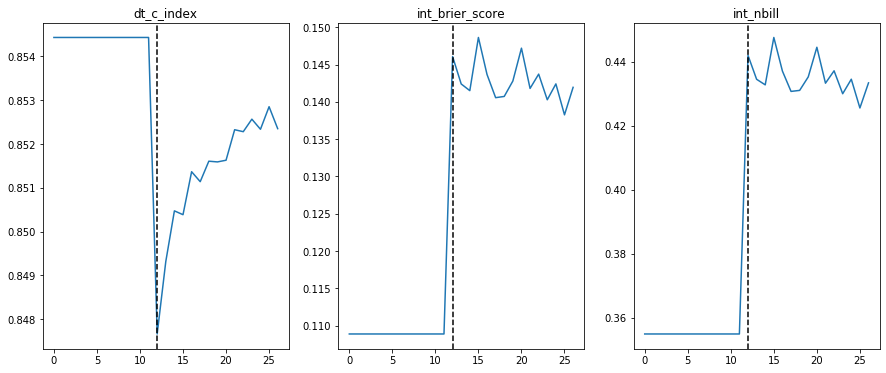

In [32]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [8]:
def initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=None, params_ends='', opt_type='sgd'):
    """ Define GradientDescentOptimizer from config """

    global_step = tf.Variable(0, trainable=False)
    # if exponential decay of learning rate is specified in config
    if ('step_rate' + params_ends not in config.keys()) or (config['step_rate'  + params_ends] == 0) or (
            'decay'  + params_ends not in config.keys()) or (config['decay' + params_ends] == 1):
        learning_rate = config['learning_rate' + params_ends]
    else:
        learning_rate = tf.train.exponential_decay(
            config['learning_rate' + params_ends], global_step, config['step_rate' + params_ends], config['decay' + params_ends], staircase=True)
    if var_list is None:
        var_list = tf.global_variables()
    if opt_type == 'sgd':        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    elif opt_type == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=config['momentum' + params_ends])
        
    if optimize_only_main_loss:
        train_op = optimizer.minimize(model.main_loss, var_list=var_list)
    else:
        train_op = optimizer.minimize(model.loss, var_list=var_list)
        
    return train_op, global_step, optimizer


def run_step(sess, data_gen, model, optimizer, global_step, train_op, n_epochs, train_data, val_data=None):
    
    increment_global_step = tf.assign(global_step, global_step + 1)    
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))
        
        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])

#         print(sess.run(optimizer._learning_rate))
        sess.run(increment_global_step)
#         print(sess.run(optimizer._learning_rate))
        
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val



def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w, optimizer_w = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=True, var_list=trainable_binary)
    train_op_c, global_step_c, optimizer_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr, params_ends='_contr', opt_type='momentum')
    train_op_w_c, global_step_w_c, optimizer_w_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary, params_ends='_both', opt_type='momentum')
    
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
          
        # optimize main loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_w, global_step_w, train_op_w, config['n_epochs'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 1: ", hist_losses_val)
        print("val main loss after step 1: ", hist_losses_main_val)
        
        # save model
        if args['verbose'] == 1:
            print("Save model...")
        saver = tf.train.Saver()
        if args['save_model']:
            saver.save(sess, args['save_path'] + args["model_type"] + "_model")
            
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_c, global_step_c, train_op_c, config['n_epochs_contr'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        plt.plot(step_hist_losses_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_w_c, global_step_w_c, train_op_w_c, config['n_epochs_both'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        

    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val


def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(n_epochs[0], c='black', linestyle='--')
    ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0], c='black', linestyle='--')
    ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
    ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();


In [73]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.5,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 25,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.7,
    
    'n_epochs_both': 15,
    'learning_rate_both': 5e-05,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.7
}




  0%|          | 0/15 [00:00<?, ?it/s]


  7%|▋         | 1/15 [10:24<2:25:44, 624.58s/it]


 13%|█▎        | 2/15 [20:47<2:15:14, 624.17s/it]


 20%|██        | 3/15 [31:11<2:04:46, 623.92s/it]


 27%|██▋       | 4/15 [41:33<1:54:18, 623.47s/it]


 33%|███▎      | 5/15 [51:56<1:43:53, 623.37s/it]


 40%|████      | 6/15 [1:02:19<1:33:28, 623.15s/it]


 47%|████▋     | 7/15 [1:12:42<1:23:04, 623.04s/it]


 53%|█████▎    | 8/15 [1:23:05<1:12:41, 623.14s/it]


 60%|██████    | 9/15 [1:33:27<1:02:17, 622.91s/it]


 67%|██████▋   | 10/15 [1:43:50<51:54, 622.85s/it] 


 73%|███████▎  | 11/15 [1:54:13<41:32, 623.01s/it]


 80%|████████  | 12/15 [2:04:36<31:08, 622.84s/it]


 87%|████████▋ | 13/15 [2:14:59<20:45, 622.79s/it]


 93%|█████████▎| 14/15 [2:25:22<10:22, 622.84s/it]


100%|██████████| 15/15 [2:35:44<00:00, 622.98s/it]


val loss after step 1:  [638.38934, 654.71497, 714.2146, 637.90265, 740.90875, 827.6025, 771.17596, 780.97107, 653.5735, 654.8485, 796.56067, 679.6401, 823.1669, 698.69977, 757.2022]
val main loss after step 1:  [1.391332, 1.3729652, 1.3677987, 1.3666674, 1.3629645, 1.3575759, 1.3578919, 1.3554578, 1.35762, 1.3562366, 1.3561769, 1.3558136, 1.3552208, 1.3541522, 1.3559806]





  0%|          | 0/25 [00:00<?, ?it/s]


  4%|▍         | 1/25 [10:23<4:09:28, 623.68s/it]


  8%|▊         | 2/25 [20:46<3:58:59, 623.47s/it]


 12%|█▏        | 3/25 [31:09<3:48:31, 623.24s/it]


 16%|█▌        | 4/25 [41:33<3:38:10, 623.38s/it]


 20%|██        | 5/25 [51:55<3:27:42, 623.12s/it]


 24%|██▍       | 6/25 [1:02:18<3:17:16, 622.98s/it]


 28%|██▊       | 7/25 [1:12:41<3:06:54, 623.04s/it]


 32%|███▏      | 8/25 [1:23:03<2:56:26, 622.76s/it]


 36%|███▌      | 9/25 [1:33:25<2:46:01, 622.57s/it]


 40%|████      | 10/25 [1:43:48<2:35:39, 622.62s/it]


 44%|████▍     | 11/25 [1:54:11<2:25:17, 622.71s/it]


 48%|████▊     | 12/25 [2:04:33<2:14:53, 622.59s/it]


 52%|█████▏    | 13/25 [2:14:55<2:04:29, 622.47s/it]


 56%|█████▌    | 14/25 [2:25:19<1:54:09, 622.70s/it]


 60%|██████    | 15/25 [2:35:41<1:43:45, 622.58s/it]


 64%|██████▍   | 16/25 [2:46:03<1:33:22, 622.53s/it]


 68%|██████▊   | 17/25 [2:56:27<1:23:02, 622.79s/it]


 72%|███████▏  | 18/25 [3:06:49<1:12:39,

val loss after step 2:  [638.38934, 654.71497, 714.2146, 637.90265, 740.90875, 827.6025, 771.17596, 780.97107, 653.5735, 654.8485, 796.56067, 679.6401, 823.1669, 698.69977, 757.2022, 4.422113, 40.198204, 224.18036, 30.443583, 90.90356, 112.41942, 72.09481, 80.08066, 92.51093, 24.411592, 298.47098, 137.17555, 18.067944, 116.661674, 156.68515, 106.91331, 21.111881, 23.460442, 192.17712, 97.86089, 23.483456, 5.410555, 2.6995487, 35.6068, 126.6151]
val main loss after step 2:  [1.391332, 1.3729652, 1.3677987, 1.3666674, 1.3629645, 1.3575759, 1.3578919, 1.3554578, 1.35762, 1.3562366, 1.3561769, 1.3558136, 1.3552208, 1.3541522, 1.3559806, 1.353157, 1.35204, 1.355669, 1.3541664, 1.3554183, 1.3520409, 1.3534163, 1.3524286, 1.3545021, 1.3537328, 1.3558758, 1.3548472, 1.3530879, 1.3579537, 1.3533273, 1.3518231, 1.3537784, 1.3513018, 1.352819, 1.3533077, 1.3529671, 1.3555939, 1.3525425, 1.3520249, 1.3508071]





  7%|▋         | 1/15 [10:34<2:27:57, 634.09s/it]


 13%|█▎        | 2/15 [21:06<2:17:15, 633.51s/it]


 20%|██        | 3/15 [31:39<2:06:39, 633.29s/it]


 27%|██▋       | 4/15 [42:11<1:56:05, 633.19s/it]


 33%|███▎      | 5/15 [52:43<1:45:28, 632.84s/it]


 40%|████      | 6/15 [1:03:15<1:34:53, 632.57s/it]


 47%|████▋     | 7/15 [1:13:49<1:24:23, 632.89s/it]


 53%|█████▎    | 8/15 [1:24:21<1:13:49, 632.74s/it]


 60%|██████    | 9/15 [1:34:54<1:03:15, 632.61s/it]


 67%|██████▋   | 10/15 [1:45:27<52:43, 632.78s/it] 


 73%|███████▎  | 11/15 [1:55:59<42:10, 632.61s/it]


 80%|████████  | 12/15 [2:06:31<31:37, 632.45s/it]


 87%|████████▋ | 13/15 [2:17:04<21:05, 632.53s/it]


 93%|█████████▎| 14/15 [2:27:36<10:32, 632.51s/it]


100%|██████████| 15/15 [2:38:09<00:00, 632.61s/it]


val loss after step 3:  [638.38934, 654.71497, 714.2146, 637.90265, 740.90875, 827.6025, 771.17596, 780.97107, 653.5735, 654.8485, 796.56067, 679.6401, 823.1669, 698.69977, 757.2022, 4.422113, 40.198204, 224.18036, 30.443583, 90.90356, 112.41942, 72.09481, 80.08066, 92.51093, 24.411592, 298.47098, 137.17555, 18.067944, 116.661674, 156.68515, 106.91331, 21.111881, 23.460442, 192.17712, 97.86089, 23.483456, 5.410555, 2.6995487, 35.6068, 126.6151, 1.9844359, 1.96579, 1.9124789, 1.9003795, 1.9848754, 1.9509245, 2.107132, 2.0153637, 1.8938779, 1.8593332, 1.8214003, 1.9159062, 2.2083826, 1.9640524, 1.8536592]
val main loss after step 3:  [1.391332, 1.3729652, 1.3677987, 1.3666674, 1.3629645, 1.3575759, 1.3578919, 1.3554578, 1.35762, 1.3562366, 1.3561769, 1.3558136, 1.3552208, 1.3541522, 1.3559806, 1.353157, 1.35204, 1.355669, 1.3541664, 1.3554183, 1.3520409, 1.3534163, 1.3524286, 1.3545021, 1.3537328, 1.3558758, 1.3548472, 1.3530879, 1.3579537, 1.3533273, 1.3518231, 1.3537784, 1.3513018, 1.3

NameError: name 'plot_results' is not defined

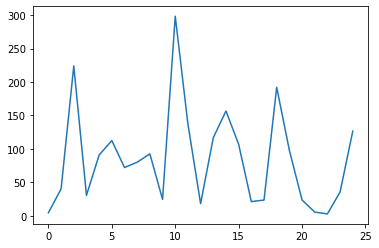

In [74]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

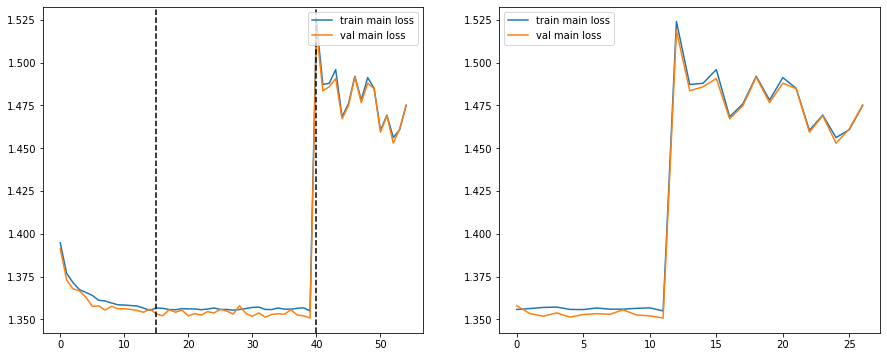

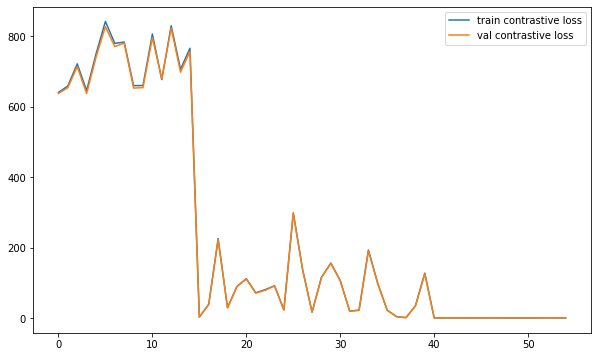

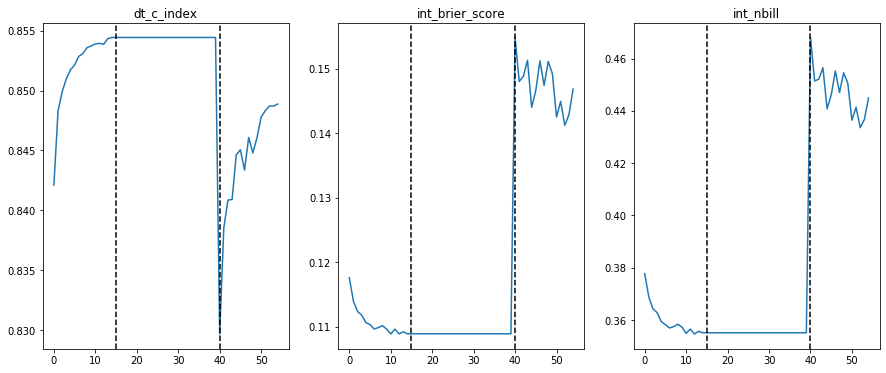

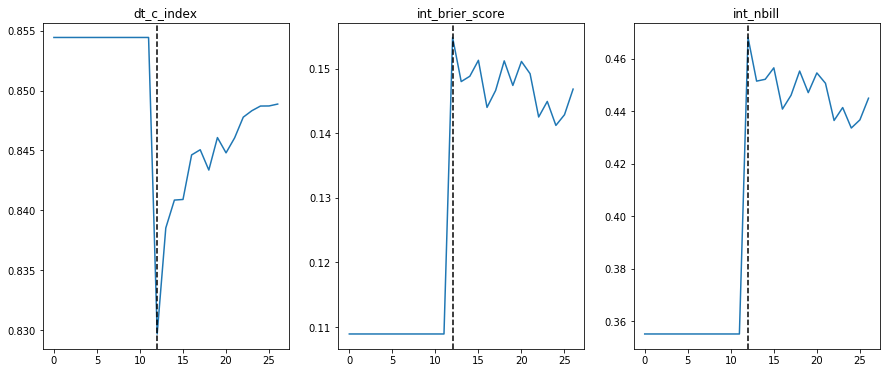

In [76]:
plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [ ]:
# 'n_ex_bin': 30, bigger
# 'margin_weight': 1, ??
# 'contrastive_weight': 0.5, smaller
# adam
# больше сглаживания - momentum, learning rate меньше

In [9]:
# 'contrastive_weight': 0.5 -> 0.1

args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 25,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.7,
    
    'n_epochs_both': 15,
    'learning_rate_both': 5e-05,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.7
}

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


100%|██████████| 15/15 [2:35:33<00:00, 622.24s/it] 


val loss after step 1:  [129.00839, 132.9518, 144.07422, 128.75114, 149.85178, 167.61581, 156.04552, 156.9019, 129.22026, 131.26549, 161.61574, 135.524, 163.58617, 139.65721, 153.75282]
val main loss after step 1:  [1.391417, 1.372922, 1.3678573, 1.3667144, 1.3630387, 1.35811, 1.3580172, 1.3555356, 1.357901, 1.3562948, 1.356123, 1.3558464, 1.355385, 1.3541834, 1.3560249]


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [129.00839, 132.9518, 144.07422, 128.75114, 149.85178, 167.61581, 156.04552, 156.9019, 129.22026, 131.26549, 161.61574, 135.524, 163.58617, 139.65721, 153.75282, 4.1128287, 7.1839743, 8.951479, 4.669761, 3.271509, 1.7507577, 3.555048, 6.4184256, 6.5134516, 1.7330936, 2.1451752, 6.1690545, 8.583181, 5.919229, 6.491914, 2.5396311, 1.4962506, 4.4094124, 4.762287, 2.9548228, 4.3540044, 1.9391372, 5.316263, 8.8366995, 4.7603025]
val main loss after step 2:  [1.391417, 1.372922, 1.3678573, 1.3667144, 1.3630387, 1.35811, 1.3580172, 1.3555356, 1.357901, 1.3562948, 1.356123, 1.3558464, 1.355385, 1.3541834, 1.3560249, 1.3532096, 1.3520396, 1.3557789, 1.3542103, 1.3554136, 1.3520402, 1.3534504, 1.3524185, 1.3545383, 1.3538017, 1.3557734, 1.3548884, 1.3530489, 1.3580232, 1.3533533, 1.3519068, 1.3537078, 1.351391, 1.3527834, 1.3533206, 1.3530043, 1.3556643, 1.3525398, 1.3519453, 1.3508182]


100%|██████████| 15/15 [2:38:09<00:00, 632.61s/it] 


val loss after step 3:  [129.00839, 132.9518, 144.07422, 128.75114, 149.85178, 167.61581, 156.04552, 156.9019, 129.22026, 131.26549, 161.61574, 135.524, 163.58617, 139.65721, 153.75282, 4.1128287, 7.1839743, 8.951479, 4.669761, 3.271509, 1.7507577, 3.555048, 6.4184256, 6.5134516, 1.7330936, 2.1451752, 6.1690545, 8.583181, 5.919229, 6.491914, 2.5396311, 1.4962506, 4.4094124, 4.762287, 2.9548228, 4.3540044, 1.9391372, 5.316263, 8.8366995, 4.7603025, 1.496549, 1.4404211, 1.4819535, 1.4515204, 1.4474181, 1.44874, 1.444851, 1.4342241, 1.523981, 1.4453036, 1.4790316, 1.4482286, 1.4464661, 1.4729558, 1.4834188]
val main loss after step 3:  [1.391417, 1.372922, 1.3678573, 1.3667144, 1.3630387, 1.35811, 1.3580172, 1.3555356, 1.357901, 1.3562948, 1.356123, 1.3558464, 1.355385, 1.3541834, 1.3560249, 1.3532096, 1.3520396, 1.3557789, 1.3542103, 1.3554136, 1.3520402, 1.3534504, 1.3524185, 1.3545383, 1.3538017, 1.3557734, 1.3548884, 1.3530489, 1.3580232, 1.3533533, 1.3519068, 1.3537078, 1.351391, 1.3

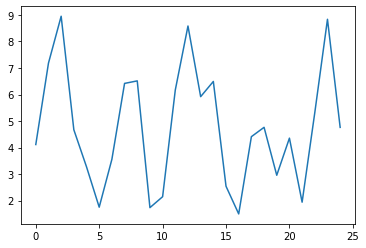

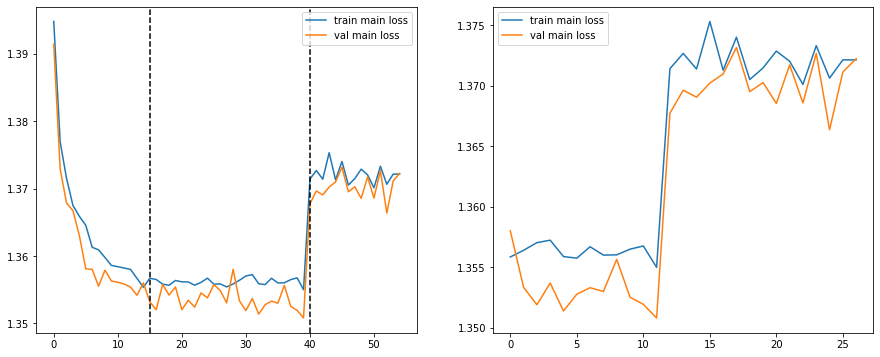

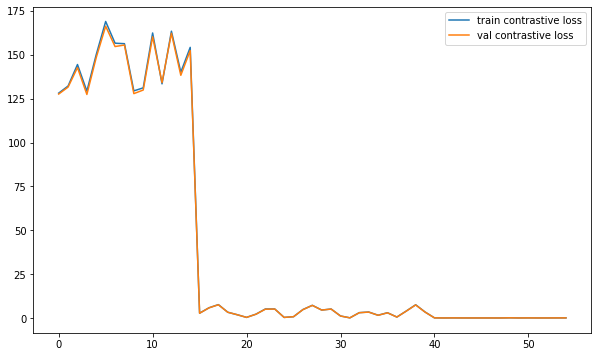

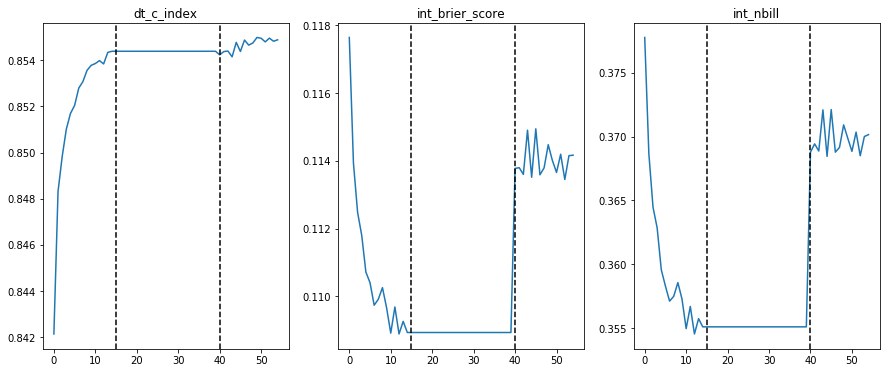

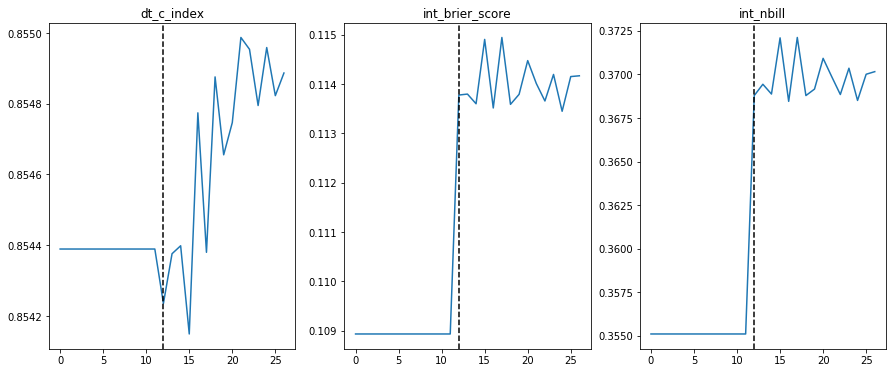

In [10]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [8]:
# 'contrastive_weight': 0.5 -> 0.1
# +
# All optimizers sgd
# 'learning_rate': 0.001,
# 'learning_rate_contr': 0.0005,
# 'learning_rate_both': 0.00005

In [13]:
def initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=None, params_ends='', opt_type='sgd'):
    """ Define GradientDescentOptimizer from config """

    global_step = tf.Variable(0, trainable=False)
    # if exponential decay of learning rate is specified in config
    if ('step_rate' + params_ends not in config.keys()) or (config['step_rate'  + params_ends] == 0) or (
            'decay'  + params_ends not in config.keys()) or (config['decay' + params_ends] == 1):
        learning_rate = config['learning_rate' + params_ends]
    else:
        learning_rate = tf.train.exponential_decay(
            config['learning_rate' + params_ends], global_step, config['step_rate' + params_ends], config['decay' + params_ends], staircase=True)
    if var_list is None:
        var_list = tf.global_variables()
    if opt_type == 'sgd':        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    elif opt_type == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=config['momentum' + params_ends])
        
    if optimize_only_main_loss:
        train_op = optimizer.minimize(model.main_loss, var_list=var_list)
    else:
        train_op = optimizer.minimize(model.loss, var_list=var_list)
        
    return train_op, global_step, optimizer


def run_step(sess, data_gen, model, optimizer, global_step, train_op, n_epochs, train_data, val_data=None):
    
    increment_global_step = tf.assign(global_step, global_step + 1)    
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))
        
        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])

#         print(sess.run(optimizer._learning_rate))
        sess.run(increment_global_step)
#         print(sess.run(optimizer._learning_rate))
        
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val



def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None, optimizers=['sgd', 'sgd', 'sgd'], first_step_load=False):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w, optimizer_w = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=True, var_list=trainable_binary, opt_type=optimizers[0])
    train_op_c, global_step_c, optimizer_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr, params_ends='_contr', opt_type=optimizers[1])
    train_op_w_c, global_step_w_c, optimizer_w_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary, params_ends='_both', opt_type=optimizers[2])
    
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        if first_step_load:
            # Restore variables from disk
            saver = tf.train.import_meta_graph(args['save_path'] + args["model_type"] + "_model" + '.meta')
            saver.restore(sess, args['save_path'] + args["model_type"] + "_model" )
        else:
            # optimize main loss
            (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
                sess, data_gen, model, optimizer_w, global_step_w, train_op_w, config['n_epochs'], train_data, val_data=val_data)
            hist_losses_train.extend(step_hist_losses_train)
            hist_losses_val.extend(step_hist_losses_val)
            hist_losses_main_train.extend(step_hist_losses_main_train)
            hist_losses_main_val.extend(step_hist_losses_main_val)
            all_pred_train.extend(step_all_pred_train)
            all_pred_val.extend(step_all_pred_val)
            print("val loss after step 1: ", hist_losses_val)
            print("val main loss after step 1: ", hist_losses_main_val)


            # save model
            if args['verbose'] == 1:
                print("Save model...")
            saver = tf.train.Saver()
            if args['save_model']:
                saver.save(sess, args['save_path'] + args["model_type"] + "_model")
            
            
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_c, global_step_c, train_op_c, config['n_epochs_contr'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        plt.plot(step_hist_losses_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_w_c, global_step_w_c, train_op_w_c, config['n_epochs_both'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        

    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val


def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(n_epochs[0], c='black', linestyle='--')
    ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0], c='black', linestyle='--')
    ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
    ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();


In [14]:
# 'contrastive_weight': 0.5 -> 0.1

args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 25,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.7,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.7
}

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [4.1273065, 3.1126294, 4.180912, 1.4843194, 3.242935, 6.3969855, 2.9882903, 2.9432585, 6.8542447, 3.528887, 4.8702683, 5.3094797, 1.5917492, 2.1996033, 5.986239, 2.9863214, 2.309842, 3.2028224, 4.271626, 1.9603645, 4.8286138, 5.0197687, 1.8679391, 5.252898, 1.7859274]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3542125, 1.3548096, 1.354541, 1.3544273, 1.356588, 1.3538022, 1.352668, 1.3563583, 1.3547405, 1.3560172, 1.3526237, 1.3539642, 1.3530655, 1.3551388, 1.3544229]


100%|██████████| 15/15 [2:37:38<00:00, 630.59s/it] 


val loss after step 3:  [4.1273065, 3.1126294, 4.180912, 1.4843194, 3.242935, 6.3969855, 2.9882903, 2.9432585, 6.8542447, 3.528887, 4.8702683, 5.3094797, 1.5917492, 2.1996033, 5.986239, 2.9863214, 2.309842, 3.2028224, 4.271626, 1.9603645, 4.8286138, 5.0197687, 1.8679391, 5.252898, 1.7859274, 1.5028001, 1.5153227, 1.446908, 1.460854, 1.4445249, 1.4906553, 1.4500713, 1.4871466, 1.5075439, 1.4820323, 1.4397068, 1.5040929, 1.4391367, 1.4326242, 1.4823084]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3542125, 1.3548096, 1.354541, 1.3544273, 1.356588, 1.3538022, 1.352668, 1.3563583, 1.3547405, 1.3560172, 1.3526237, 1.3539642, 1.3530655, 1.3551388, 1.3544229, 1.3706663, 1.3693635, 1.3678236, 1.3728621, 1.367894, 1.3671813, 1.368072, 1.3660374, 1.3673801, 1.3674617, 1.3676193, 1.3695807, 1.3662251, 1.3663695, 1.3656192]


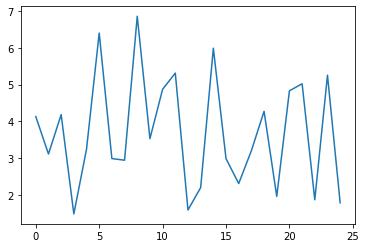

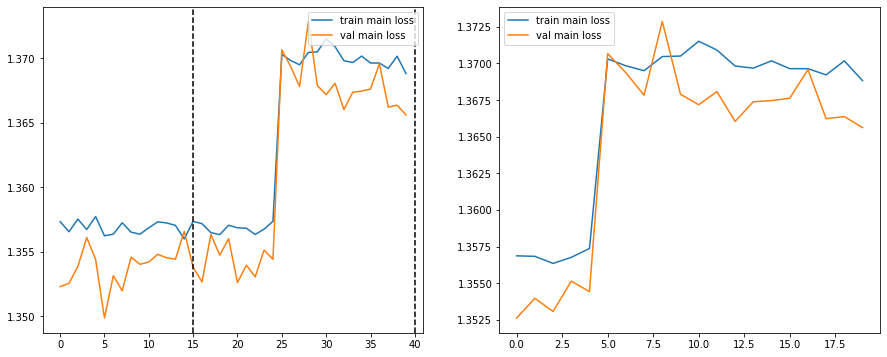

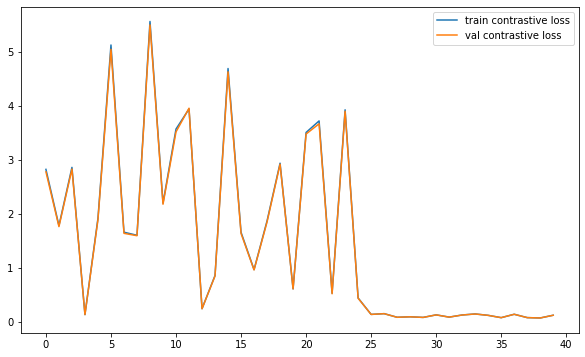

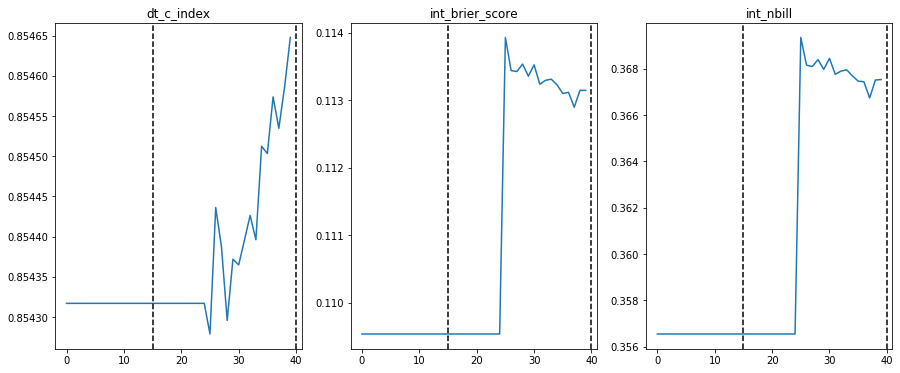

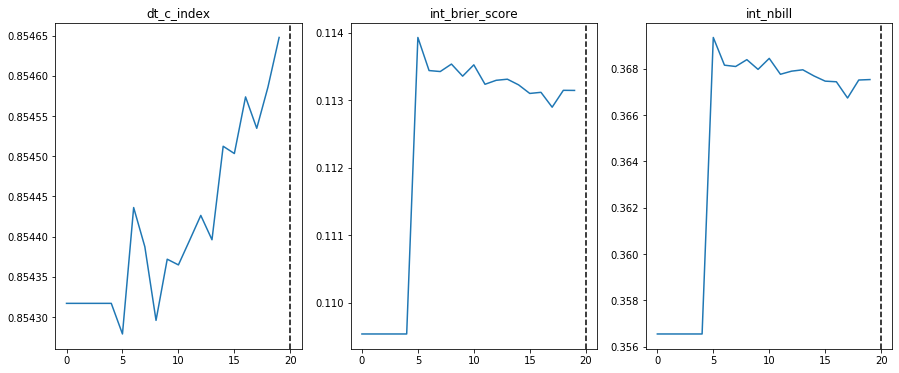

In [15]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'sgd', 'sgd'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [16]:
# 'contrastive_weight': 0.5 -> 0.1
# +
# last optimizer momentum with momentum 0.9

In [17]:
def initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=None, params_ends='', opt_type='sgd'):
    """ Define GradientDescentOptimizer from config """

    global_step = tf.Variable(0, trainable=False)
    # if exponential decay of learning rate is specified in config
    if ('step_rate' + params_ends not in config.keys()) or (config['step_rate'  + params_ends] == 0) or (
            'decay'  + params_ends not in config.keys()) or (config['decay' + params_ends] == 1):
        learning_rate = config['learning_rate' + params_ends]
    else:
        learning_rate = tf.train.exponential_decay(
            config['learning_rate' + params_ends], global_step, config['step_rate' + params_ends], config['decay' + params_ends], staircase=True)
    if var_list is None:
        var_list = tf.global_variables()
    if opt_type == 'sgd':        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    elif opt_type == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=config['momentum' + params_ends])
        
    if optimize_only_main_loss:
        train_op = optimizer.minimize(model.main_loss, var_list=var_list)
    else:
        train_op = optimizer.minimize(model.loss, var_list=var_list)
        
    return train_op, global_step, optimizer


def run_step(sess, data_gen, model, optimizer, global_step, train_op, n_epochs, train_data, val_data=None):
    
    increment_global_step = tf.assign(global_step, global_step + 1)    
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))
        
        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])

#         print(sess.run(optimizer._learning_rate))
        sess.run(increment_global_step)
#         print(sess.run(optimizer._learning_rate))
        
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val



def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None, optimizers=['sgd', 'sgd', 'sgd'], first_step_load=False):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w, optimizer_w = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=True, var_list=trainable_binary, opt_type=optimizers[0])
    train_op_c, global_step_c, optimizer_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr, params_ends='_contr', opt_type=optimizers[1])
    train_op_w_c, global_step_w_c, optimizer_w_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary, params_ends='_both', opt_type=optimizers[2])
    
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        if first_step_load:
            # Restore variables from disk
            saver = tf.train.import_meta_graph(args['save_path'] + args["model_type"] + "_model" + '.meta')
            saver.restore(sess, args['save_path'] + args["model_type"] + "_model" )
        else:
            # optimize main loss
            (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
                sess, data_gen, model, optimizer_w, global_step_w, train_op_w, config['n_epochs'], train_data, val_data=val_data)
            hist_losses_train.extend(step_hist_losses_train)
            hist_losses_val.extend(step_hist_losses_val)
            hist_losses_main_train.extend(step_hist_losses_main_train)
            hist_losses_main_val.extend(step_hist_losses_main_val)
            all_pred_train.extend(step_all_pred_train)
            all_pred_val.extend(step_all_pred_val)
            print("val loss after step 1: ", hist_losses_val)
            print("val main loss after step 1: ", hist_losses_main_val)


            # save model
            if args['verbose'] == 1:
                print("Save model...")
            saver = tf.train.Saver()
            if args['save_model']:
                saver.save(sess, args['save_path'] + args["model_type"] + "_model")
            
            
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_c, global_step_c, train_op_c, config['n_epochs_contr'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        plt.plot(step_hist_losses_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_w_c, global_step_w_c, train_op_w_c, config['n_epochs_both'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        

    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val


def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(n_epochs[0], c='black', linestyle='--')
    ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0], c='black', linestyle='--')
    ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
    ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();


In [18]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 25,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.7,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [4.1273065, 3.1126294, 4.180912, 1.4843194, 3.242935, 6.3969855, 2.9882903, 2.9432585, 6.8542447, 3.528887, 4.8702683, 5.3094797, 1.5917492, 2.1996033, 5.986239, 2.9863214, 2.309842, 3.2028224, 4.271626, 1.9603645, 4.8286138, 5.0197687, 1.8679391, 5.252898, 1.7859274]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3542125, 1.3548096, 1.354541, 1.3544273, 1.356588, 1.3538022, 1.352668, 1.3563583, 1.3547405, 1.3560172, 1.3526237, 1.3539642, 1.3530655, 1.3551388, 1.3544229]


100%|██████████| 15/15 [2:38:02<00:00, 632.15s/it] 


val loss after step 3:  [4.1273065, 3.1126294, 4.180912, 1.4843194, 3.242935, 6.3969855, 2.9882903, 2.9432585, 6.8542447, 3.528887, 4.8702683, 5.3094797, 1.5917492, 2.1996033, 5.986239, 2.9863214, 2.309842, 3.2028224, 4.271626, 1.9603645, 4.8286138, 5.0197687, 1.8679391, 5.252898, 1.7859274, 1.49406, 1.5377505, 1.4711158, 1.5482774, 1.6532816, 1.4873216, 1.6210619, 1.5072385, 1.4389986, 1.4645003, 1.5782889, 1.472512, 1.6321329, 1.5120388, 1.4902114]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3542125, 1.3548096, 1.354541, 1.3544273, 1.356588, 1.3538022, 1.352668, 1.3563583, 1.3547405, 1.3560172, 1.3526237, 1.3539642, 1.3530655, 1.3551388, 1.3544229, 1.3806342, 1.3920009, 1.3842967, 1.379957, 1.3855386, 1.3806478, 1.3795553, 1.3717895, 1.3703396, 1.3838478, 1.381793, 1.371913, 1.3888104, 1.3742713, 1.372307]


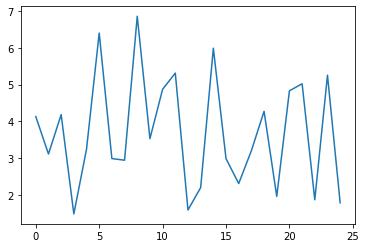

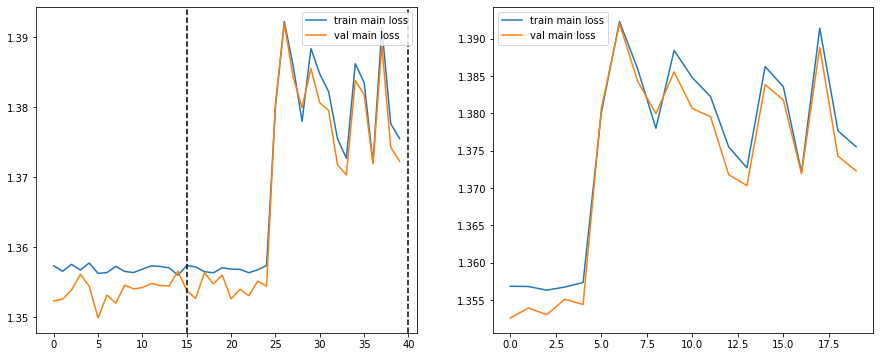

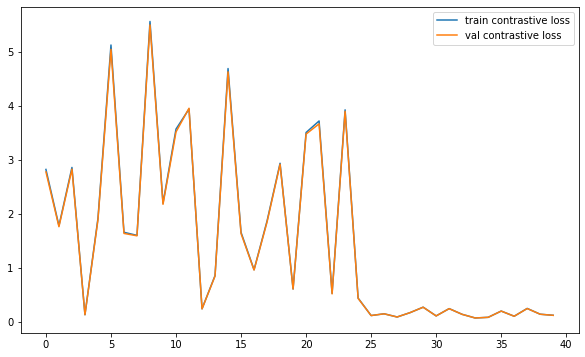

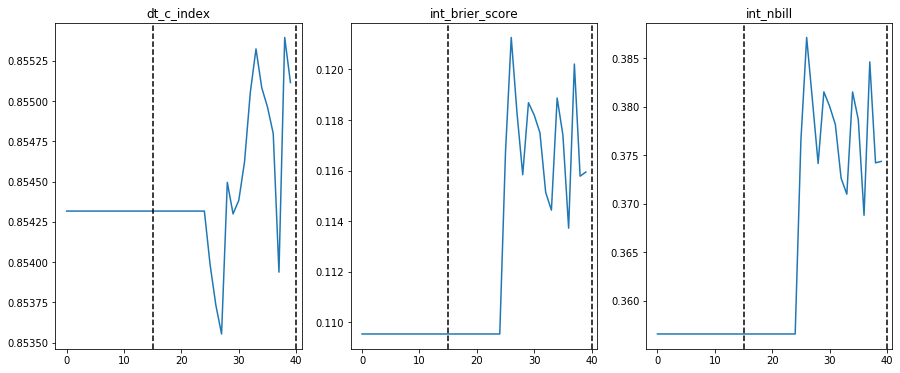

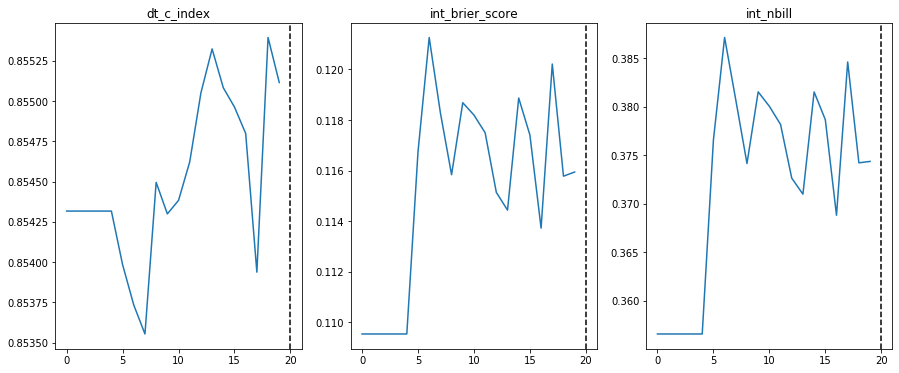

In [19]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'sgd', 'momentum'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [20]:
# n_epochs_contr: 25 -> 5
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 5,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.7,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [4.1273065, 3.1126294, 4.180912, 1.4843194, 3.242935]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207]


100%|██████████| 15/15 [2:38:31<00:00, 634.08s/it] 


val loss after step 3:  [4.1273065, 3.1126294, 4.180912, 1.4843194, 3.242935, 1.5537841, 1.4791826, 1.5198272, 1.5078255, 1.4661531, 1.5422056, 1.4920744, 1.4441804, 1.4475982, 1.5380516, 1.549083, 1.4837791, 1.4838338, 1.4795768, 1.495688]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3706046, 1.3817786, 1.3868386, 1.3769255, 1.3813187, 1.3810004, 1.3839545, 1.3760728, 1.375098, 1.4013692, 1.3921758, 1.4030157, 1.3757887, 1.3735042, 1.3733209]


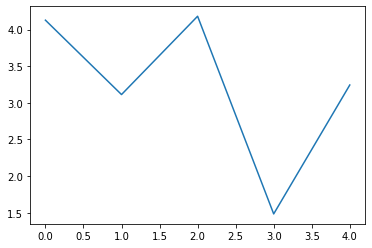

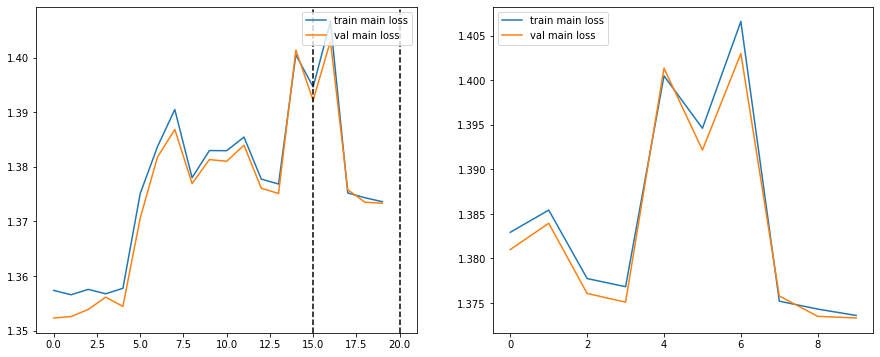

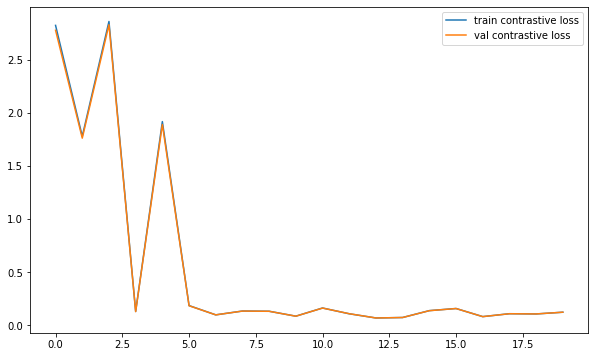

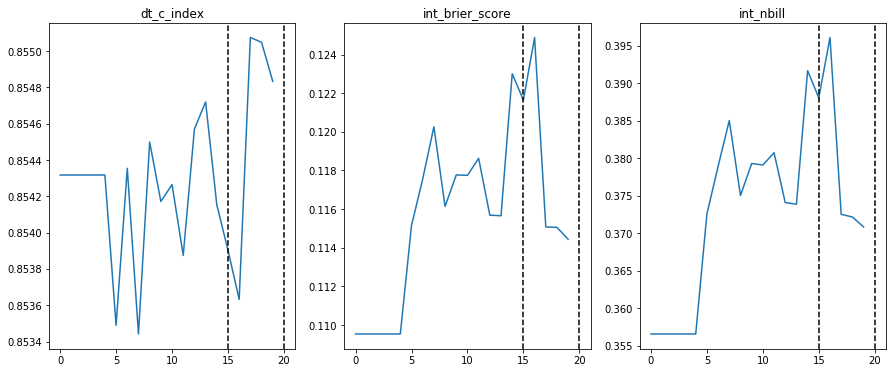

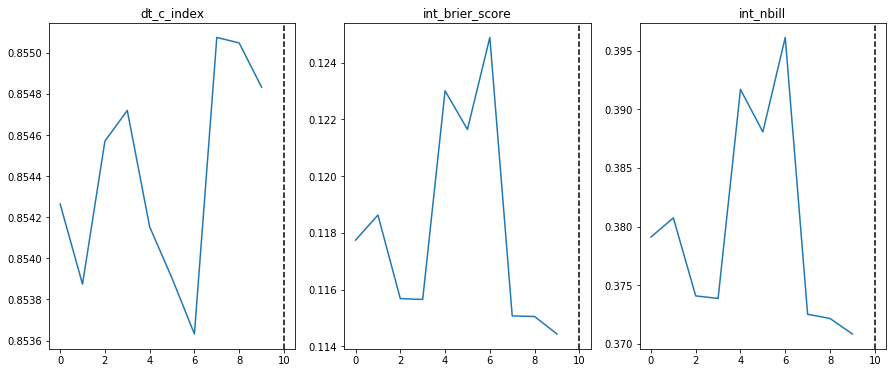

In [21]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'sgd', 'momentum'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [22]:
# 'contrastive_weight': 0.5 -> 0.1
# last optimizer momentum with momentum 0.9
# +
# middle optimizer momentum with momentum 0.9

In [24]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [1.5757284, 1.9486383, 5.1862307, 2.451325, 2.9483998, 19.412525, 11.97369, 10.281915, 16.63472, 6.2899055]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 15/15 [2:37:59<00:00, 631.95s/it] 


val loss after step 3:  [1.5757284, 1.9486383, 5.1862307, 2.451325, 2.9483998, 19.412525, 11.97369, 10.281915, 16.63472, 6.2899055, 1.5487274, 1.4553506, 1.4960856, 1.5684174, 1.4815966, 1.4456183, 1.4613783, 1.4997487, 1.4618146, 1.5456562, 1.4702961, 1.5052985, 1.493997, 1.5587528, 1.4908243]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3880957, 1.3735766, 1.3772749, 1.3801465, 1.3843986, 1.3816104, 1.3846921, 1.3737174, 1.375643, 1.3746943, 1.3696882, 1.3836538, 1.3741349, 1.3799328, 1.3777537]


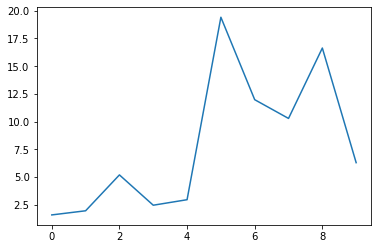

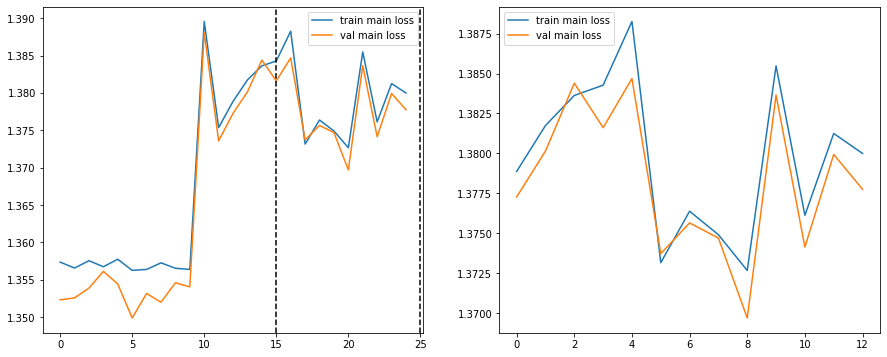

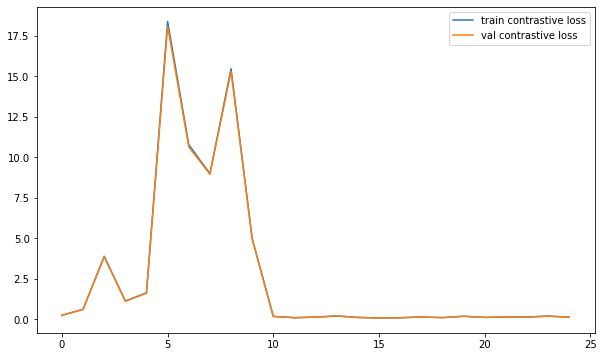

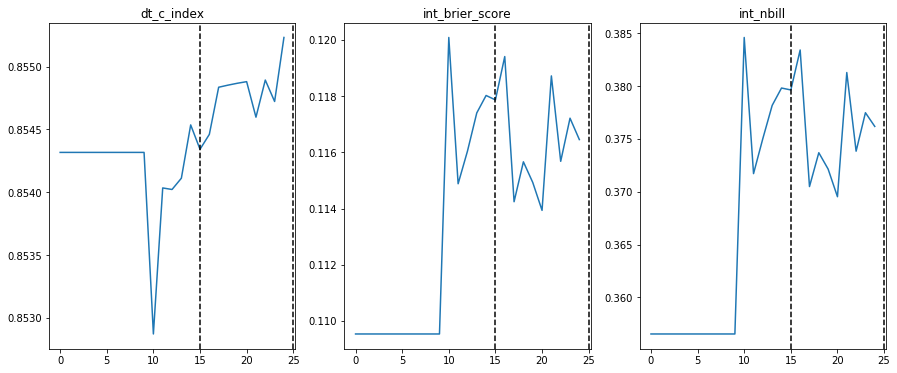

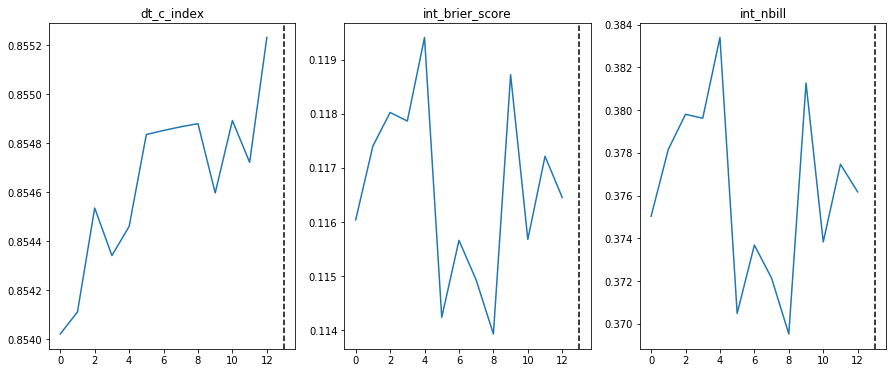

In [25]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'momentum', 'momentum'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [26]:
# 'contrastive_weight': 0.5 -> 0.1
# last optimizer momentum with momentum 0.9
# +
# middle optimizer momentum with momentum 0.9
# n_ex_bin 30 -> 100

In [27]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 100,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [10.776786, 10.794952, 14.905236, 2.191629, 4.7054296, 11.932105, 10.348628, 37.87327, 11.003524, 2.913169]
val main loss after step 2:  [1.3545496, 1.3520507, 1.3531299, 1.3552306, 1.3543689, 1.3555431, 1.3532156, 1.3491826, 1.3524588, 1.3536112]


100%|██████████| 15/15 [49:10<00:00, 196.71s/it]


val loss after step 3:  [10.776786, 10.794952, 14.905236, 2.191629, 4.7054296, 11.932105, 10.348628, 37.87327, 11.003524, 2.913169, 1.5396175, 1.5294749, 1.4482958, 1.447525, 1.582913, 1.5539043, 1.5394629, 1.4469624, 1.4674511, 1.4682584, 1.4521111, 1.4888717, 1.525156, 1.5007825, 1.4929299]
val main loss after step 3:  [1.3545496, 1.3520507, 1.3531299, 1.3552306, 1.3543689, 1.3555431, 1.3532156, 1.3491826, 1.3524588, 1.3536112, 1.3819493, 1.3929684, 1.3785703, 1.3839817, 1.39638, 1.4006729, 1.39505, 1.383554, 1.3780875, 1.3850651, 1.3748308, 1.3808346, 1.3865592, 1.3820508, 1.3802013]


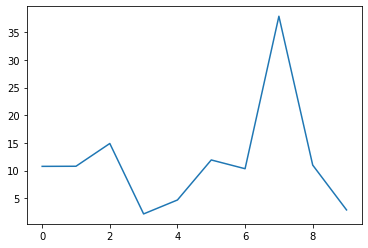

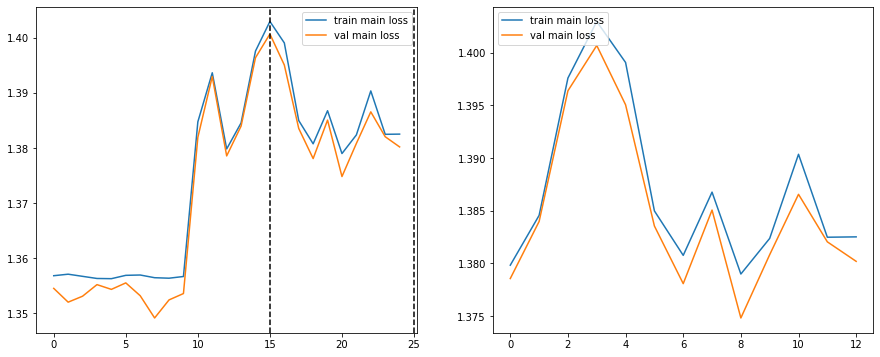

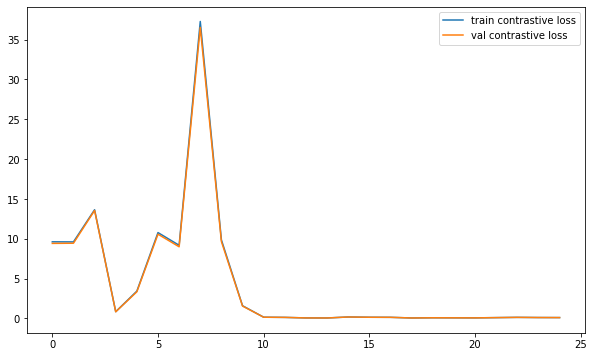

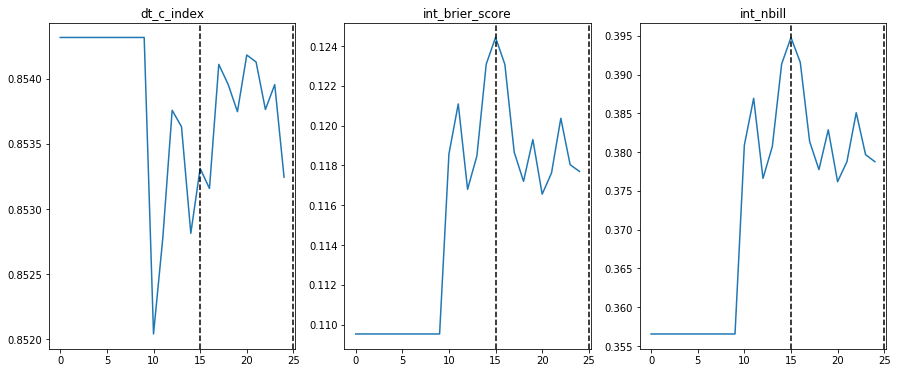

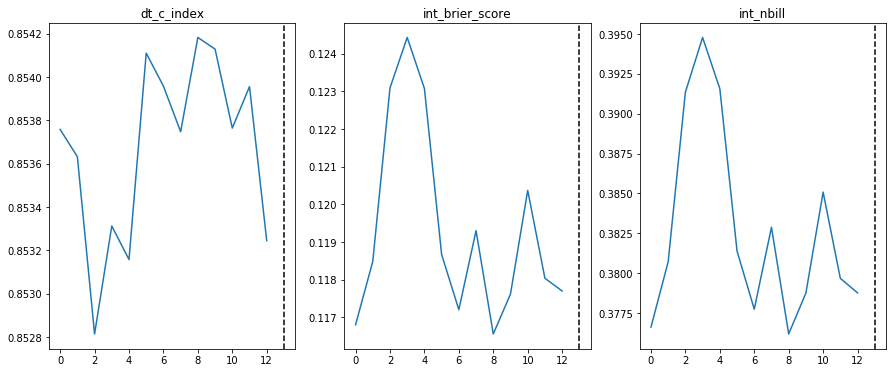

In [28]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'momentum', 'momentum'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [ ]:
# больше эпох для contr
# adam для 2го и/или 3го

In [22]:
# 'contrastive_weight': 0.5 -> 0.1
# last optimizer momentum with momentum 0.9
# middle optimizer momentum with momentum 0.9
# + n_epochs_contr:10 -> 20

In [29]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 20,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [1.5757284, 1.9486383, 5.1862307, 2.451325, 2.9483998, 19.412525, 11.97369, 10.281915, 16.63472, 6.2899055, 6.796977, 18.139973, 2.8005583, 21.620586, 2.6715078, 2.886152, 1.8313329, 4.173267, 1.418202, 11.482713]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3542125, 1.3548096, 1.354541, 1.3544273, 1.356588, 1.3538022, 1.352668, 1.3563583, 1.3547405, 1.3560172]


100%|██████████| 15/15 [2:37:41<00:00, 630.78s/it] 


val loss after step 3:  [1.5757284, 1.9486383, 5.1862307, 2.451325, 2.9483998, 19.412525, 11.97369, 10.281915, 16.63472, 6.2899055, 6.796977, 18.139973, 2.8005583, 21.620586, 2.6715078, 2.886152, 1.8313329, 4.173267, 1.418202, 11.482713, 1.5552695, 1.4789717, 1.5090019, 1.4680928, 1.4537636, 1.4716634, 1.4520766, 1.5091941, 1.460254, 1.4556766, 1.4953398, 1.498496, 1.5184644, 1.4995316, 1.6352901]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3542125, 1.3548096, 1.354541, 1.3544273, 1.356588, 1.3538022, 1.352668, 1.3563583, 1.3547405, 1.3560172, 1.381863, 1.379553, 1.3802619, 1.3900332, 1.3750216, 1.3935287, 1.3814462, 1.3754861, 1.3812882, 1.3918136, 1.3925065, 1.3838258, 1.3710809, 1.385601, 1.377241]


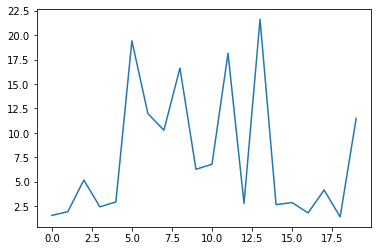

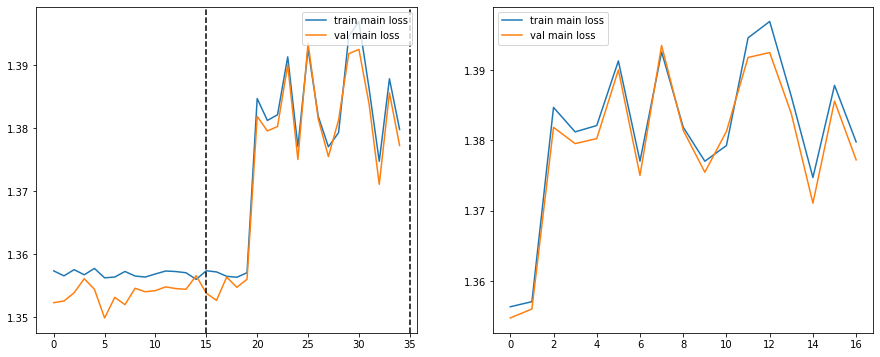

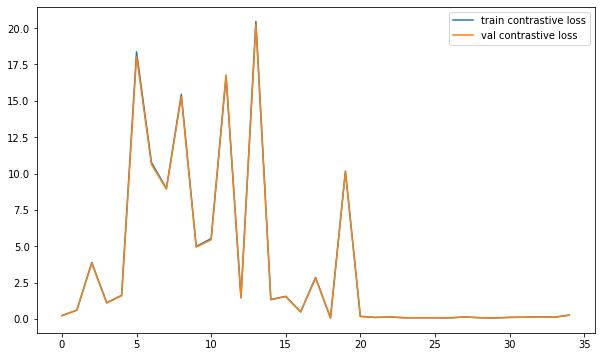

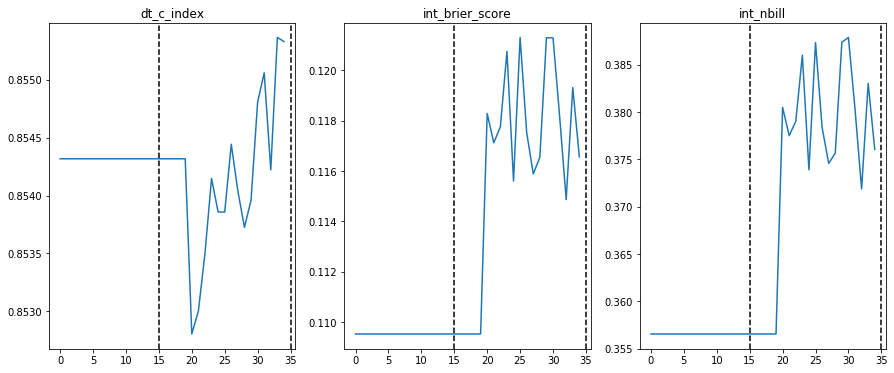

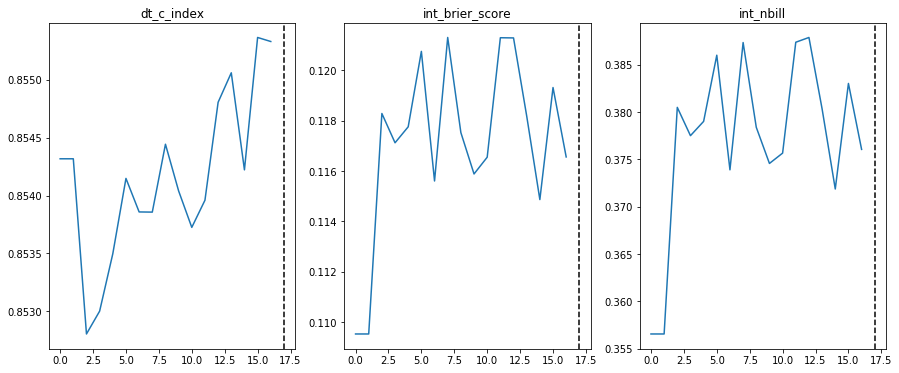

In [30]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'momentum', 'momentum'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [9]:
def initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=None, params_ends='', opt_type='sgd'):
    """ Define GradientDescentOptimizer from config """

    global_step = tf.Variable(0, trainable=False)
    # if exponential decay of learning rate is specified in config
    if ('step_rate' + params_ends not in config.keys()) or (config['step_rate'  + params_ends] == 0) or (
            'decay'  + params_ends not in config.keys()) or (config['decay' + params_ends] == 1):
        learning_rate = config['learning_rate' + params_ends]
    else:
        learning_rate = tf.train.exponential_decay(
            config['learning_rate' + params_ends], global_step, config['step_rate' + params_ends], config['decay' + params_ends], staircase=True)
    if var_list is None:
        var_list = tf.global_variables()
    if opt_type == 'sgd':        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    elif opt_type == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=config['momentum' + params_ends])
    if opt_type == 'adam':        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        
    if optimize_only_main_loss:
        train_op = optimizer.minimize(model.main_loss, var_list=var_list)
    else:
        train_op = optimizer.minimize(model.loss, var_list=var_list)
        
    return train_op, global_step, optimizer


def run_step(sess, data_gen, model, optimizer, global_step, train_op, n_epochs, train_data, val_data=None):
    
    increment_global_step = tf.assign(global_step, global_step + 1)    
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))
        
        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])

#         print(sess.run(optimizer._learning_rate))
        sess.run(increment_global_step)
#         print(sess.run(optimizer._learning_rate))
        
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val



def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None, optimizers=['sgd', 'sgd', 'sgd'], first_step_load=False):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w, optimizer_w = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=True, var_list=trainable_binary, opt_type=optimizers[0])
    train_op_c, global_step_c, optimizer_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr, params_ends='_contr', opt_type=optimizers[1])
    train_op_w_c, global_step_w_c, optimizer_w_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary, params_ends='_both', opt_type=optimizers[2])
    
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        if first_step_load:
            # Restore variables from disk
            saver = tf.train.import_meta_graph(args['save_path'] + args["model_type"] + "_model" + '.meta')
            saver.restore(sess, args['save_path'] + args["model_type"] + "_model" )
        else:
            # optimize main loss
            (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
                sess, data_gen, model, optimizer_w, global_step_w, train_op_w, config['n_epochs'], train_data, val_data=val_data)
            hist_losses_train.extend(step_hist_losses_train)
            hist_losses_val.extend(step_hist_losses_val)
            hist_losses_main_train.extend(step_hist_losses_main_train)
            hist_losses_main_val.extend(step_hist_losses_main_val)
            all_pred_train.extend(step_all_pred_train)
            all_pred_val.extend(step_all_pred_val)
            print("val loss after step 1: ", hist_losses_val)
            print("val main loss after step 1: ", hist_losses_main_val)


            # save model
            if args['verbose'] == 1:
                print("Save model...")
            saver = tf.train.Saver()
            if args['save_model']:
                saver.save(sess, args['save_path'] + args["model_type"] + "_model")
            
            
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_c, global_step_c, train_op_c, config['n_epochs_contr'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        plt.plot(step_hist_losses_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_w_c, global_step_w_c, train_op_w_c, config['n_epochs_both'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        

    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val


def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(n_epochs[0], c='black', linestyle='--')
    ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0], c='black', linestyle='--')
    ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
    ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();


In [32]:
# 'contrastive_weight': 0.5 -> 0.1
# - last optimizer momentum with momentum 0.9
# middle optimizer momentum with momentum 0.9
# + adam last optimizer

In [33]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [1.5757284, 1.9486383, 5.1862307, 2.451325, 2.9483998, 19.412525, 11.97369, 10.281915, 16.63472, 6.2899055]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 15/15 [2:39:09<00:00, 636.61s/it] 


val loss after step 3:  [1.5757284, 1.9486383, 5.1862307, 2.451325, 2.9483998, 19.412525, 11.97369, 10.281915, 16.63472, 6.2899055, 1.4176849, 1.4160228, 1.4165217, 1.4142625, 1.4139912, 1.4121146, 1.4121411, 1.4129007, 1.4140078, 1.4122435, 1.4110456, 1.409777, 1.4092553, 1.4114733, 1.4095422]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3543009, 1.3529059, 1.351607, 1.3507766, 1.3516127, 1.3490722, 1.3485053, 1.3501415, 1.3506757, 1.3496579, 1.3462526, 1.3475233, 1.3468692, 1.3486005, 1.3473105]


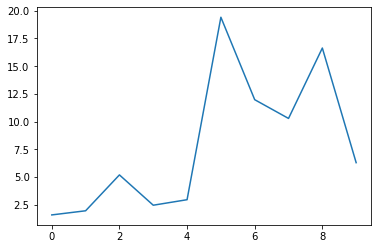

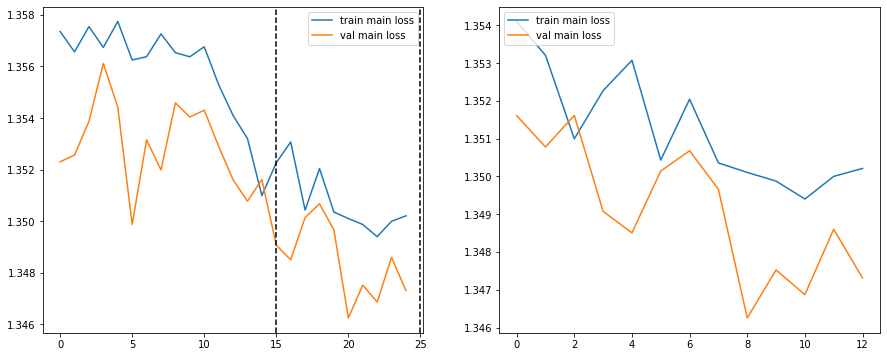

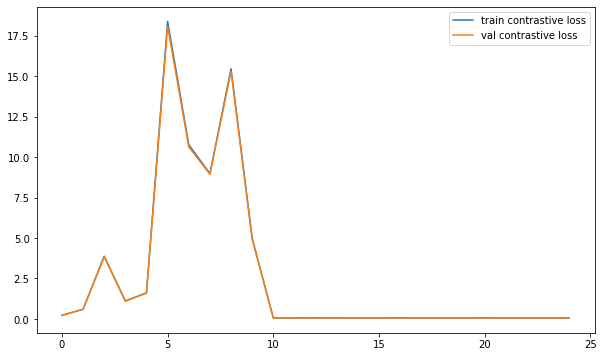

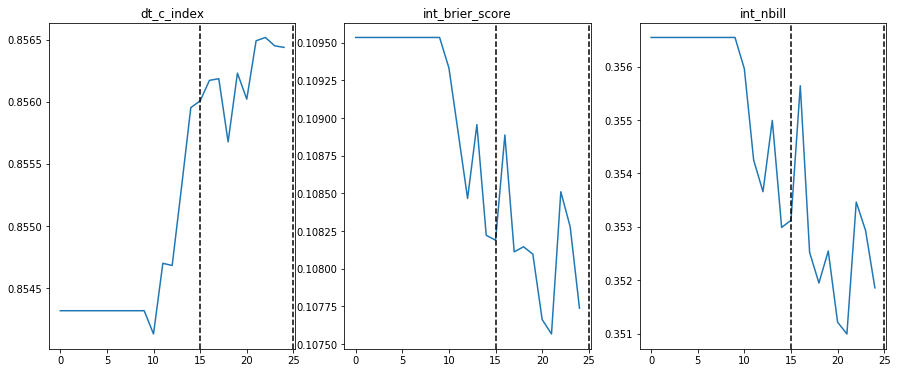

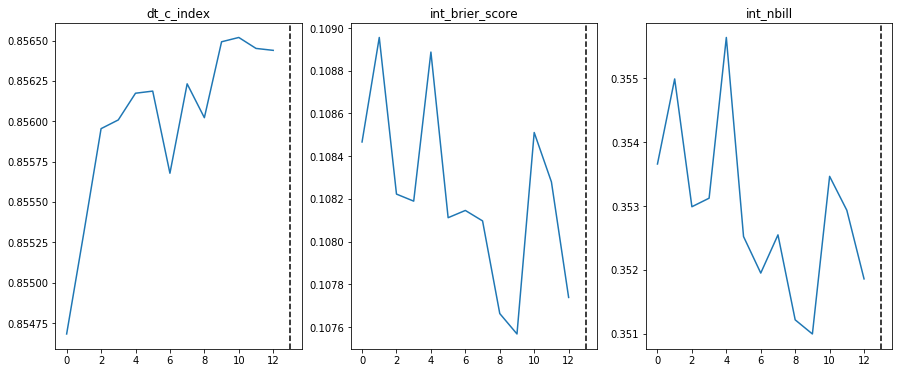

In [34]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'momentum', 'adam'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [22]:
# 'contrastive_weight': 0.5 -> 0.1
# last optimizer momentum with momentum 0.9
# - middle optimizer momentum with momentum 0.9
# + adam middle optimizer

In [35]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 15/15 [2:38:10<00:00, 632.70s/it] 


val loss after step 3:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446, 1.5745982, 1.4636037, 1.4732202, 1.4856167, 1.5319798, 1.4832386, 1.4484113, 1.4808712, 1.4370972, 1.4959931, 1.4707955, 1.448265, 1.4683261, 1.5216432, 1.4428059]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3768691, 1.3743459, 1.3736507, 1.3756862, 1.3790386, 1.3719848, 1.3772616, 1.3813658, 1.3755294, 1.3734972, 1.380754, 1.3762517, 1.3718632, 1.3775355, 1.3787129]


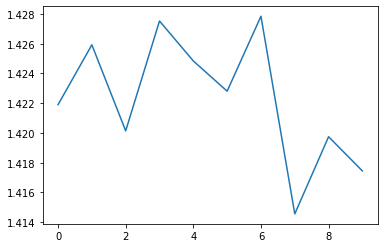

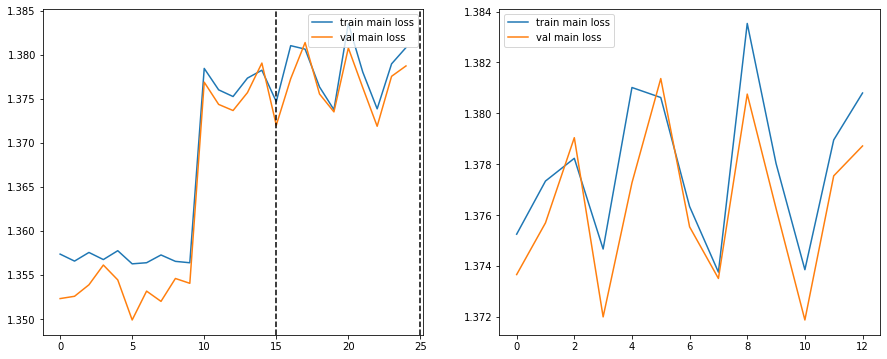

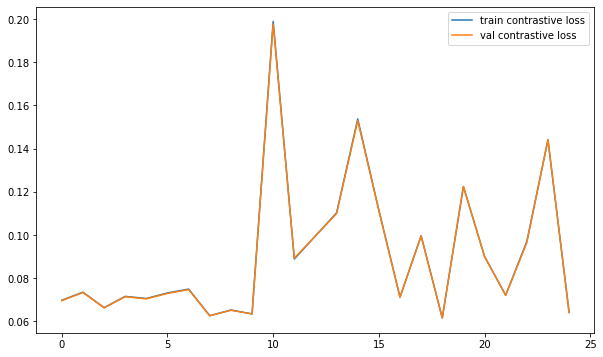

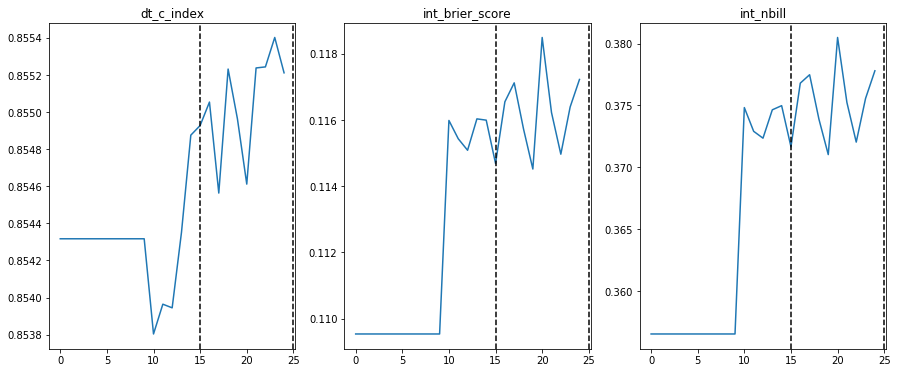

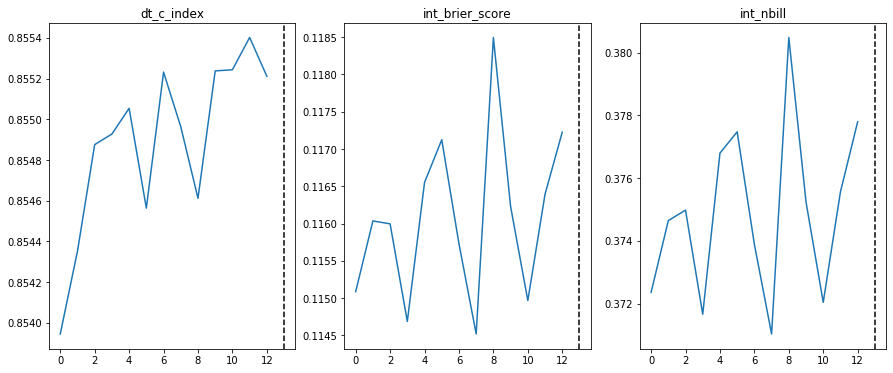

In [36]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'momentum'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [37]:
# 'contrastive_weight': 0.1
# + adam middle optimizer
# + adam last optimizer

In [38]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 15/15 [2:39:14<00:00, 636.97s/it] 


val loss after step 3:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446, 1.4158899, 1.41627, 1.4134406, 1.4129013, 1.413931, 1.4109838, 1.4114488, 1.4116904, 1.4137911, 1.4115589, 1.408154, 1.4110092, 1.4081999, 1.4111216, 1.4099545]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3529601, 1.3519304, 1.3508896, 1.3501267, 1.3512914, 1.3487374, 1.3482987, 1.3497369, 1.3501431, 1.3494587, 1.3458871, 1.3473915, 1.346382, 1.3484004, 1.3470392]


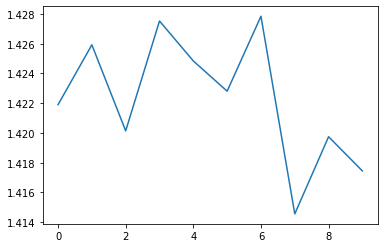

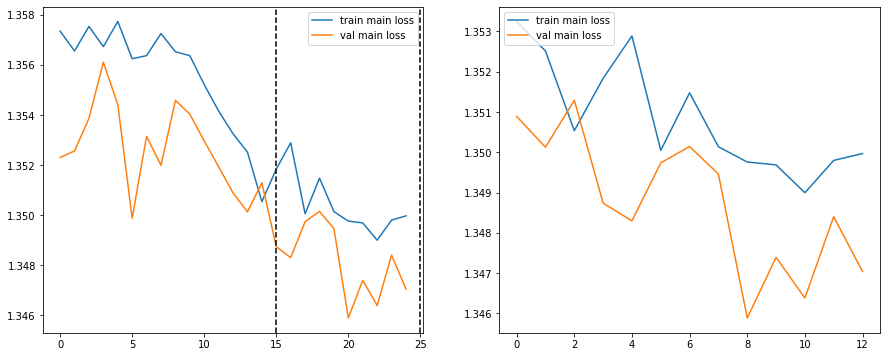

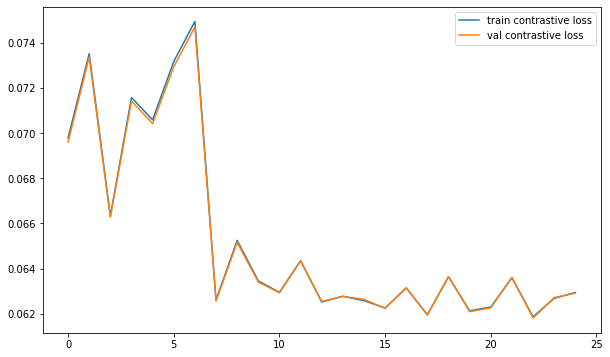

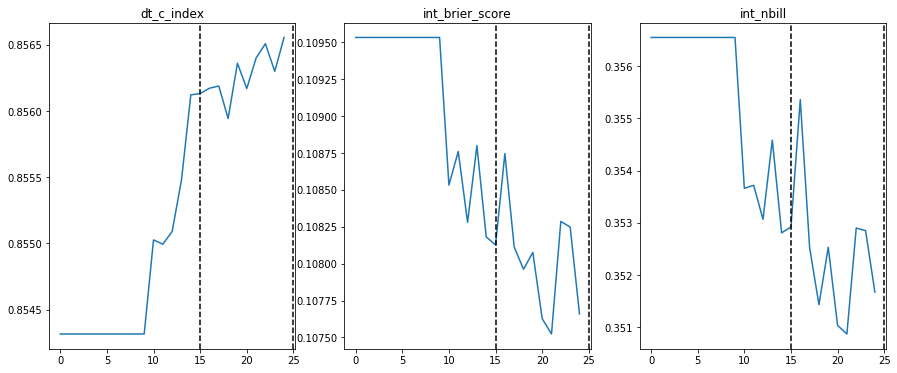

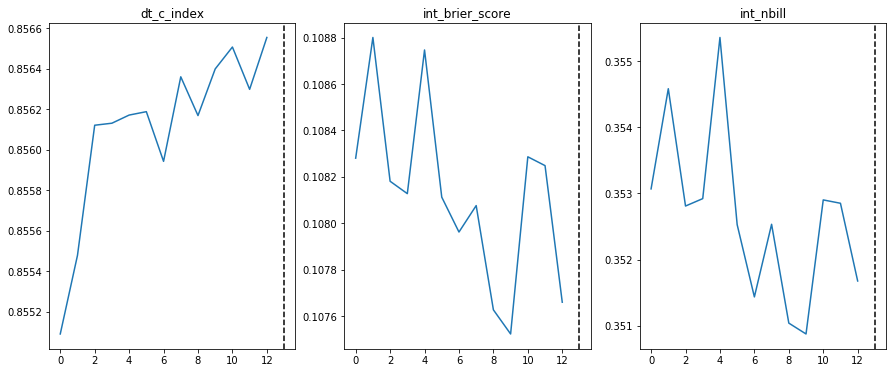

In [39]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'adam'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [ ]:
# увеличивать n_epochs_contr
# увеличивать n_epochs_both
# поизменять learning rate


# прогнать для разных contrastive weight и margin weight

In [37]:
# 'contrastive_weight': 0.1
# adam middle optimizer
# adam last optimizer
#  + n_epochs_contr : 10 -> 20

In [40]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 20,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446, 1.4205658, 1.4229842, 1.4217182, 1.4222903, 1.4277476, 1.4195904, 1.4152472, 1.4182855, 1.4281219, 1.4207069]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3542125, 1.3548096, 1.354541, 1.3544273, 1.356588, 1.3538022, 1.352668, 1.3563583, 1.3547405, 1.3560172]


100%|██████████| 15/15 [2:38:15<00:00, 633.03s/it] 


val loss after step 3:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446, 1.4205658, 1.4229842, 1.4217182, 1.4222903, 1.4277476, 1.4195904, 1.4152472, 1.4182855, 1.4281219, 1.4207069, 1.41253, 1.4128773, 1.4117059, 1.4146338, 1.4115916, 1.4155484, 1.4123923, 1.4099803, 1.4171423, 1.4109827, 1.4084512, 1.4103743, 1.4098752, 1.4084965, 1.4090774]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3542125, 1.3548096, 1.354541, 1.3544273, 1.356588, 1.3538022, 1.352668, 1.3563583, 1.3547405, 1.3560172, 1.3506161, 1.3509737, 1.3496106, 1.3508881, 1.3494083, 1.351021, 1.3495315, 1.3478878, 1.3520378, 1.3476101, 1.3461559, 1.3477238, 1.3451147, 1.346088, 1.3465018]


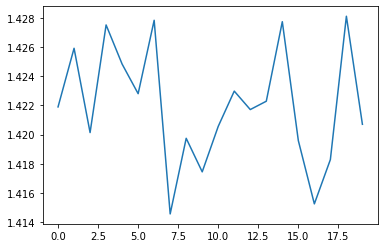

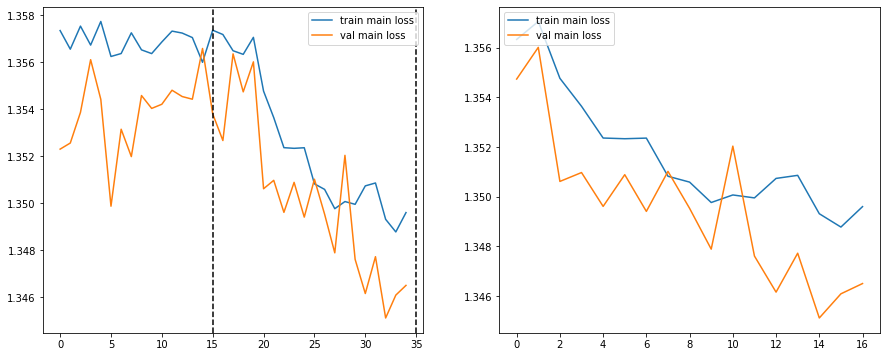

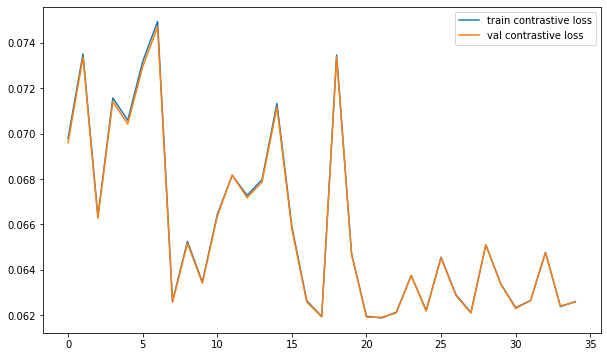

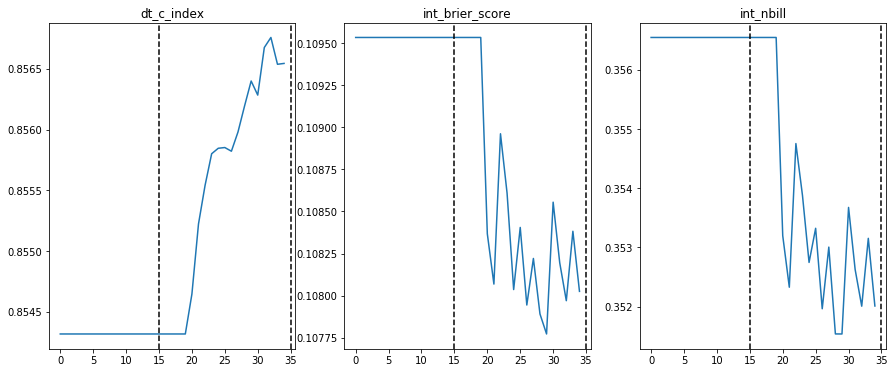

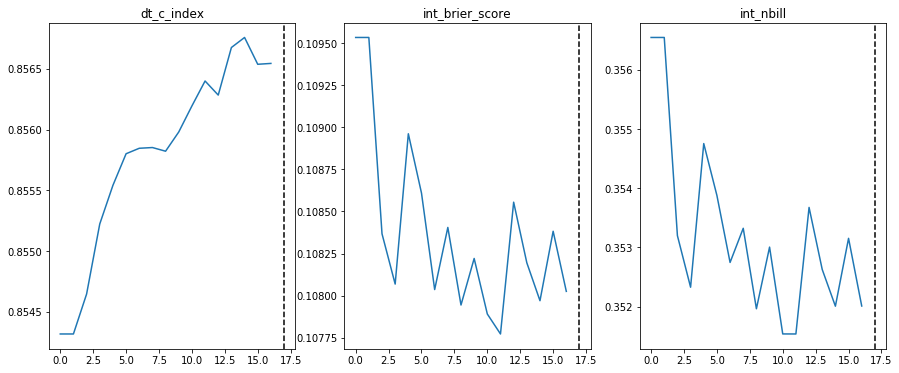

In [41]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'adam'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [42]:
# 'contrastive_weight': 0.1
# adam middle optimizer
# adam last optimizer
# + learning_rate_both': 0.00005 -> 0.0005

In [7]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.0005,
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_both': 0.9
}

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 15/15 [2:38:37<00:00, 634.51s/it] 


val loss after step 3:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446, 1.4239612, 1.4262598, 1.4150094, 1.4124516, 1.4148625, 1.4136298, 1.4087951, 1.4107779, 1.4148284, 1.4122463, 1.411025, 1.4082469, 1.4091986, 1.424544, 1.4080186]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3562052, 1.3514795, 1.3500259, 1.3486215, 1.3519057, 1.3488536, 1.3467138, 1.3488163, 1.3484292, 1.3503789, 1.3457175, 1.3453143, 1.3457714, 1.3496866, 1.3449959]


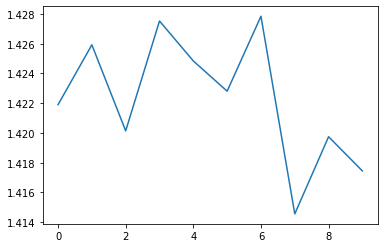

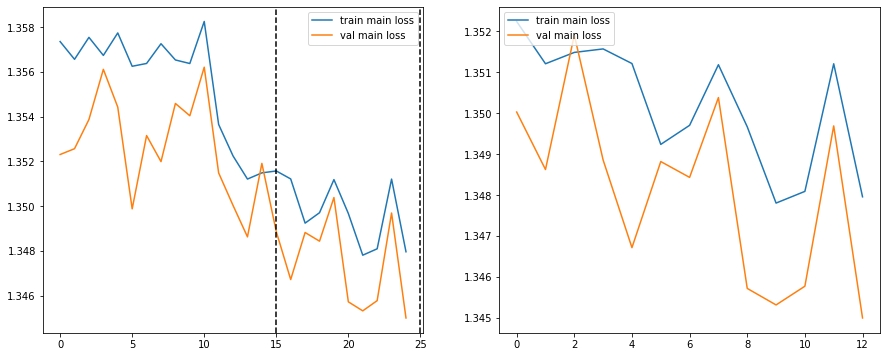

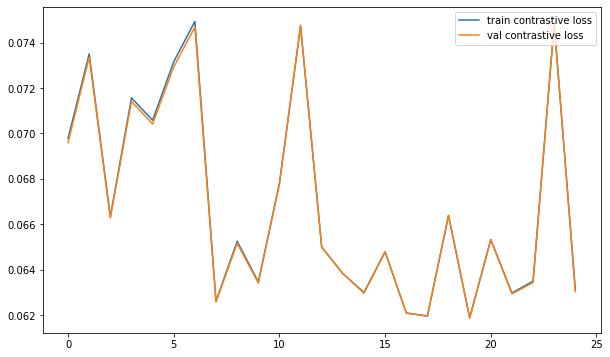

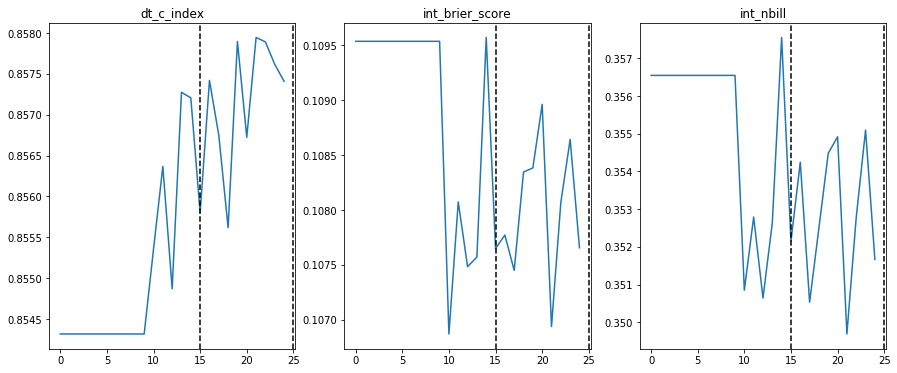

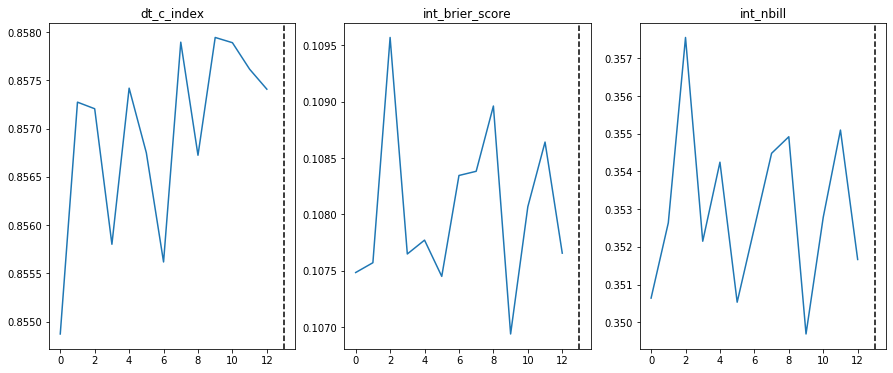

In [10]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'adam'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [14]:
# 'contrastive_weight': 0.1
# adam middle optimizer
# adam last optimizer
# + learning_rate_both': 0.00005 -> 0.00025

In [15]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00025,
    # !!!!!!!!
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    # !!!!!!!!
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 15/15 [2:40:07<00:00, 640.53s/it] 


val loss after step 3:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446, 1.4190105, 1.4135531, 1.419227, 1.4134579, 1.4162636, 1.4096901, 1.4100001, 1.4133729, 1.4139801, 1.4107212, 1.4085966, 1.4089215, 1.4125117, 1.4108407, 1.4105589]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3544421, 1.351646, 1.3485479, 1.3491707, 1.3524573, 1.347551, 1.3481953, 1.3511108, 1.3478479, 1.3486346, 1.3455501, 1.3461493, 1.3452283, 1.3484329, 1.3462372]


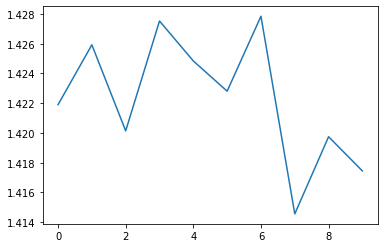

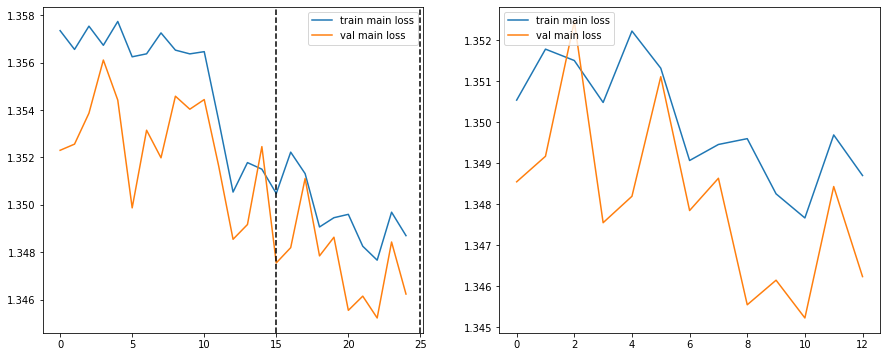

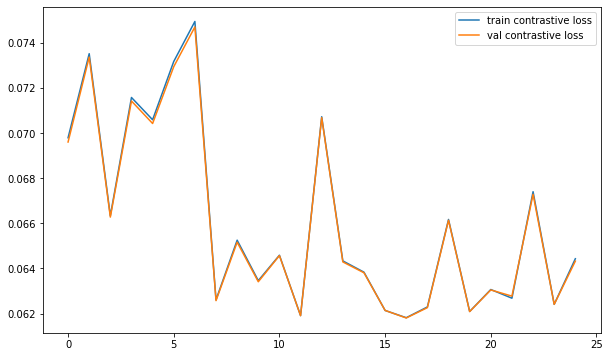

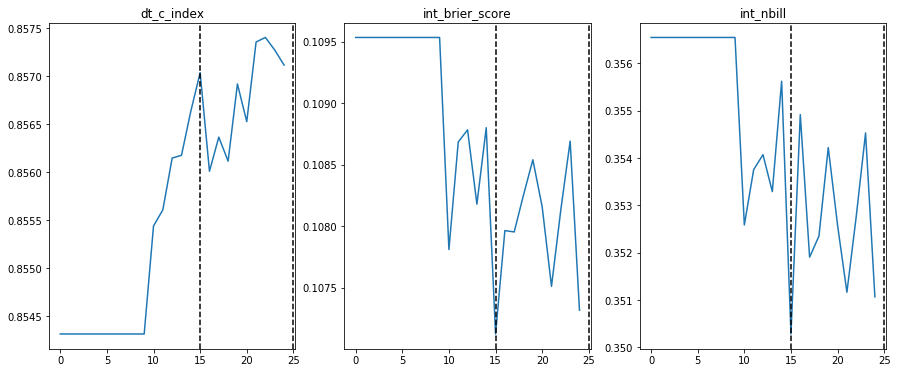

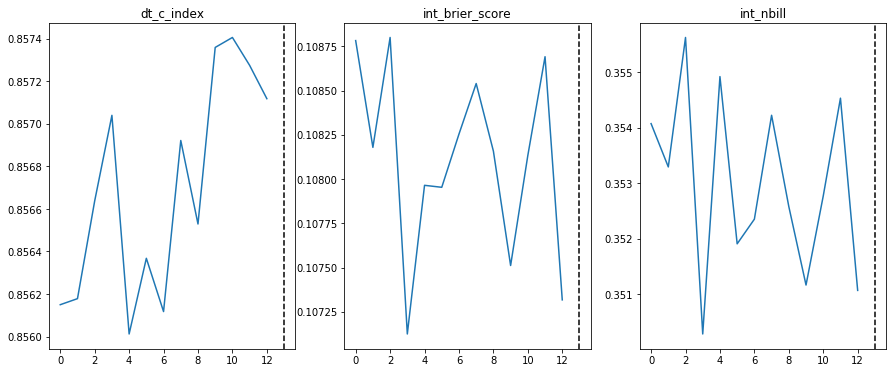

In [16]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'adam'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [14]:
# 'contrastive_weight': 0.1
# adam middle optimizer
# adam last optimizer
# learning_rate_both': 0.00025

# + 
#     'step_rate_both': 5,
#     'decay_both': 0.9,

In [17]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 15,
    'learning_rate_both': 0.00025,
    'step_rate_both': 5,
    'decay_both': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 15/15 [2:38:39<00:00, 634.66s/it] 


val loss after step 3:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446, 1.4239134, 1.4145738, 1.4133893, 1.410786, 1.4131545, 1.4095961, 1.4094077, 1.4161036, 1.4097232, 1.4131787, 1.4062353, 1.4082538, 1.4070004, 1.4104801, 1.4075087]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3539726, 1.3514973, 1.348104, 1.3489989, 1.3504282, 1.3477948, 1.3476909, 1.3495779, 1.3475966, 1.3479044, 1.3443795, 1.3460604, 1.3446996, 1.348067, 1.3457985]


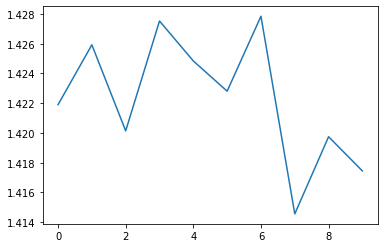

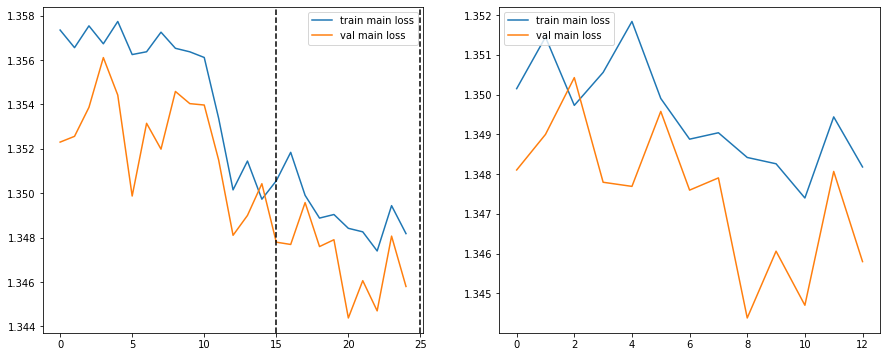

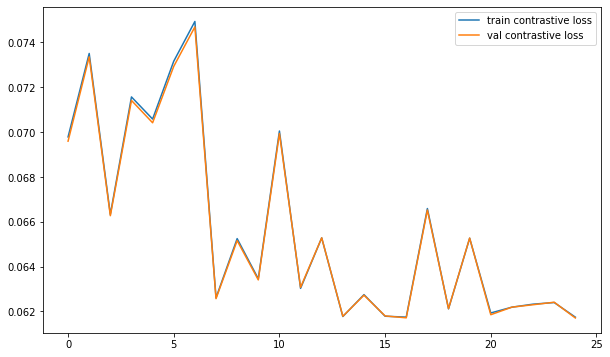

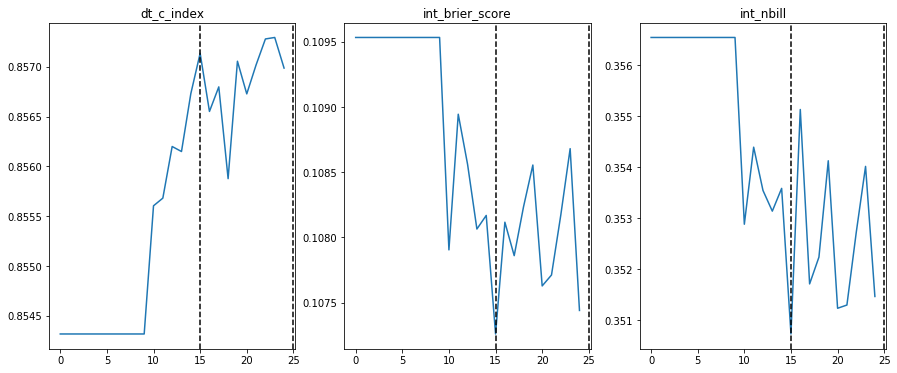

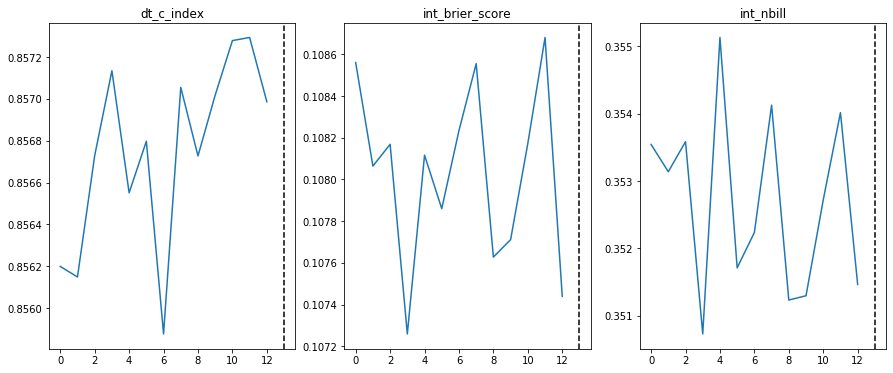

In [18]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'adam'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [46]:
# 'contrastive_weight': 0.1
# adam middle optimizer
# adam last optimizer
# learning_rate_both': 0.00025

# + n_epochs_both - 15 -> 50

In [47]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 50,
    'learning_rate_both': 0.00025,
    'step_rate_both': 15,
    'decay_both': 0.9,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/50 [00:00<?, ?it/s]

val loss after step 2:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 50/50 [8:48:03<00:00, 633.66s/it]  


val loss after step 3:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446, 1.4206206, 1.4137194, 1.4104882, 1.4143039, 1.4125829, 1.410846, 1.4099449, 1.4132965, 1.4171506, 1.4121958, 1.407574, 1.40963, 1.4088895, 1.4132869, 1.4106693, 1.4100866, 1.4181849, 1.4101863, 1.4146018, 1.4082878, 1.4065187, 1.4075117, 1.4046869, 1.4059237, 1.4058484, 1.405671, 1.408623, 1.4046898, 1.4054966, 1.412083, 1.4055808, 1.4066947, 1.406415, 1.4043735, 1.4100652, 1.4059882, 1.4057653, 1.4076788, 1.4030548, 1.4100498, 1.4051276, 1.4088258, 1.4032477, 1.4067994, 1.4076835, 1.4061679, 1.4063637, 1.4098908, 1.4091705, 1.404266]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.354238, 1.3514036, 1.3485004, 1.3494486, 1.3506166, 1.3477066, 1.3480068, 1.3514171, 1.3479373, 1.3488976, 1.345804, 1.3473213, 1.3452886, 1.348961, 1.3456194, 1.3479683, 1.3462441, 1.344217, 

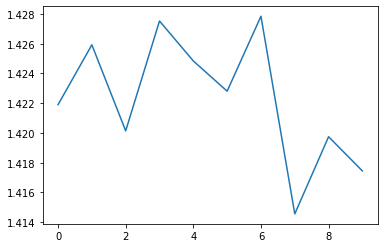

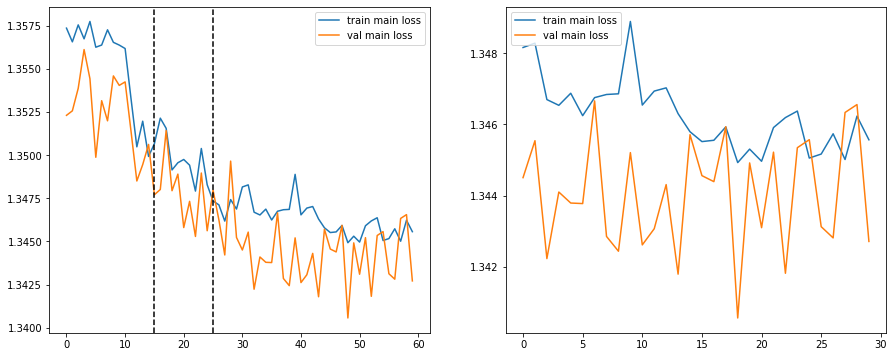

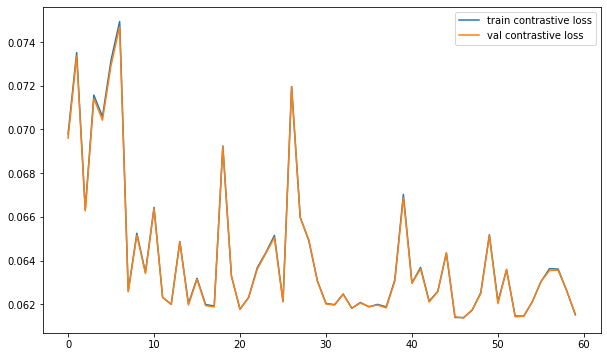

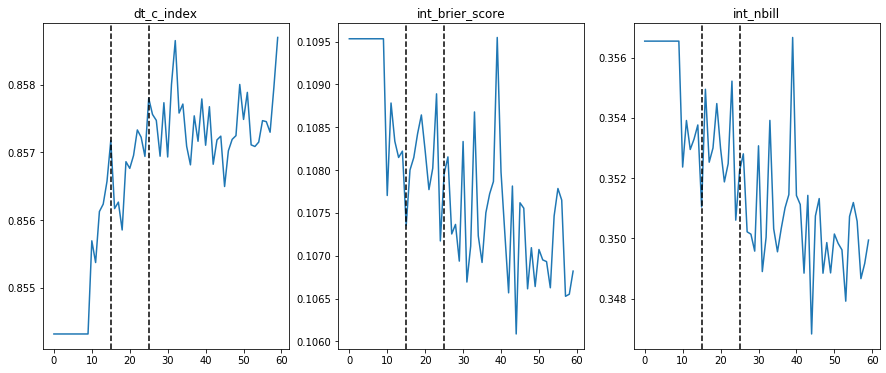

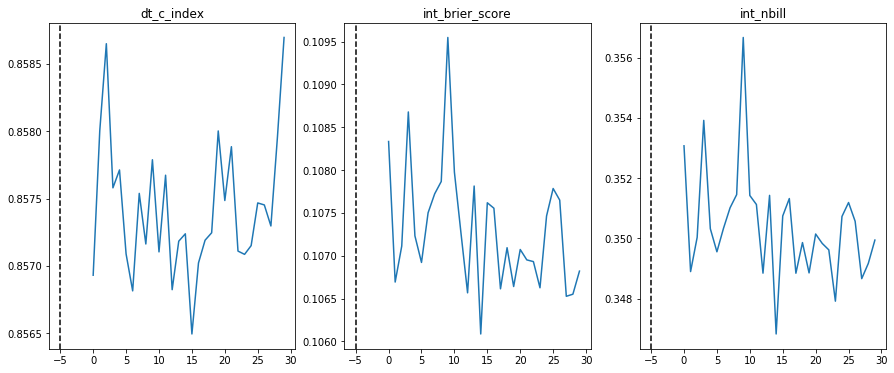

In [48]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'adam'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [49]:
# 'contrastive_weight': 0.1
# adam middle optimizer
# adam last optimizer
# learning_rate_both': 0.00025
# n_epochs_both - 15 -> 50
# + decay_both - 0.9 -> 0.1

In [50]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 50,
    'learning_rate_both': 0.00025,
    'step_rate_both': 15,
    'decay_both': 0.1,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/50 [00:00<?, ?it/s]

val loss after step 2:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 50/50 [8:49:22<00:00, 635.24s/it]  


val loss after step 3:  [1.4219, 1.4259232, 1.42014, 1.4275246, 1.424839, 1.422808, 1.4278445, 1.4145577, 1.4197459, 1.4174446, 1.4172943, 1.4163675, 1.4111353, 1.4155, 1.4131887, 1.4104562, 1.4118074, 1.4144342, 1.4118183, 1.4104941, 1.4084057, 1.4092441, 1.4085319, 1.4119792, 1.408337, 1.4088954, 1.4117013, 1.4074801, 1.4097797, 1.407415, 1.4059299, 1.4063394, 1.403392, 1.404739, 1.4050355, 1.4072468, 1.4106141, 1.4044526, 1.4041721, 1.4045222, 1.4104606, 1.4109519, 1.4112809, 1.4108148, 1.4149858, 1.411444, 1.4451879, 1.4123625, 1.4173366, 1.4250158, 1.4121196, 1.4334868, 1.4076653, 1.4114678, 1.4289619, 1.4679399, 1.4324851, 1.4344736, 1.4238533, 1.4174471]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3543247, 1.3516397, 1.349097, 1.349111, 1.35097, 1.3478422, 1.3481112, 1.3500961, 1.3474602, 1.3489392, 1.3451654, 1.3463649, 1.3453156, 1.3485578, 1.3460994, 1.3460983, 1.3445998, 1.3434317,

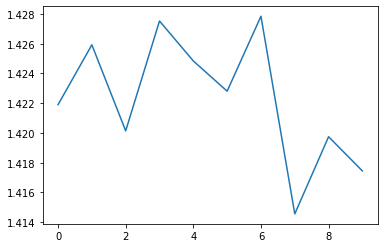

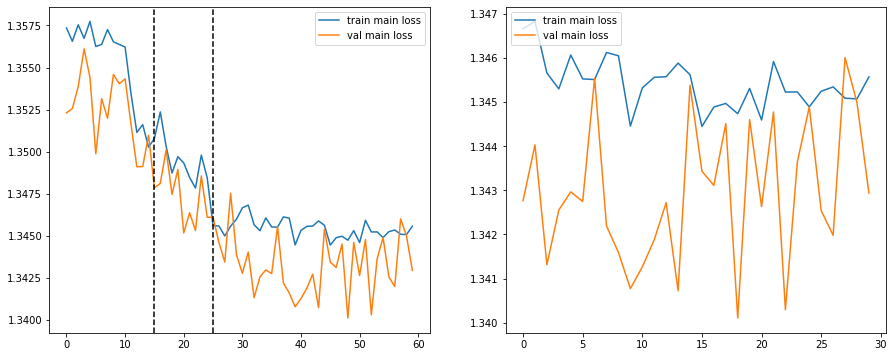

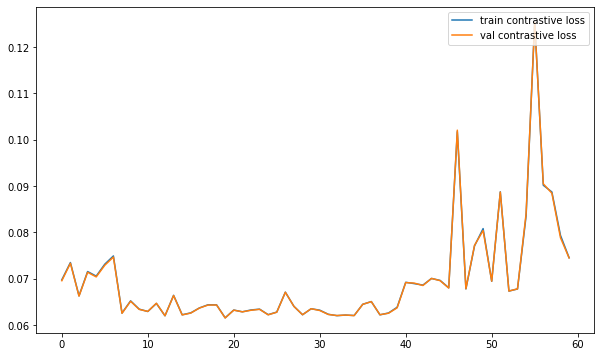

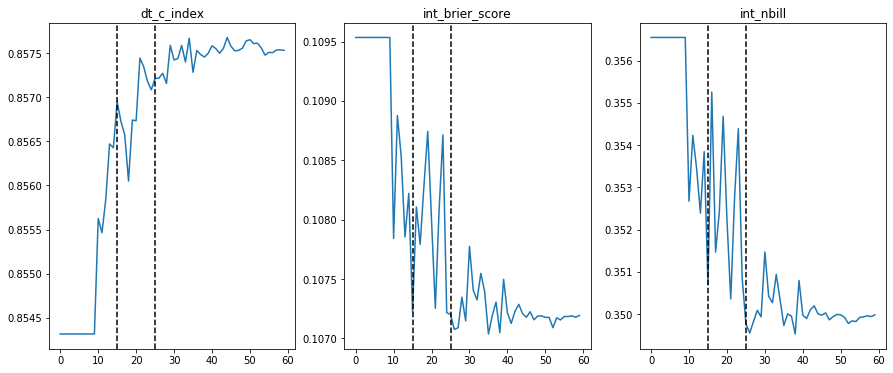

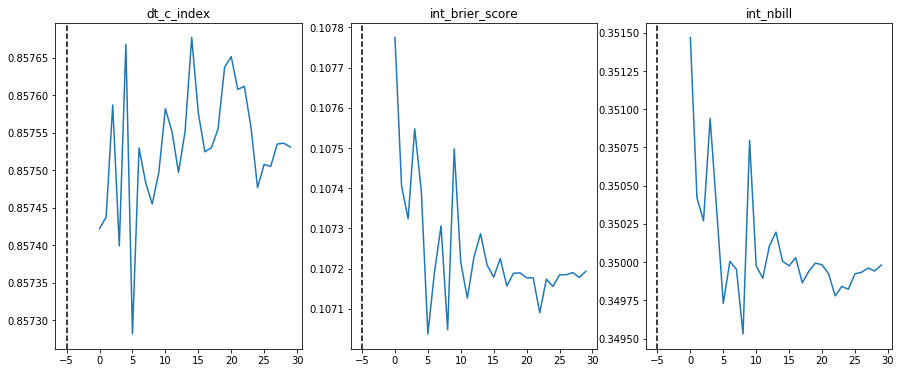

In [51]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])


hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'adam'], first_step_load=True)

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [59]:
df_all_q.reset_index(drop=True, inplace=True)
df_all_q['hist_losses_train'] = hist_losses_train
df_all_q['hist_losses_main_train'] = hist_losses_main_train
df_all_q['hist_losses_val'] = hist_losses_val
df_all_q['hist_losses_main_val'] = hist_losses_main_val
df_all_q['contrastive_weight'] = config['contrastive_weight']
df_all_q['margin_weight'] = config['margin_weight']

In [60]:
df_all_q

dt_c_index  int_brier_score  int_nbill  hist_losses_train  \
0     0.854317         0.109534   0.356547           1.427137   
1     0.854317         0.109534   0.356547           1.430068   
2     0.854317         0.109534   0.356547           1.423871   
3     0.854317         0.109534   0.356547           1.428303   
4     0.854317         0.109534   0.356547           1.428321   
5     0.854317         0.109534   0.356547           1.429411   
6     0.854317         0.109534   0.356547           1.431310   
7     0.854317         0.109534   0.356547           1.419863   
8     0.854317         0.109534   0.356547           1.421779   
9     0.854317         0.109534   0.356547           1.419828   
10    0.855625         0.107842   0.352672           1.419170   
11    0.855465         0.108877   0.354230           1.418148   
12    0.855843         0.108534   0.353446           1.413163   
13    0.856470         0.107854   0.352389           1.418048   
14    0.856427         0.108221   0.353845           1.412514   
15    0.856947         0.107224   0.350709           1.413438   
16    0.856725         0.108107   0.355254           1.416074   
17    0.856572         0.107792   0.351470           1.414706   
18    0.856051         0.108286   0.352427           1.413114   
19    0.856741         0.108743   0.354678           1.411291   
20    0.856733         0.107995   0.352238           1.412594   
21    0.857443         0.107254   0.350360           1.411352   
22    0.857345         0.108083   0.352744           1.411114   
23    0.857181         0.108713   0.354389           1.413247   
24    0.857083         0.107217   0.350869           1.410723   
25    0.857213         0.107202   0.349770           1.408419   
26    0.857215         0.107076   0.349553           1.412702   
27    0.857271         0.107089   0.349827           1.409043   
28    0.857156         0.107347   0.350090           1.407826   
29    0.857588         0.107148   0.349936           1.409528   
30    0.857422         0.107775   0.351470           1.409893   
31    0.857438         0.107406   0.350421           1.409166   
32    0.857587         0.107324   0.350270           1.407711   
33    0.857399         0.107548   0.350941           1.407477   
34    0.857668         0.107394   0.350339           1.408146   
35    0.857282         0.107037   0.349730           1.410027   
36    0.857530         0.107190   0.350005           1.410601   
37    0.857484         0.107306   0.349953           1.408351   
38    0.857455         0.107048   0.349530           1.408676   
39    0.857497         0.107498   0.350797           1.408315   
40    0.857582         0.107215   0.349976           1.414568   
41    0.857552         0.107126   0.349895           1.414522   
42    0.857497         0.107228   0.350105           1.414224   
43    0.857552         0.107287   0.350197           1.415960   
44    0.857677         0.107209   0.350007           1.415273   
45    0.857576         0.107178   0.349975           1.412524   
46    0.857525         0.107225   0.350029           1.446630   
47    0.857530         0.107157   0.349866           1.412796   
48    0.857555         0.107188   0.349940           1.421834   
49    0.857637         0.107189   0.349994           1.426144   
50    0.857651         0.107177   0.349983           1.414059   
51    0.857608         0.107177   0.349923           1.434692   
52    0.857612         0.107090   0.349779           1.412580   
53    0.857558         0.107174   0.349841           1.413041   
54    0.857477         0.107155   0.349823           1.428463   
55    0.857508         0.107184   0.349924           1.470774   
56    0.857505         0.107185   0.349934           1.435533   
57    0.857535         0.107190   0.349962           1.433824   
58    0.857536         0.107178   0.349942           1.424445   
59    0.857531         0.107193   0.349981           1.420129   

    hist_losses_main_train  hist_losse

In [61]:
df_all_q.to_csv('../../output/kkbox_contr_0.csv')

In [ ]:
# hp search for contrastive weight - fix all parameters (config) except contrastive weight (as list) - and save all results (as in metabric notebook)

In [9]:
def train_contrastive(config):
    q = []
    tf.reset_default_graph()

    data_gen, model = initialize_model(
        model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

    hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
        args=args, train_data=data['train'], val_data=data['val'], config=config,
        data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'adam'], first_step_load=True)

    
    for pred in all_pred_val:
        q.append(
            test_quality(
                t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False
            )
        )
    df_all_q = pd.concat(q)
    df_all_q.reset_index(drop=True, inplace=True)
    df_all_q['hist_losses_train'] = hist_losses_train
    df_all_q['hist_losses_main_train'] = hist_losses_main_train
    df_all_q['hist_losses_val'] = hist_losses_val
    df_all_q['hist_losses_main_val'] = hist_losses_main_val

    return df_all_q

In [62]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 50,
    'learning_rate_both': 0.00025,
    'step_rate_both': 15,
    'decay_both': 0.1,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/50 [00:00<?, ?it/s]

val loss after step 2:  [1.7226267, 1.7689538, 1.6793095, 1.731588, 1.684263, 1.6879838, 1.6741903, 1.7111758, 1.6936568, 1.6831927]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 50/50 [8:50:16<00:00, 636.33s/it]  


val loss after step 3:  [1.7226267, 1.7689538, 1.6793095, 1.731588, 1.684263, 1.6879838, 1.6741903, 1.7111758, 1.6936568, 1.6831927, 1.6672242, 1.666506, 1.6636845, 1.6685673, 1.6816221, 1.6616362, 1.6623465, 1.6675481, 1.6684213, 1.6623396, 1.6592782, 1.6596218, 1.6660081, 1.6764175, 1.6595148, 1.6815223, 1.6634951, 1.6598451, 1.6717188, 1.6782808, 1.6669303, 1.6687955, 1.6764926, 1.6784165, 1.6765007, 1.6650432, 1.6754864, 1.6627843, 1.6645386, 1.6677684, 1.7264067, 1.6944624, 1.7762659, 1.7165304, 1.7685311, 1.6825509, 1.7186683, 1.6972779, 1.6932912, 1.734162, 1.74484, 1.7052338, 1.7073313, 1.6985077, 1.6911331, 2.017315, 2.0166225, 2.0206597, 2.019913, 2.01759]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3549287, 1.3548212, 1.350584, 1.351663, 1.3543411, 1.3504412, 1.3515254, 1.3526483, 1.350122, 1.3505762, 1.3480611, 1.3487154, 1.3473288, 1.3516107, 1.3481301, 1.3468505, 1.344986, 1.343

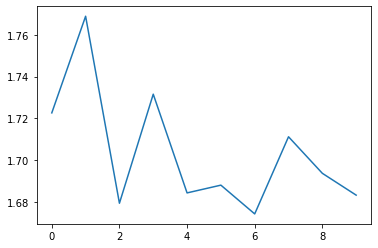

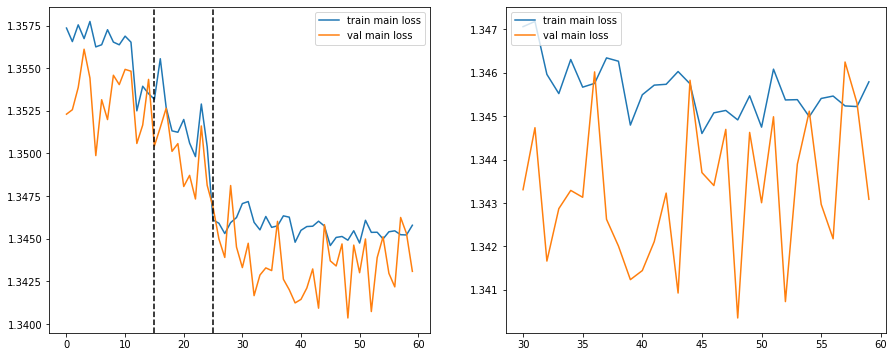

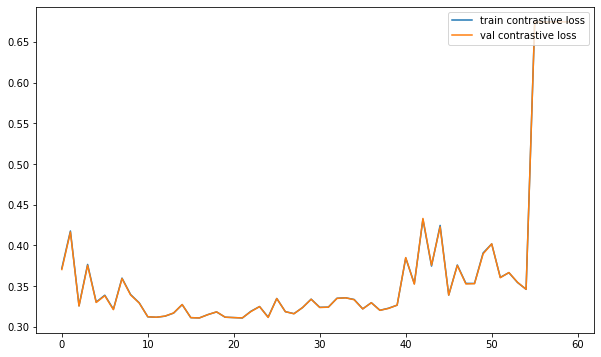

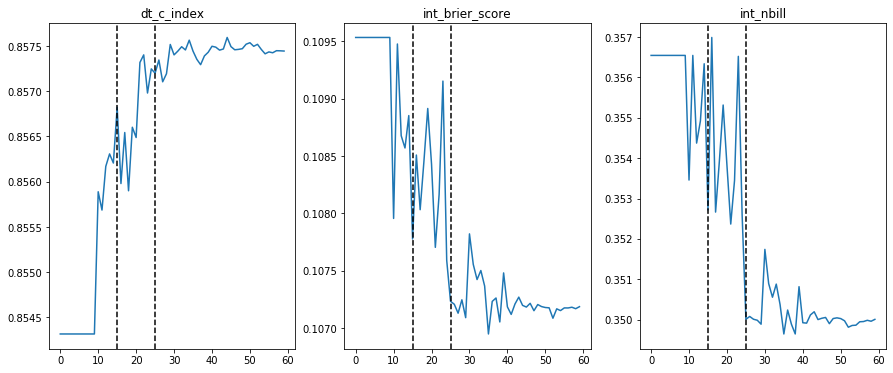

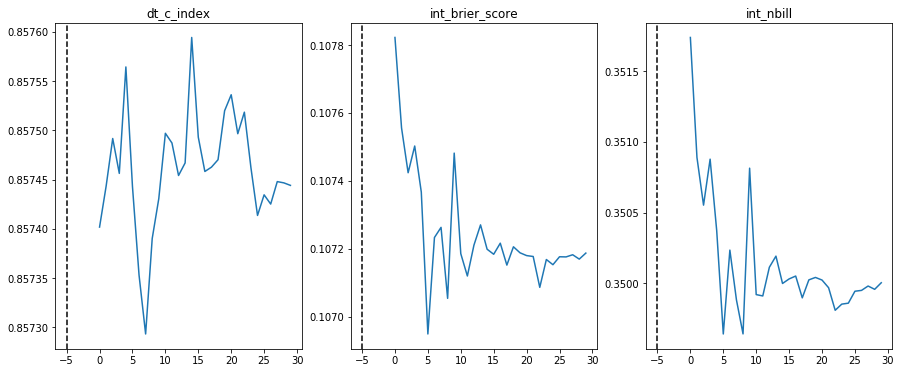

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/50 [00:00<?, ?it/s]

val loss after step 2:  [2.0757968, 1.9912024, 1.9899966, 1.981331, 1.9785497, 1.9788663, 2.0597343, 1.9756609, 2.020341, 1.9791124]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 50/50 [8:49:14<00:00, 635.09s/it]  


val loss after step 3:  [2.0757968, 1.9912024, 1.9899966, 1.981331, 1.9785497, 1.9788663, 2.0597343, 1.9756609, 2.020341, 1.9791124, 1.9790794, 1.9766672, 1.975738, 1.9866725, 1.9978409, 1.9847882, 1.976451, 1.9936988, 1.9849498, 1.9789351, 1.9760904, 1.9887593, 1.9872115, 2.0093107, 1.971867, 1.9838108, 2.0243714, 2.0135775, 1.9787672, 2.0211408, 2.0026093, 1.9992963, 2.014822, 2.0247204, 1.9919281, 1.9976952, 1.9948102, 1.9915024, 1.984898, 1.995989, 2.209976, 2.0398684, 2.1373568, 2.2584023, 2.0438418, 2.0281415, 2.0363786, 2.1088502, 2.0676606, 2.0265858, 2.032176, 2.0895696, 2.1410658, 2.2552762, 2.0380557, 2.6918285, 2.6912365, 2.6952507, 2.69473, 2.6923728]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3571597, 1.3563474, 1.3547515, 1.3544724, 1.3567945, 1.3553817, 1.356363, 1.3551404, 1.3522365, 1.3542475, 1.3536589, 1.3499627, 1.3526993, 1.3583943, 1.3497856, 1.347234, 1.345582, 1.3444

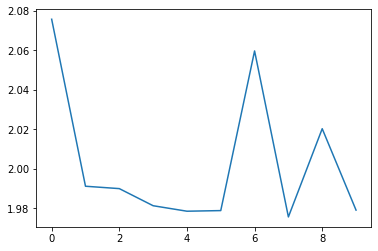

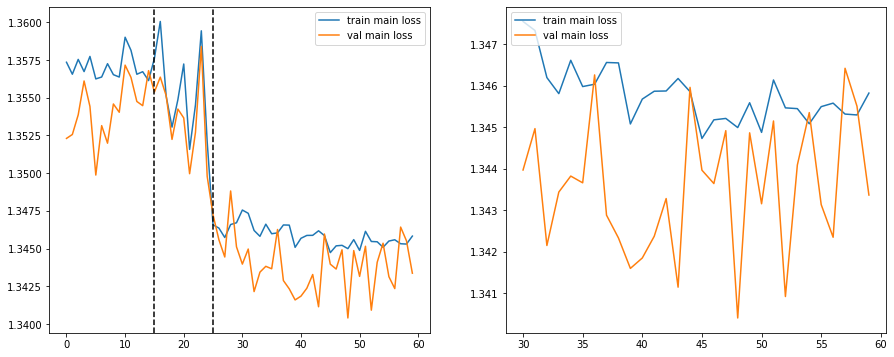

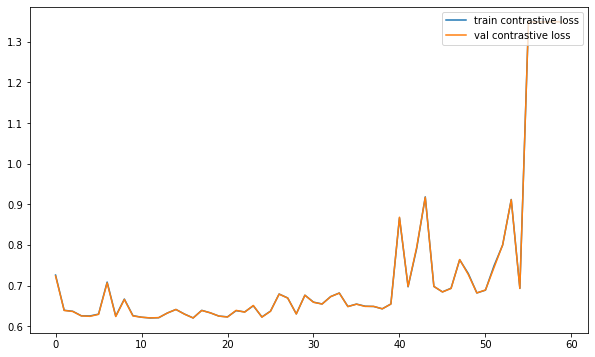

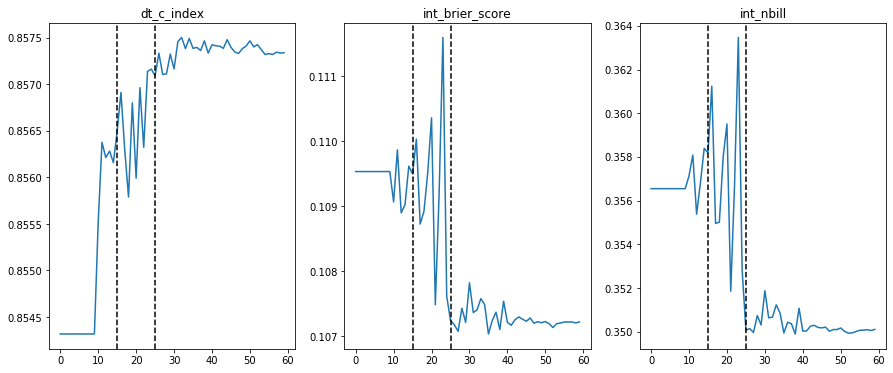

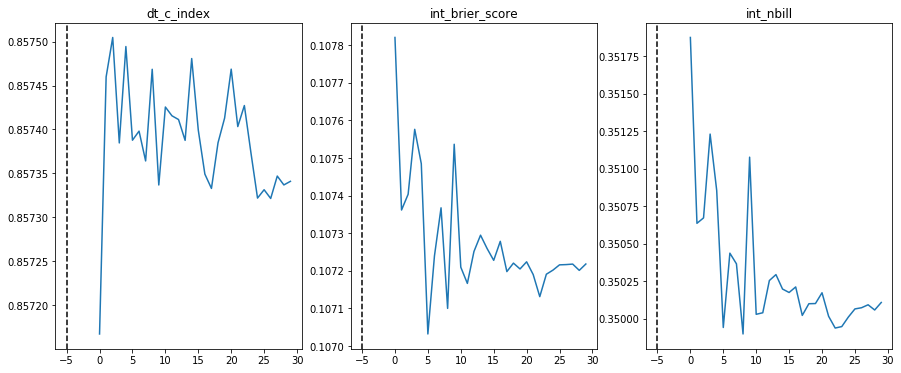

In [63]:
contrastive_weight = [0.5, 1]
all_q = []
for cw in contrastive_weight:
    config.update({'contrastive_weight': cw})
    iter_q = train_contrastive(config)
    iter_q['contrastive_weight'] = config['contrastive_weight']
    iter_q['margin_weight'] = config['margin_weight']
    all_q.append(iter_q)
    plot_results(iter_q['hist_losses_main_train'], iter_q['hist_losses_main_val'], iter_q['hist_losses_train'], iter_q['hist_losses_val'], iter_q, 
                 n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
                )      
    df_all_q = pd.concat(all_q)
    df_all_q.to_csv('../../output/kkbox_contr_1.csv')

In [65]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 50,
    'learning_rate_both': 0.00025,
    'step_rate_both': 15,
    'decay_both': 0.1,
    'momentum_both': 0.9
}

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/50 [00:00<?, ?it/s]

val loss after step 2:  [3.388657, 3.4378498, 3.452139, 3.2718558, 3.4109488, 3.3335598, 3.3092847, 3.2532861, 3.5647528, 3.367049]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 50/50 [8:50:58<00:00, 637.17s/it]  


val loss after step 3:  [3.388657, 3.4378498, 3.452139, 3.2718558, 3.4109488, 3.3335598, 3.3092847, 3.2532861, 3.5647528, 3.367049, 3.2112832, 3.2152395, 3.2160273, 3.2243931, 3.2171001, 3.2100956, 3.2167563, 3.2171602, 3.2479901, 3.232871, 3.2162452, 3.2177157, 3.352799, 3.2187598, 3.2276728, 3.3142726, 3.3323014, 3.2741039, 3.24781, 3.2382562, 3.2117817, 3.260939, 3.327012, 3.3792741, 3.2508757, 3.227204, 3.3089547, 3.2620378, 3.226774, 3.2248514, 3.5052922, 3.737642, 3.9977798, 3.4762423, 3.636772, 4.2298417, 3.5058725, 3.4739382, 3.7885327, 3.4957001, 3.4644563, 3.4010246, 3.6536696, 3.8053062, 3.5206218, 5.3894143, 5.389388, 5.393246, 5.393437, 5.3905764]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3658553, 1.3664364, 1.3701013, 1.3594879, 1.3665549, 1.3630201, 1.3625578, 1.361154, 1.3618735, 1.3851092, 1.3621225, 1.361241, 1.3777397, 1.3656988, 1.3561507, 1.3499104, 1.3478683, 1.3467412

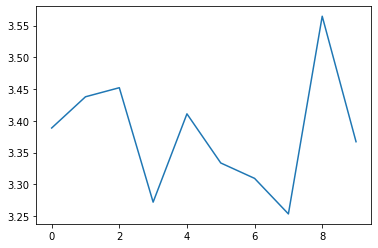

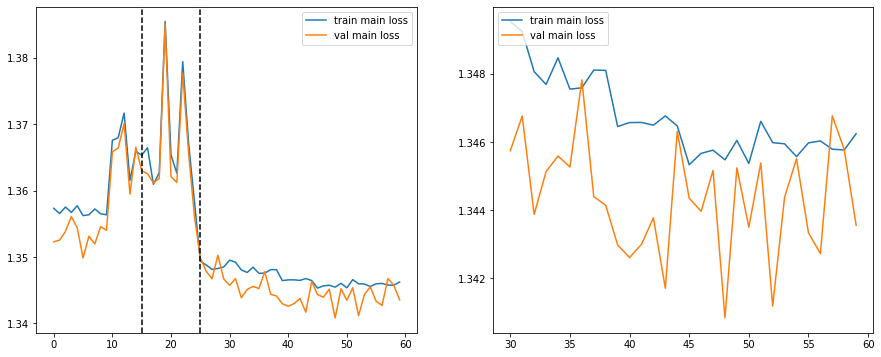

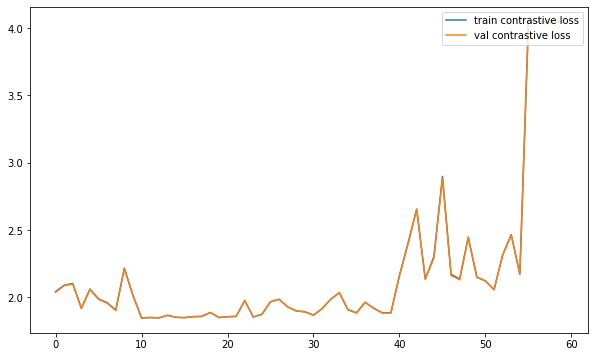

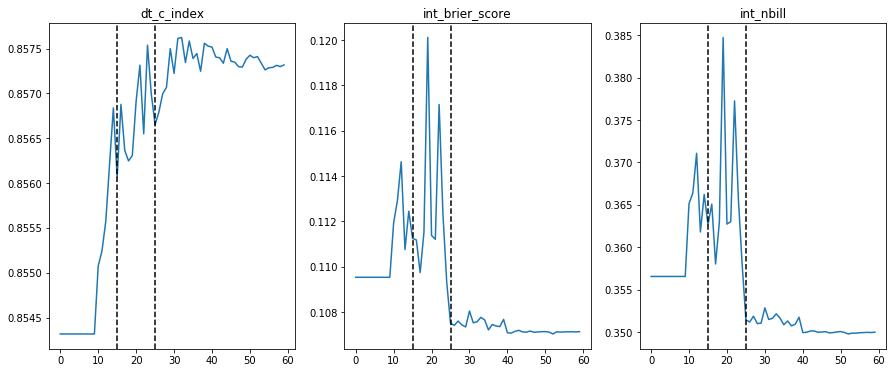

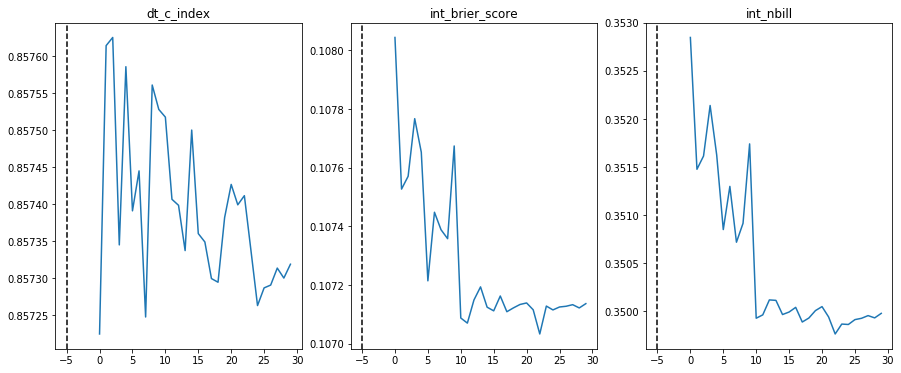

INFO:tensorflow:Restoring parameters from ../../models/mommentum_model


  0%|          | 0/50 [00:00<?, ?it/s]

val loss after step 2:  [4.831454, 4.5219603, 4.582749, 4.64063, 4.4764333, 4.9912424, 4.955921, 4.7812, 4.6016197, 4.879782]
val main loss after step 2:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353]


100%|██████████| 50/50 [8:50:04<00:00, 636.08s/it]  


val loss after step 3:  [4.831454, 4.5219603, 4.582749, 4.64063, 4.4764333, 4.9912424, 4.955921, 4.7812, 4.6016197, 4.879782, 4.45717, 4.442528, 4.4914713, 4.521749, 4.598973, 4.4751873, 4.5685024, 4.5146565, 4.4993753, 4.5380583, 4.4950585, 4.463962, 4.4977655, 4.4837494, 4.4623237, 4.585956, 4.8387084, 4.490955, 4.735041, 4.67233, 4.630231, 4.560554, 4.6951523, 4.496569, 4.657864, 4.5865664, 4.633289, 4.6107826, 4.5300436, 4.6440344, 4.674533, 5.015737, 5.5771947, 4.7240586, 6.366122, 5.2452526, 4.8092837, 4.9676967, 4.8425856, 4.7270083, 4.954959, 5.3916345, 4.978682, 4.7449007, 4.712194, 8.087239, 8.087795, 8.091343, 8.092335, 8.089112]
val main loss after step 3:  [1.352302, 1.3525621, 1.3538672, 1.3561095, 1.3544207, 1.3498732, 1.353149, 1.351985, 1.3545839, 1.3540353, 1.3836535, 1.3751647, 1.3797177, 1.3688731, 1.4240824, 1.377005, 1.4011488, 1.3718632, 1.3780812, 1.3821892, 1.3636206, 1.3664805, 1.3692456, 1.3691945, 1.3619132, 1.3510255, 1.3492343, 1.347917, 1.3514779, 1.34801

In [ ]:
contrastive_weight = [3, 5]
all_q = []
for cw in contrastive_weight:
    config.update({'contrastive_weight': cw})
    iter_q = train_contrastive(config)
    iter_q['contrastive_weight'] = config['contrastive_weight']
    iter_q['margin_weight'] = config['margin_weight']
    all_q.append(iter_q)
    plot_results(iter_q['hist_losses_main_train'], iter_q['hist_losses_main_val'], iter_q['hist_losses_train'], iter_q['hist_losses_val'], iter_q, 
                 n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
                )      
    df_all_q = pd.concat(all_q)
    df_all_q.to_csv('../../output/kkbox_contr_2.csv')

In [9]:
df = []
for path in ['../../output/kkbox_contr_2.csv', '../../output/kkbox_contr_1.csv', '../../output/kkbox_contr_0.csv']: 
    df_part = pd.read_csv(path)
    df.append(df_part)

df = pd.concat(df)
df = df.drop(['Unnamed: 0'], axis=1)

In [21]:
df.sample(5)

dt_c_index  int_brier_score  int_nbill  hist_losses_train  \
31    0.857614         0.107527   0.351477           3.264396   
83    0.857140         0.111600   0.363467           2.009484   
71    0.856378         0.109868   0.358083           1.978233   
38    0.857455         0.107048   0.349530           1.408676   
51    0.857608         0.107177   0.349923           1.434692   

    hist_losses_main_train  hist_losses_val  hist_losses_main_val  \
31                1.349238         3.260939              1.346759   
83                1.359434         2.009311              1.358394   
71                1.358141         1.976667              1.356347   
38                1.346044         1.404172              1.341592   
51                1.345914         1.433487              1.344771   

    contrastive_weight  margin_weight  
31                 3.0              1  
83                 1.0              1  
71                 1.0              1  
38                 0.1              1  
51                 0.1              1

In [29]:
df = df.reset_index()

In [36]:
df

index  dt_c_index  int_brier_score  int_nbill  hist_losses_train  \
180      0    0.854317         0.109534   0.356547           1.427137   
181      1    0.854317         0.109534   0.356547           1.430068   
182      2    0.854317         0.109534   0.356547           1.423871   
183      3    0.854317         0.109534   0.356547           1.428303   
184      4    0.854317         0.109534   0.356547           1.428321   
..     ...         ...              ...        ...                ...   
55      55    0.857287         0.107125   0.349915           5.395528   
56      56    0.857291         0.107128   0.349929           5.396257   
57      57    0.857314         0.107133   0.349957           5.395241   
58      58    0.857300         0.107122   0.349933           5.394867   
59      59    0.857319         0.107136   0.349980           5.395686   

     hist_losses_main_train  hist_losses_val  hist_losses_main_val  \
180                1.357350         1.421900              1.352302   
181                1.356557         1.425923              1.352562   
182                1.357539         1.420140              1.353867   
183                1.356732         1.427525              1.356109   
184                1.357737         1.424839              1.354421   
..                      ...              ...                   ...   
55                 1.345972         5.389414              1.343335   
56                 1.346030         5.389388              1.342721   
57                 1.345787         5.393246              1.346768   
58                 1.345765         5.393437              1.345778   
59                 1.346243         5.390576              1.343552   

    contrastive_weight  margin_weight  
180                0.1              1  
181                0.1              1  
182                0.1              1  
183                0.1              1  
184                0.1              1  
..                 ...            ...  
55                 3.0              1  
56                 3.0              1  
57                 3.0              1  
58                 3.0              1  
59                 3.0              1  

[240 rows x 10 columns]

In [24]:
df['contrastive_weight'] = df['contrastive_weight'].astype(str)

In [31]:
df = df.sort_values(['contrastive_weight', 'index'])

In [37]:
df.loc[df['contrastive_weight'] == '1.0', 'index'] = df.loc[df['contrastive_weight'] == '1.0', 'index'] - 60

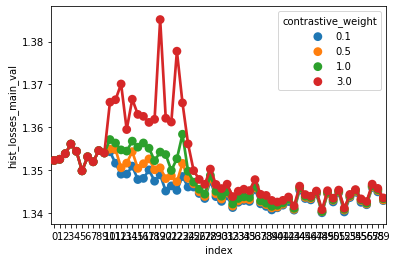

In [38]:
sns.pointplot(data=df, x='index', y='hist_losses_main_val', hue='contrastive_weight');

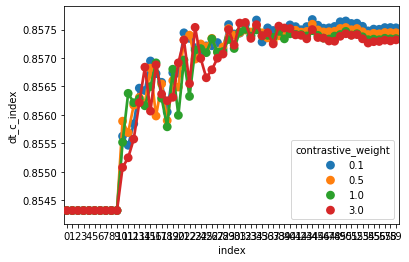

In [40]:
sns.pointplot(data=df, x='index', y='dt_c_index', hue='contrastive_weight');

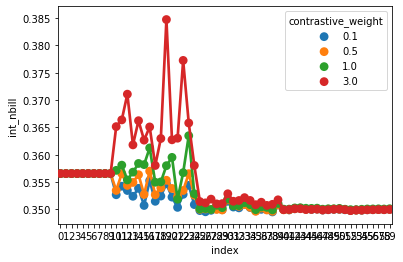

In [41]:
sns.pointplot(data=df, x='index', y='int_nbill', hue='contrastive_weight');

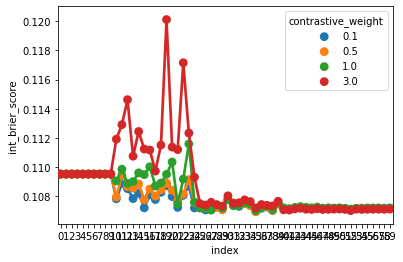

In [42]:
sns.pointplot(data=df, x='index', y='int_brier_score', hue='contrastive_weight');

In [ ]:
# fix contrastive weight 0.1 and change margin weight

In [11]:
def initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=None, params_ends='', opt_type='sgd'):
    """ Define GradientDescentOptimizer from config """

    global_step = tf.Variable(0, trainable=False)
    # if exponential decay of learning rate is specified in config
    if ('step_rate' + params_ends not in config.keys()) or (config['step_rate'  + params_ends] == 0) or (
            'decay'  + params_ends not in config.keys()) or (config['decay' + params_ends] == 1):
        learning_rate = config['learning_rate' + params_ends]
    else:
        learning_rate = tf.train.exponential_decay(
            config['learning_rate' + params_ends], global_step, config['step_rate' + params_ends], config['decay' + params_ends], staircase=True)
    if var_list is None:
        var_list = tf.global_variables()
    if opt_type == 'sgd':        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    elif opt_type == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=config['momentum' + params_ends])
    if opt_type == 'adam':        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        
    if optimize_only_main_loss:
        train_op = optimizer.minimize(model.main_loss, var_list=var_list)
    else:
        train_op = optimizer.minimize(model.loss, var_list=var_list)
        
    return train_op, global_step, optimizer


def run_step(sess, data_gen, model, optimizer, global_step, train_op, n_epochs, train_data, val_data=None):
    
    increment_global_step = tf.assign(global_step, global_step + 1)    
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))
        
        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])

#         print(sess.run(optimizer._learning_rate))
        sess.run(increment_global_step)
#         print(sess.run(optimizer._learning_rate))
        
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val



def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None, optimizers=['sgd', 'sgd', 'sgd'], first_step_load=False):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w, optimizer_w = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=True, var_list=trainable_binary, opt_type=optimizers[0])
    train_op_c, global_step_c, optimizer_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr, params_ends='_contr', opt_type=optimizers[1])
    train_op_w_c, global_step_w_c, optimizer_w_c = initialize_sgd_optimizer(
        config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary, params_ends='_both', opt_type=optimizers[2])
    
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        if first_step_load:
            # Restore variables from disk
            saver = tf.train.import_meta_graph(args['save_path'] + args["model_type"] + "_model" + '.meta')
            saver.restore(sess, args['save_path'] + args["model_type"] + "_model" )
        else:
            # optimize main loss
            (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
                sess, data_gen, model, optimizer_w, global_step_w, train_op_w, config['n_epochs'], train_data, val_data=val_data)
            hist_losses_train.extend(step_hist_losses_train)
            hist_losses_val.extend(step_hist_losses_val)
            hist_losses_main_train.extend(step_hist_losses_main_train)
            hist_losses_main_val.extend(step_hist_losses_main_val)
            all_pred_train.extend(step_all_pred_train)
            all_pred_val.extend(step_all_pred_val)
            print("val loss after step 1: ", hist_losses_val)
            print("val main loss after step 1: ", hist_losses_main_val)


            # save model
            if args['verbose'] == 1:
                print("Save model...")
            saver = tf.train.Saver()
            if args['save_model']:
                saver.save(sess, args['save_path'] + args["model_type"] + "_model")
            
            
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_c, global_step_c, train_op_c, config['n_epochs_contr'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        plt.plot(step_hist_losses_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, optimizer_w_c, global_step_w_c, train_op_w_c, config['n_epochs_both'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        

    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val


def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(n_epochs[0], c='black', linestyle='--')
    ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0], c='black', linestyle='--')
    ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
    ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();


In [13]:
def train_contrastive(config):
    q = []
    tf.reset_default_graph()

    data_gen, model = initialize_model(
        model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

    hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
        args=args, train_data=data['train'], val_data=data['val'], config=config,
        data_gen=data_gen, model=model, seed=config['seed'], optimizers=['sgd', 'adam', 'adam'], first_step_load=False)

    
    for pred in all_pred_val:
        q.append(
            test_quality(
                t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False
            )
        )
    df_all_q = pd.concat(q)
    df_all_q.reset_index(drop=True, inplace=True)
    df_all_q['hist_losses_train'] = hist_losses_train
    df_all_q['hist_losses_main_train'] = hist_losses_main_train
    df_all_q['hist_losses_val'] = hist_losses_val
    df_all_q['hist_losses_main_val'] = hist_losses_main_val

    return df_all_q

In [14]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../models/',
    'model_type': 'mommentum_new'
}


config = {
    'seed': 2,
    'alpha_reg': 1e-06,
    'alpha_bias_random_mean': 10,
    'alpha_random_stddev': 5,
    'beta_random_stddev': 5,
    'n_time_bins': 10,
    'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
    'n_ex_bin': 30,
    'val_n_ex_bin': 1000,
    
    'cross_entropy_weight': 0.1,
    
    'margin_weight': 1,
    'contrastive_weight': 0.1,
    
    'n_epochs': 15,
    'step_rate': 10,
    'decay': 0.9,
    'learning_rate': 0.001,

    'n_epochs_contr': 10,
    'learning_rate_contr': 0.0005,   
    'step_rate_contr': 5,
    'decay_contr': 0.9,
    'momentum_contr': 0.9,
    
    'n_epochs_both': 50,
    'learning_rate_both': 0.00025,
    'step_rate_both': 15,
    'decay_both': 0.1,
    'momentum_both': 0.9
}

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


100%|██████████| 15/15 [2:37:05<00:00, 628.36s/it] 


val loss after step 1:  [107.123955, 109.50898, 119.61411, 107.07019, 124.33793, 138.34163, 128.8125, 131.01071, 110.0366, 110.64069, 135.35457, 114.28812, 138.22963, 118.259865, 127.75409]
val main loss after step 1:  [1.3913547, 1.3729434, 1.3678011, 1.366683, 1.3629547, 1.3575531, 1.3578668, 1.3555098, 1.3576021, 1.356201, 1.3561705, 1.3558192, 1.3551836, 1.3541362, 1.3559756]


  0%|          | 0/50 [00:00<?, ?it/s]

val loss after step 2:  [107.123955, 109.50898, 119.61411, 107.07019, 124.33793, 138.34163, 128.8125, 131.01071, 110.0366, 110.64069, 135.35457, 114.28812, 138.22963, 118.259865, 127.75409, 1.9620934, 1.9583983, 1.9675543, 1.9620543, 1.9675807, 1.9588933, 1.9602454, 1.9666353, 1.9598126, 1.9578298]
val main loss after step 2:  [1.3913547, 1.3729434, 1.3678011, 1.366683, 1.3629547, 1.3575531, 1.3578668, 1.3555098, 1.3576021, 1.356201, 1.3561705, 1.3558192, 1.3551836, 1.3541362, 1.3559756, 1.3531526, 1.352039, 1.3556646, 1.3541684, 1.3554367, 1.3520603, 1.3534279, 1.3524548, 1.3544897, 1.3537235]


100%|██████████| 50/50 [8:49:27<00:00, 635.34s/it]  


val loss after step 3:  [107.123955, 109.50898, 119.61411, 107.07019, 124.33793, 138.34163, 128.8125, 131.01071, 110.0366, 110.64069, 135.35457, 114.28812, 138.22963, 118.259865, 127.75409, 1.9620934, 1.9583983, 1.9675543, 1.9620543, 1.9675807, 1.9588933, 1.9602454, 1.9666353, 1.9598126, 1.9578298, 1.9592142, 1.9790512, 1.9514089, 1.9694467, 1.9518373, 1.9498013, 1.9507856, 1.9480183, 1.9507875, 1.9508778, 1.9506449, 1.9570712, 1.9490246, 1.94878, 1.9483635, 1.9500465, 1.9686168, 1.963738, 1.9636045, 1.9645039, 1.9646045, 1.9719863, 1.9596025, 1.9476848, 1.9662269, 1.9840668, 1.9740875, 1.9769701, 1.9657422, 1.959236, 2.0266519, 2.0196476, 2.0214748, 2.0144, 2.206121, 2.0300195, 2.020785, 2.0108817, 2.022258, 2.0048342, 2.0277648, 2.0908334, 2.0270336, 2.0265534, 2.029905, 2.6938796, 2.6946113, 2.6931093, 2.6910086, 2.6900933]
val main loss after step 3:  [1.3913547, 1.3729434, 1.3678011, 1.366683, 1.3629547, 1.3575531, 1.3578668, 1.3555098, 1.3576021, 1.356201, 1.3561705, 1.3558192, 1

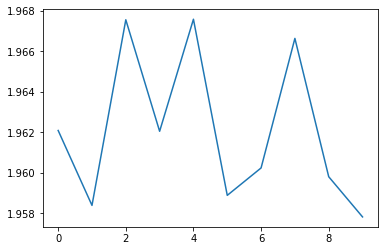

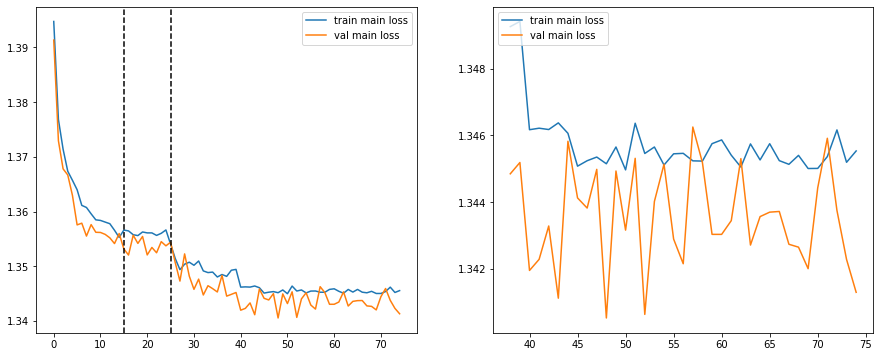

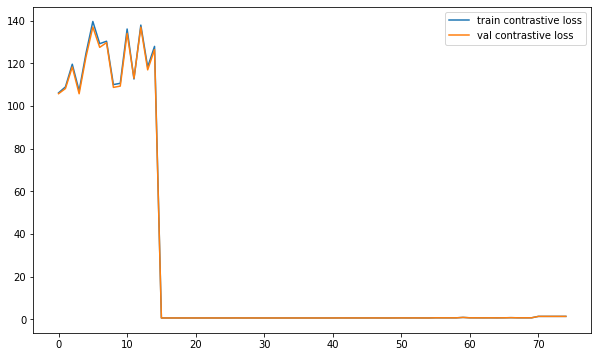

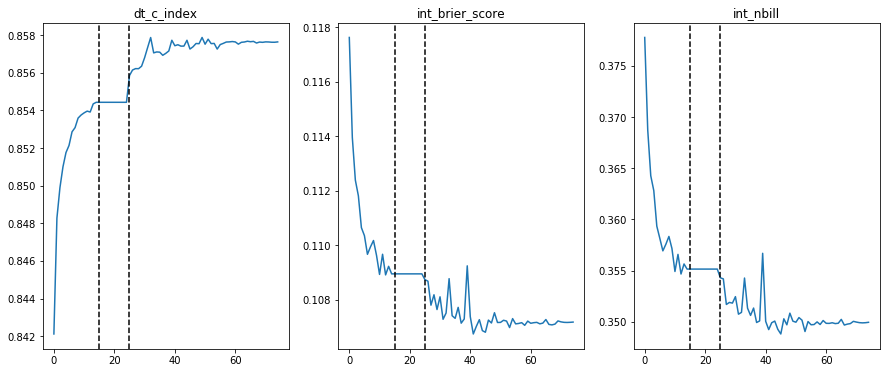

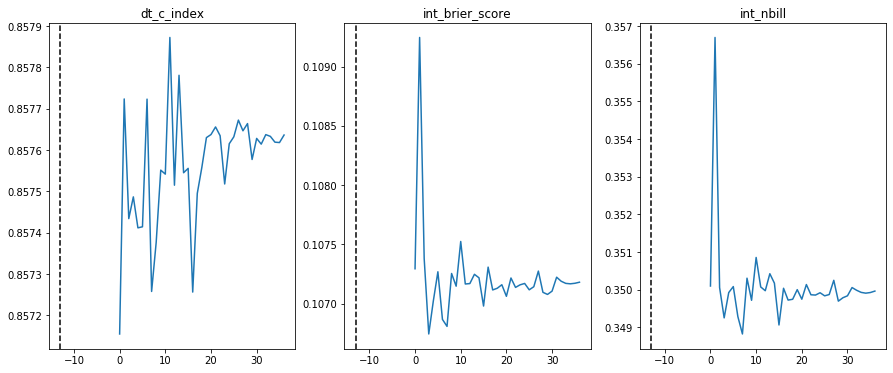

100%|██████████| 15/15 [2:36:12<00:00, 624.86s/it] 


val loss after step 1:  [108.15019, 110.16476, 120.45281, 108.34185, 123.84297, 136.45103, 129.48285, 130.70302, 108.53322, 110.15066, 133.49208, 114.70861, 136.60437, 117.81182, 128.47595]
val main loss after step 1:  [1.3913636, 1.3728644, 1.3678288, 1.3666834, 1.363055, 1.3577195, 1.3580035, 1.3555744, 1.3579872, 1.3562826, 1.3561444, 1.3557824, 1.3553367, 1.3541467, 1.3560396]


  0%|          | 0/50 [00:00<?, ?it/s]

val loss after step 2:  [108.15019, 110.16476, 120.45281, 108.34185, 123.84297, 136.45103, 129.48285, 130.70302, 108.53322, 110.15066, 133.49208, 114.70861, 136.60437, 117.81182, 128.47595, 7.3584757, 7.368387, 7.3574557, 7.38306, 7.3618474, 7.367741, 7.4079475, 7.541263, 7.356292, 7.3870506]
val main loss after step 2:  [1.3913636, 1.3728644, 1.3678288, 1.3666834, 1.363055, 1.3577195, 1.3580035, 1.3555744, 1.3579872, 1.3562826, 1.3561444, 1.3557824, 1.3553367, 1.3541467, 1.3560396, 1.35323, 1.3520544, 1.3557793, 1.3542359, 1.3554312, 1.3520213, 1.3534513, 1.3524299, 1.3545474, 1.3538172]


100%|██████████| 50/50 [8:53:38<00:00, 640.38s/it]  


val loss after step 3:  [108.15019, 110.16476, 120.45281, 108.34185, 123.84297, 136.45103, 129.48285, 130.70302, 108.53322, 110.15066, 133.49208, 114.70861, 136.60437, 117.81182, 128.47595, 7.3584757, 7.368387, 7.3574557, 7.38306, 7.3618474, 7.367741, 7.4079475, 7.541263, 7.356292, 7.3870506, 7.4413157, 7.3566585, 7.3580127, 7.378302, 7.38555, 7.405642, 7.353868, 7.346157, 7.3604465, 7.355976, 7.3470507, 7.3587728, 7.362047, 7.352615, 7.359896, 8.037065, 7.728634, 7.453484, 7.8405347, 7.5834723, 7.647252, 8.046941, 7.6242247, 7.917876, 7.5372376, 7.864576, 7.486205, 7.8492956, 7.622715, 7.77394, 9.151277, 8.179418, 8.768903, 9.133926, 8.045468, 8.163251, 8.305982, 8.295872, 8.673666, 9.131637, 8.324925, 8.156876, 9.3802395, 8.094999, 9.168014, 14.83911, 14.833022, 14.83755, 14.829767, 14.8293705]
val main loss after step 3:  [1.3913636, 1.3728644, 1.3678288, 1.3666834, 1.363055, 1.3577195, 1.3580035, 1.3555744, 1.3579872, 1.3562826, 1.3561444, 1.3557824, 1.3553367, 1.3541467, 1.3560396

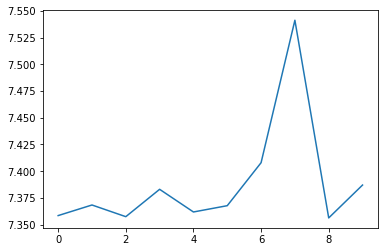

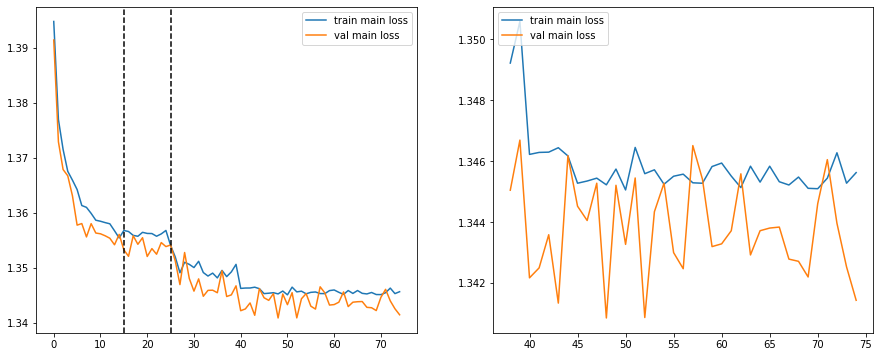

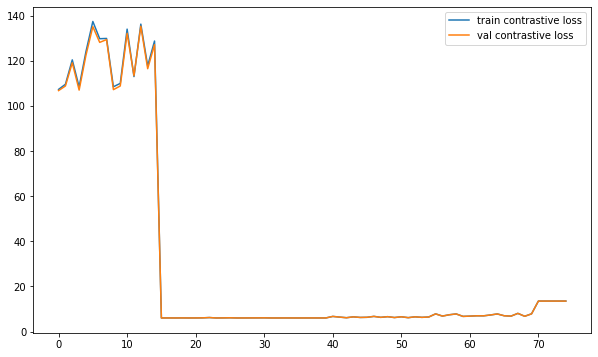

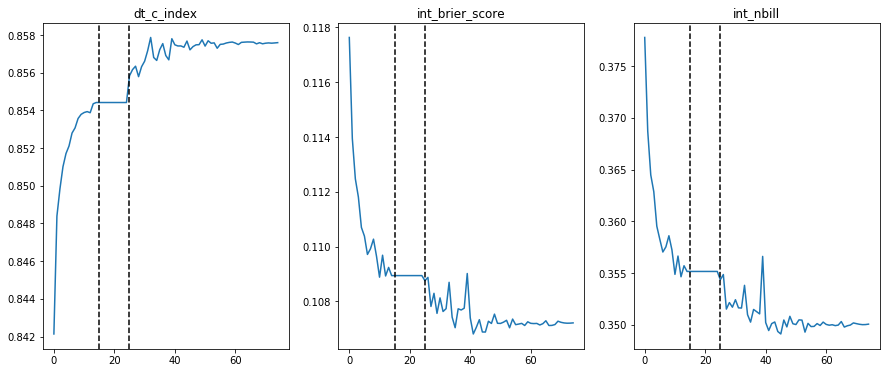

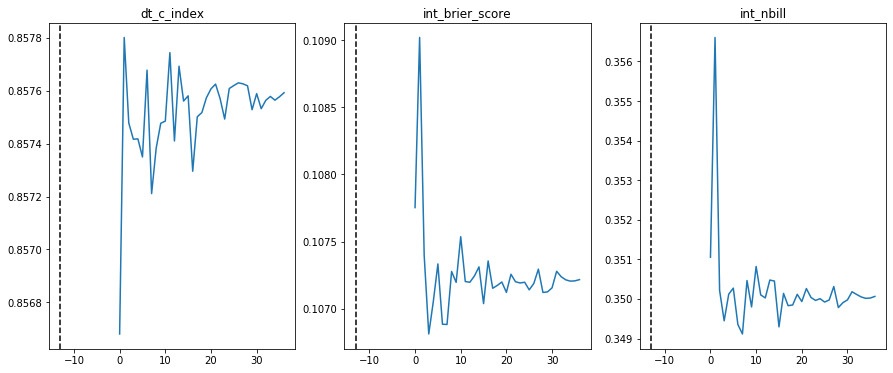

In [15]:
margin_weight = [10, 100]
all_q = []
for cw in margin_weight:
    config.update({'margin_weight': cw})
    iter_q = train_contrastive(config)
    iter_q['contrastive_weight'] = config['contrastive_weight']
    iter_q['margin_weight'] = config['margin_weight']
    all_q.append(iter_q)
    plot_results(iter_q['hist_losses_main_train'], iter_q['hist_losses_main_val'], iter_q['hist_losses_train'], iter_q['hist_losses_val'], iter_q, 
                 n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
                )      
    df_all_q = pd.concat(all_q)
    df_all_q.to_csv('../../output/kkbox_contr_3.csv')

In [18]:
df = []
for path in ['../../output/kkbox_contr_0.csv', '../../output/kkbox_contr_3.csv']: 
    df_part = pd.read_csv(path)
    df.append(df_part)

df = pd.concat(df)
df = df.drop(['Unnamed: 0'], axis=1)

In [19]:
df.sample(5)

dt_c_index  int_brier_score  int_nbill  hist_losses_train  \
54    0.857256         0.107308   0.350037           1.959861   
66    0.857664         0.107095   0.349695           2.094198   
50    0.857651         0.107177   0.349983           1.414059   
79    0.851711         0.110701   0.359526         125.456779   
21    0.854427         0.108951   0.355156           1.962696   

    hist_losses_main_train  hist_losses_val  hist_losses_main_val  \
54                1.345113         1.959236              1.345137   
66                1.345244         2.090833              1.343721   
50                1.344591         1.412120              1.342631   
79                1.365897       123.842972              1.363055   
21                1.356088         1.960245              1.353428   

    contrastive_weight  margin_weight  
54                 0.1             10  
66                 0.1             10  
50                 0.1              1  
79                 0.1            100  
21                 0.1             10

In [20]:
df = df.reset_index()

In [21]:
df

index  dt_c_index  int_brier_score  int_nbill  hist_losses_train  \
0        0    0.854317         0.109534   0.356547           1.427137   
1        1    0.854317         0.109534   0.356547           1.430068   
2        2    0.854317         0.109534   0.356547           1.423871   
3        3    0.854317         0.109534   0.356547           1.428303   
4        4    0.854317         0.109534   0.356547           1.428321   
..     ...         ...              ...        ...                ...   
205    145    0.857564         0.107239   0.350113          14.842476   
206    146    0.857579         0.107216   0.350051          14.842788   
207    147    0.857564         0.107206   0.350014          14.844790   
208    148    0.857577         0.107209   0.350023          14.843891   
209    149    0.857593         0.107218   0.350063          14.844117   

     hist_losses_main_train  hist_losses_val  hist_losses_main_val  \
0                  1.357350         1.421900              1.352302   
1                  1.356557         1.425923              1.352562   
2                  1.357539         1.420140              1.353867   
3                  1.356732         1.427525              1.356109   
4                  1.357737         1.424839              1.354421   
..                      ...              ...                   ...   
205                1.345092        14.839110              1.344602   
206                1.345438        14.833022              1.346047   
207                1.346273        14.837550              1.343957   
208                1.345273        14.829767              1.342523   
209                1.345621        14.829370              1.341426   

     contrastive_weight  margin_weight  
0                   0.1              1  
1                   0.1              1  
2                   0.1              1  
3                   0.1              1  
4                   0.1              1  
..                  ...            ...  
205                 0.1            100  
206                 0.1            100  
207                 0.1            100  
208                 0.1            100  
209                 0.1            100  

[210 rows x 10 columns]

In [23]:
df['contrastive_weight'] = df['contrastive_weight'].astype(str)
df['margin_weight'] = df['margin_weight'].astype(str)

In [24]:
df = df.sort_values(['margin_weight', 'index'])

In [33]:
df0 = df[df['margin_weight'] == '1'][-60:]
df0

index  dt_c_index  int_brier_score  int_nbill  hist_losses_train  \
0       0    0.854317         0.109534   0.356547           1.427137   
1       1    0.854317         0.109534   0.356547           1.430068   
2       2    0.854317         0.109534   0.356547           1.423871   
3       3    0.854317         0.109534   0.356547           1.428303   
4       4    0.854317         0.109534   0.356547           1.428321   
5       5    0.854317         0.109534   0.356547           1.429411   
6       6    0.854317         0.109534   0.356547           1.431310   
7       7    0.854317         0.109534   0.356547           1.419863   
8       8    0.854317         0.109534   0.356547           1.421779   
9       9    0.854317         0.109534   0.356547           1.419828   
10     10    0.855625         0.107842   0.352672           1.419170   
11     11    0.855465         0.108877   0.354230           1.418148   
12     12    0.855843         0.108534   0.353446           1.413163   
13     13    0.856470         0.107854   0.352389           1.418048   
14     14    0.856427         0.108221   0.353845           1.412514   
15     15    0.856947         0.107224   0.350709           1.413438   
16     16    0.856725         0.108107   0.355254           1.416074   
17     17    0.856572         0.107792   0.351470           1.414706   
18     18    0.856051         0.108286   0.352427           1.413114   
19     19    0.856741         0.108743   0.354678           1.411291   
20     20    0.856733         0.107995   0.352238           1.412594   
21     21    0.857443         0.107254   0.350360           1.411352   
22     22    0.857345         0.108083   0.352744           1.411114   
23     23    0.857181         0.108713   0.354389           1.413247   
24     24    0.857083         0.107217   0.350869           1.410723   
25     25    0.857213         0.107202   0.349770           1.408419   
26     26    0.857215         0.107076   0.349553           1.412702   
27     27    0.857271         0.107089   0.349827           1.409043   
28     28    0.857156         0.107347   0.350090           1.407826   
29     29    0.857588         0.107148   0.349936           1.409528   
30     30    0.857422         0.107775   0.351470           1.409893   
31     31    0.857438         0.107406   0.350421           1.409166   
32     32    0.857587         0.107324   0.350270           1.407711   
33     33    0.857399         0.107548   0.350941           1.407477   
34     34    0.857668         0.107394   0.350339           1.408146   
35     35    0.857282         0.107037   0.349730           1.410027   
36     36    0.857530         0.107190   0.350005           1.410601   
37     37    0.857484         0.107306   0.349953           1.408351   
38     38    0.857455         0.107048   0.349530           1.408676   
39     39    0.857497         0.107498   0.350797           1.408315   
40     40    0.857582         0.107215   0.349976           1.414568   
41     41    0.857552         0.107126   0.349895           1.414522   
42     42    0.857497         0.107228   0.350105           1.414224   
43     43    0.857552         0.107287   0.350197           1.415960   
44     44    0.857677         0.107209   0.350007           1.415273   
45     45    0.857576         0.107178   0.349975           1.412524   
46     46    0.857525         0.107225   0.350029           1.446630   
47     47    0.857530         0.107157   0.349866           1.412796   
48     48    0.857555         0.107188   0.349940           1.421834   
49     49    0.857637         0.107189   0.349994           1.426144   
50     50    0.857651         0.107177   0.349983           1.414059   
51     51    0.857608         0.107177   0.349923           1.434692   
52     52    0.857612         0.107090   0.349779           1.412580   
53     53    0.857558         0.107174   0.349841           1.413041   
54     54    0.857477         0.107155   0.3

In [35]:
df1 = df[df['margin_weight'] == '10'][-60:]
df1['index'] = df0['index'].values
df1

index  dt_c_index  int_brier_score  int_nbill  hist_losses_train  \
75       0    0.854427         0.108951   0.355156           1.965911   
76       1    0.854427         0.108951   0.355156           1.963393   
77       2    0.854427         0.108951   0.355156           1.967750   
78       3    0.854427         0.108951   0.355156           1.963510   
79       4    0.854427         0.108951   0.355156           1.968432   
80       5    0.854427         0.108951   0.355156           1.963185   
81       6    0.854427         0.108951   0.355156           1.962696   
82       7    0.854427         0.108951   0.355156           1.969863   
83       8    0.854427         0.108951   0.355156           1.961600   
84       9    0.854427         0.108951   0.355156           1.961014   
85      10    0.855849         0.108739   0.354310           1.959489   
86      11    0.856141         0.108683   0.354196           1.979856   
87      12    0.856217         0.107801   0.351703           1.953541   
88      13    0.856213         0.108183   0.351904           1.967989   
89      14    0.856347         0.107641   0.351835           1.954765   
90      15    0.856799         0.108108   0.352468           1.954656   
91      16    0.857340         0.107284   0.350756           1.954207   
92      17    0.857869         0.107513   0.350932           1.952589   
93      18    0.857054         0.108775   0.354282           1.953294   
94      19    0.857103         0.107415   0.351341           1.953932   
95      20    0.857091         0.107318   0.350636           1.953690   
96      21    0.856925         0.107720   0.351353           1.957954   
97      22    0.857028         0.107140   0.349943           1.952506   
98      23    0.857155         0.107294   0.350097           1.953313   
99      24    0.857724         0.109245   0.356697           1.952785   
100     25    0.857434         0.107379   0.350056           1.954345   
101     26    0.857487         0.106744   0.349251           1.972556   
102     27    0.857412         0.107022   0.349923           1.967571   
103     28    0.857414         0.107268   0.350082           1.968896   
104     29    0.857723         0.106867   0.349285           1.965022   
105     30    0.857258         0.106808   0.348824           1.965604   
106     31    0.857376         0.107254   0.350305           1.973166   
107     32    0.857551         0.107147   0.349718           1.960228   
108     33    0.857542         0.107524   0.350855           1.951849   
109     34    0.857872         0.107165   0.350073           1.966864   
110     35    0.857515         0.107169   0.349972           1.985799   
111     36    0.857781         0.107247   0.350424           1.975817   
112     37    0.857545         0.107217   0.350173           1.981619   
113     38    0.857556         0.106979   0.349062           1.967808   
114     39    0.857256         0.107308   0.350037           1.959861   
115     40    0.857495         0.107115   0.349724           2.029824   
116     41    0.857558         0.107129   0.349745           2.023353   
117     42    0.857630         0.107159   0.350000           2.020651   
118     43    0.857637         0.107061   0.349747           2.014857   
119     44    0.857656         0.107216   0.350136           2.210761   
120     45    0.857635         0.107137   0.349865           2.033433   
121     46    0.857518         0.107158   0.349857           2.023083   
122     47    0.857615         0.107170   0.349918           2.010922   
123     48    0.857632         0.107116   0.349836           2.025702   
124     49    0.857672         0.107142   0.349871           2.006940   
125     50    0.857647         0.107274   0.350248           2.030346   
126     51    0.857664         0.107095   0.349695           2.094198   
127     52    0.857577         0.107077   0.349785           2.029234   
128     53    0.857628         0.107105   0.349837           2.

In [36]:
df2 = df[df['margin_weight'] == '100'][-60:]
df2['index'] = df0['index'].values
df2

index  dt_c_index  int_brier_score  int_nbill  hist_losses_train  \
150      0    0.854417         0.108943   0.355154           7.366315   
151      1    0.854417         0.108943   0.355154           7.378221   
152      2    0.854417         0.108943   0.355154           7.360603   
153      3    0.854417         0.108943   0.355154           7.384408   
154      4    0.854417         0.108943   0.355154           7.365248   
155      5    0.854417         0.108943   0.355154           7.373150   
156      6    0.854417         0.108943   0.355154           7.407961   
157      7    0.854417         0.108943   0.355154           7.546415   
158      8    0.854417         0.108943   0.355154           7.362696   
159      9    0.854417         0.108943   0.355154           7.392655   
160     10    0.855834         0.108758   0.354350           7.442823   
161     11    0.856160         0.108878   0.354856           7.356911   
162     12    0.856345         0.107817   0.351517           7.361123   
163     13    0.855789         0.108297   0.352150           7.379549   
164     14    0.856318         0.107565   0.351704           7.391498   
165     15    0.856607         0.108130   0.352424           7.414861   
166     16    0.857160         0.107633   0.351639           7.359716   
167     17    0.857868         0.107737   0.351619           7.352242   
168     18    0.856806         0.108699   0.353813           7.364681   
169     19    0.856648         0.107428   0.350981           7.357955   
170     20    0.857220         0.107042   0.350260           7.348537   
171     21    0.857543         0.107732   0.351483           7.357544   
172     22    0.856910         0.107689   0.351271           7.362466   
173     23    0.856680         0.107754   0.351053           7.359811   
174     24    0.857801         0.109020   0.356607           7.365319   
175     25    0.857478         0.107398   0.350216           8.038732   
176     26    0.857417         0.106813   0.349447           7.731073   
177     27    0.857418         0.107056   0.350120           7.462210   
178     28    0.857350         0.107335   0.350273           7.845879   
179     29    0.857678         0.106886   0.349355           7.585485   
180     30    0.857211         0.106884   0.349115           7.645844   
181     31    0.857383         0.107278   0.350465           8.050954   
182     32    0.857477         0.107197   0.349798           7.626952   
183     33    0.857485         0.107537   0.350821           7.920856   
184     34    0.857744         0.107203   0.350102           7.538392   
185     35    0.857410         0.107198   0.350026           7.867280   
186     36    0.857693         0.107245   0.350477           7.487962   
187     37    0.857561         0.107313   0.350453           7.853169   
188     38    0.857581         0.107039   0.349294           7.629044   
189     39    0.857296         0.107357   0.350139           7.773527   
190     40    0.857502         0.107153   0.349830           9.173226   
191     41    0.857517         0.107174   0.349847           8.185663   
192     42    0.857574         0.107200   0.350116           8.771558   
193     43    0.857607         0.107123   0.349934           9.134880   
194     44    0.857625         0.107258   0.350263           8.047278   
195     45    0.857570         0.107202   0.350039           8.161198   
196     46    0.857493         0.107193   0.349962           8.317037   
197     47    0.857608         0.107198   0.350007           8.297613   
198     48    0.857620         0.107142   0.349921           8.662487   
199     49    0.857630         0.107189   0.349975           9.129168   
200     50    0.857626         0.107296   0.350315           8.340207   
201     51    0.857619         0.107122   0.349782           8.162360   
202     52    0.857528         0.107126   0.349906           9.387095   
203     53    0.857589         0.107157   0.349976           8.

In [37]:
df_all = pd.concat([df0, df1, df2])

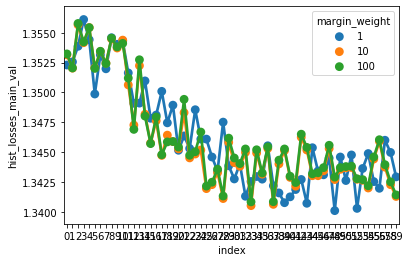

In [38]:
sns.pointplot(data=df_all, x='index', y='hist_losses_main_val', hue='margin_weight');

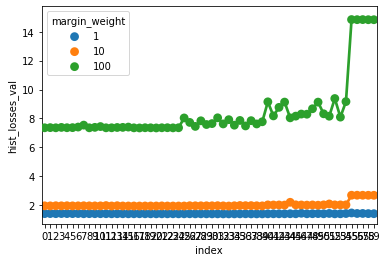

In [39]:
sns.pointplot(data=df_all, x='index', y='hist_losses_val', hue='margin_weight');

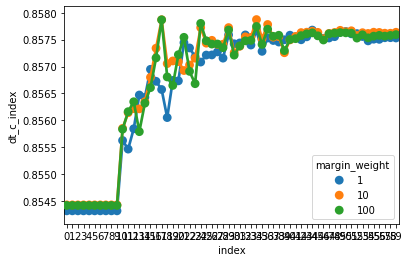

In [40]:
sns.pointplot(data=df_all, x='index', y='dt_c_index', hue='margin_weight');

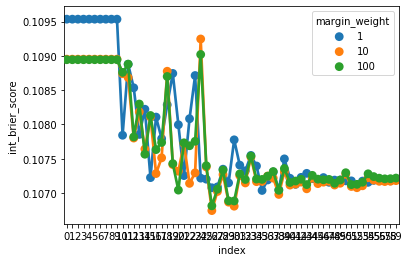

In [41]:
sns.pointplot(data=df_all, x='index', y='int_brier_score', hue='margin_weight');

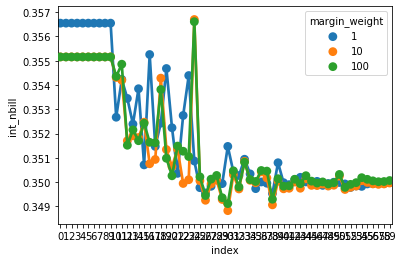

In [42]:
sns.pointplot(data=df_all, x='index', y='int_nbill', hue='margin_weight');